##### Copyright 2019 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Time series forecasting

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/structured_data/time_series"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/structured_data/time_series.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/time_series.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/structured_data/time_series.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This tutorial is an introduction to time series forecasting using TensorFlow. It builds a few different styles of models including Convolutional and Recurrent Neural Networks (CNNs and RNNs).

This is covered in two main parts, with subsections: 

* Forecast for a single timestep:
  * A single feature.
  * All features.
* Forecast multiple steps:
  * Single-shot: Make the predictions all at once.
  * Autoregressive: Make one prediction at a time and feed the output back to the model.

## Setup

In [2]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

## The weather dataset
This tutorial uses a <a href="https://www.bgc-jena.mpg.de/wetter/" class="external">weather time series dataset</a> recorded by the <a href="https://www.bgc-jena.mpg.de" class="external">Max Planck Institute for Biogeochemistry</a>.

This dataset contains 14 different features such as air temperature, atmospheric pressure, and humidity. These were collected every 10 minutes, beginning in 2003. For efficiency, you will use only the data collected between 2009 and 2016. This section of the dataset was prepared by François Chollet for his book [Deep Learning with Python](https://www.manning.com/books/deep-learning-with-python).

In [3]:
zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True)
csv_path, _ = os.path.splitext(zip_path)

    8192/13568290 [..............................] - ETA: 0s

 4202496/13568290 [========>.....................] - ETA: 0s

13574144/13568290 [==============================] - 0s 0us/step


This tutorial will just deal with **hourly predictions**, so start by sub-sampling the data from 10 minute intervals to 1h:

In [4]:
df = pd.read_csv(csv_path)
# slice [start:stop:step], starting from index 5 take every 6th record.
df = df[5::6]

date_time = pd.to_datetime(df.pop('Date Time'), format='%d.%m.%Y %H:%M:%S')

Let's take a glance at the data. Here are the first few rows:

In [5]:
df.head()

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
5,996.50,-8.05,265.38,-8.78,94.4,3.33,3.14,0.19,1.96,3.15,1307.86,0.21,0.63,192.7
11,996.62,-8.88,264.54,-9.77,93.2,3.12,2.90,0.21,1.81,2.91,1312.25,0.25,0.63,190.3
17,996.84,-8.81,264.59,-9.66,93.5,3.13,2.93,0.20,1.83,2.94,1312.18,0.18,0.63,167.2
23,996.99,-9.05,264.34,-10.02,92.6,3.07,2.85,0.23,1.78,2.85,1313.61,0.10,0.38,240.0
29,997.46,-9.63,263.72,-10.65,92.2,2.94,2.71,0.23,1.69,2.71,1317.19,0.40,0.88,157.0


Here is the evolution of a few features over time. 

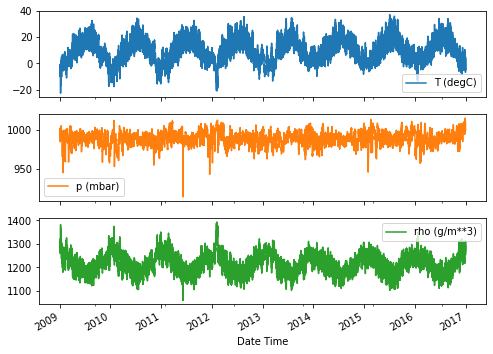

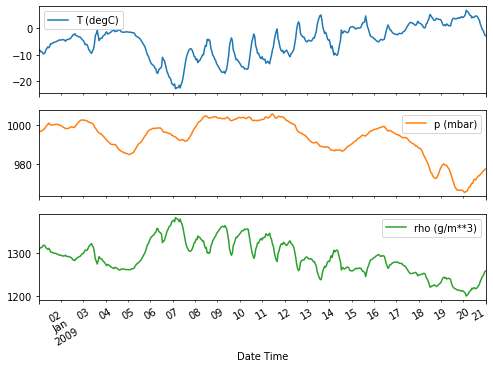

In [6]:
plot_cols = ['T (degC)', 'p (mbar)', 'rho (g/m**3)']
plot_features = df[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots=True)

plot_features = df[plot_cols][:480]
plot_features.index = date_time[:480]
_ = plot_features.plot(subplots=True)

### Inspect and cleanup

Next look at the statistics of the dataset:

In [7]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
p (mbar),70091.0,989.212842,8.358886,913.60,984.20,989.57,994.720,1015.29
T (degC),70091.0,9.450482,8.423384,-22.76,3.35,9.41,15.480,37.28
Tpot (K),70091.0,283.493086,8.504424,250.85,277.44,283.46,289.530,311.21
Tdew (degC),70091.0,4.956471,6.730081,-24.80,0.24,5.21,10.080,23.06
rh (%),70091.0,76.009788,16.474920,13.88,65.21,79.30,89.400,100.00
VPmax (mbar),70091.0,13.576576,7.739883,0.97,7.77,11.82,17.610,63.77
VPact (mbar),70091.0,9.533968,4.183658,0.81,6.22,8.86,12.360,28.25
VPdef (mbar),70091.0,4.042536,4.898549,0.00,0.87,2.19,5.300,46.01
sh (g/kg),70091.0,6.022560,2.655812,0.51,3.92,5.59,7.800,18.07
H2OC (mmol/mol),70091.0,9.640437,4.234862,0.81,6.29,8.96,12.490,28.74


#### Wind velocity

One thing that should stand out is the `min` value of the wind velocity, `wv (m/s)` and `max. wv (m/s)` columns. This `-9999` is likely erroneous. There's a separate wind direction column, so the velocity should be `>=0`. Replace it with zeros:


In [8]:
wv = df['wv (m/s)']
bad_wv = wv == -9999.0
wv[bad_wv] = 0.0

max_wv = df['max. wv (m/s)']
bad_max_wv = max_wv == -9999.0
max_wv[bad_max_wv] = 0.0

# The above inplace edits are reflected in the DataFrame
df['wv (m/s)'].min()

0.0

### Feature engineering

Before diving in to build a model it's important to understand your data, and be sure that you're passing the model appropriately formatted data.

#### Wind
The last column of the data, `wd (deg)`, gives the wind direction in units of degrees. Angles do not make good model inputs, 360° and 0° should be close to each other, and wrap around smoothly. Direction shouldn't matter if the wind is not blowing. 

Right now the distribution of wind data looks like this:

Text(0, 0.5, 'Wind Velocity [m/s]')

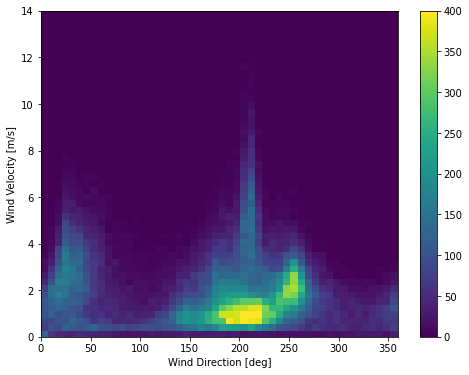

In [9]:
plt.hist2d(df['wd (deg)'], df['wv (m/s)'], bins=(50, 50), vmax=400)
plt.colorbar()
plt.xlabel('Wind Direction [deg]')
plt.ylabel('Wind Velocity [m/s]')

But this will be easier for the model to interpret if you convert the wind direction and velocity columns to a wind **vector**:

In [10]:
wv = df.pop('wv (m/s)')
max_wv = df.pop('max. wv (m/s)')

# Convert to radians.
wd_rad = df.pop('wd (deg)')*np.pi / 180

# Calculate the wind x and y components.
df['Wx'] = wv*np.cos(wd_rad)
df['Wy'] = wv*np.sin(wd_rad)

# Calculate the max wind x and y components.
df['max Wx'] = max_wv*np.cos(wd_rad)
df['max Wy'] = max_wv*np.sin(wd_rad)

The distribution of wind vectors is much simpler for the model to correctly interpret.

(-11.305513973134667, 8.24469928549079, -8.27438540335515, 7.7338312955467785)

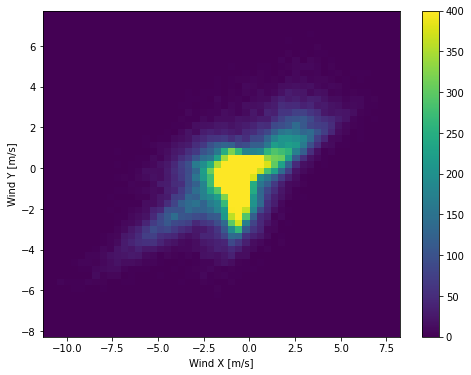

In [11]:
plt.hist2d(df['Wx'], df['Wy'], bins=(50, 50), vmax=400)
plt.colorbar()
plt.xlabel('Wind X [m/s]')
plt.ylabel('Wind Y [m/s]')
ax = plt.gca()
ax.axis('tight')

#### Time

Similarly the `Date Time` column is very useful, but not in this string form. Start by converting it to seconds:

In [12]:
timestamp_s = date_time.map(datetime.datetime.timestamp)

Similar to the wind direction the time in seconds is not a useful model input. Being weather data it has clear daily and yearly periodicity. There are many ways you could deal with periodicity.

A simple approach to convert it to a usable signal is to use `sin` and `cos` to convert the time to clear "Time of day" and "Time of year" signals:

In [13]:
day = 24*60*60
year = (365.2425)*day

df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

Text(0.5, 1.0, 'Time of day signal')

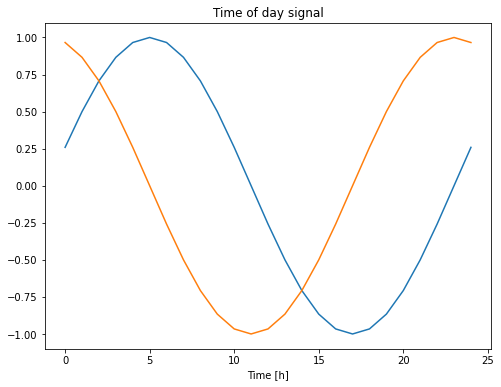

In [14]:
plt.plot(np.array(df['Day sin'])[:25])
plt.plot(np.array(df['Day cos'])[:25])
plt.xlabel('Time [h]')
plt.title('Time of day signal')

This gives the model access to the most important frequency features. In this case you knew ahead of time which frequencies were important. 

If you didn't know, you can determine which frequencies are important using an `fft`. To check our assumptions, here is the `tf.signal.rfft` of the temperature over time. Note the obvious peaks at frequencies near `1/year` and `1/day`: 

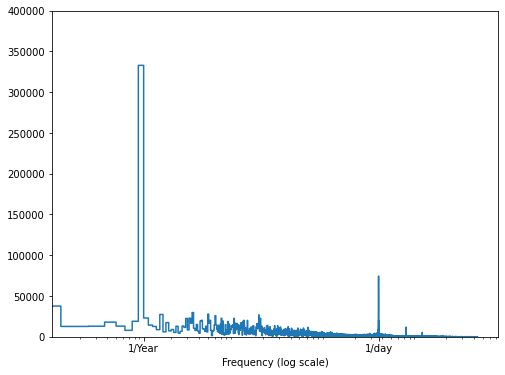

In [15]:
fft = tf.signal.rfft(df['T (degC)'])
f_per_dataset = np.arange(0, len(fft))

n_samples_h = len(df['T (degC)'])
hours_per_year = 24*365.2524
years_per_dataset = n_samples_h/(hours_per_year)

f_per_year = f_per_dataset/years_per_dataset
plt.step(f_per_year, np.abs(fft))
plt.xscale('log')
plt.ylim(0, 400000)
plt.xlim([0.1, max(plt.xlim())])
plt.xticks([1, 365.2524], labels=['1/Year', '1/day'])
_ = plt.xlabel('Frequency (log scale)')

### Split the data

We'll use a `(70%, 20%, 10%)` split for the training, validation, and test sets. Note the data is **not** being randomly shuffled before splitting. This is for two reasons.

1. It ensures that chopping the data into windows of consecutive samples is still possible.
2. It ensures that the validation/test results are more realistic, being evaluated on data collected after the model was trained.

In [16]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]

### Normalize the data

It is important to scale features before training a neural network. Normalization is a common way of doing this scaling. Subtract the mean and divide by the standard deviation of each feature.

The mean and standard deviation should only be computed using the training data so that the models have no access to the values in the validation and test sets.

It's also arguable that the model shouldn't have access to future values in the training set when training, and that this normalization should be done using moving averages. That's not the focus of this tutorial, and the validation and test sets ensure that you get (somewhat) honest metrics. So in the interest of simplicity this tutorial uses a simple average.

In [17]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

Now peek at the distribution of the features. Some features do have long tails, but there are no obvious errors like the `-9999` wind velocity value.

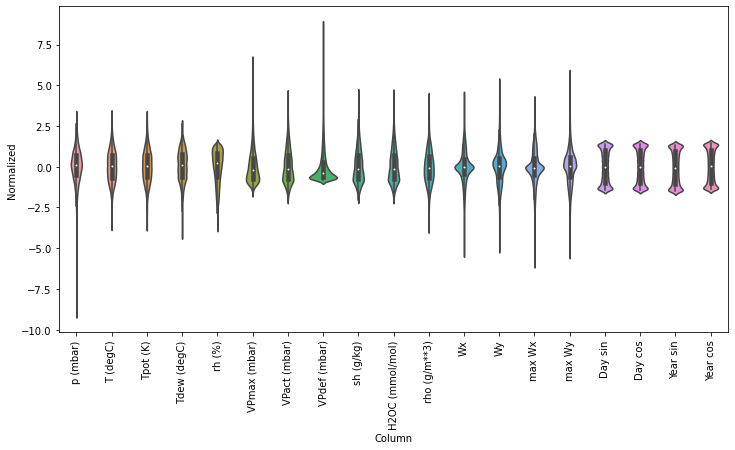

In [18]:
df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

## Data windowing

The models in this tutorial will make a set of predictions based on a window of consecutive samples from the data. 

The main features of the input windows are:

* The width (number of time steps) of the input and label windows
* The time offset between them.
* Which features are used as inputs, labels, or both. 

This tutorial builds a variety of models (including Linear, DNN, CNN and RNN models), and uses them for both:

* *Single-output*, and *multi-output* predictions.
* *Single-time-step* and *multi-time-step* predictions.

This section focuses on implementing the data windowing so that it can be reused for all of those models.


Depending on the task and type of model you may want to generate a variety of data windows. Here are some examples:

1. For example, to make a single prediction 24h into the future, given 24h of history you might define a window like this:

  ![One prediction 24h into the future.](images/raw_window_24h.png)

2. A model that makes a prediction 1h into the future, given 6h of history would need a window like this:

  ![One prediction 1h into the future.](images/raw_window_1h.png)

The rest of this section defines a `WindowGenerator` class. This class can:

1. Handle the indexes and offsets as shown in the diagrams above.
1. Split windows of features into a `(features, labels)` pairs.
2. Plot the content of the resulting windows.
3. Efficiently generate batches of these windows from the training, evaluation, and test data, using `tf.data.Dataset`s.

### 1. Indexes and offsets

Start by creating the `WindowGenerator` class. The `__init__` method includes all the necessary logic for the input and label indices.

It also takes the train, eval, and test dataframes as input. These will be converted to `tf.data.Dataset`s of windows later.

In [19]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

Here is code to create the 2 windows shown in the diagrams at the start of this section:

In [20]:
w1 = WindowGenerator(input_width=24, label_width=1, shift=24,
                     label_columns=['T (degC)'])
w1

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [47]
Label column name(s): ['T (degC)']

In [21]:
w2 = WindowGenerator(input_width=6, label_width=1, shift=1,
                     label_columns=['T (degC)'])
w2

Total window size: 7
Input indices: [0 1 2 3 4 5]
Label indices: [6]
Label column name(s): ['T (degC)']

### 2. Split
Given a list consecutive inputs, the `split_window` method will convert them to a window of inputs and a window of labels.

The example `w2`, above, will be split like this:

![The initial window is all consecutive samples, this splits it into an (inputs, labels) pairs](images/split_window.png)

This diagram doesn't show the `features` axis of the data, but this `split_window` function also handles the `label_columns` so it can be used for both the single output and multi-output examples.

In [22]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

Try it out:

In [23]:
# Stack three slices, the length of the total window:
example_window = tf.stack([np.array(train_df[:w2.total_window_size]),
                           np.array(train_df[100:100+w2.total_window_size]),
                           np.array(train_df[200:200+w2.total_window_size])])


example_inputs, example_labels = w2.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 7, 19)
Inputs shape: (3, 6, 19)
labels shape: (3, 1, 1)


Typically data in TensorFlow is packed into arrays where the outermost index is across examples (the "batch" dimension). The middle indices are the "time" or "space" (width, height) dimension(s). The innermost indices are the features.

The code above took a batch of 3, 7-timestep windows, with 19 features at each time step. It split them into a batch of 6-timestep, 19 feature inputs, and a 1-timestep 1-feature label. The label only has one feature because the `WindowGenerator` was initialized with `label_columns=['T (degC)']`. Initially this tutorial will build models that predict single output labels.

### 3. Plot

Here is a plot method that allows a simple visualization of the split window:

In [24]:
w2.example = example_inputs, example_labels

In [25]:
def plot(self, model=None, plot_col='T (degC)', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(3, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')

WindowGenerator.plot = plot

This plot aligns inputs, labels, and (later) predictions based on the time that the item refers to:

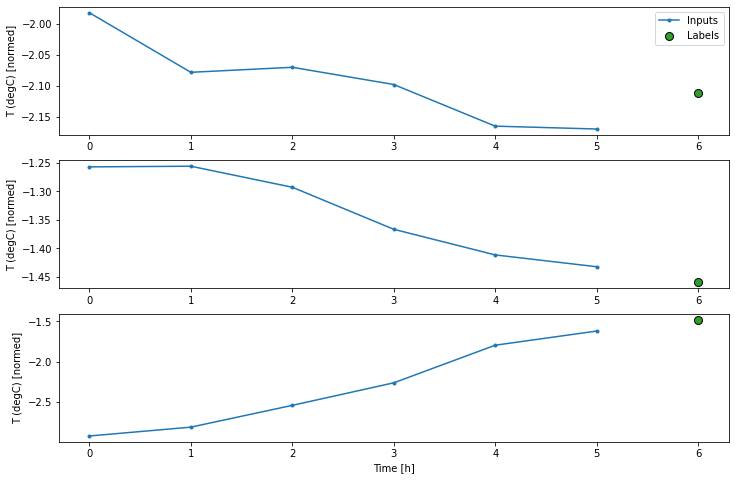

In [26]:
w2.plot()

You can plot the other columns, but the example window `w2` configuration only has labels for the `T (degC)` column.

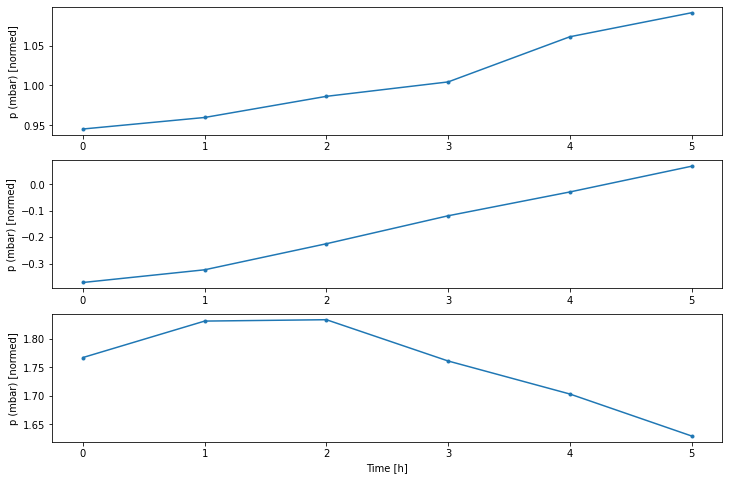

In [27]:
w2.plot(plot_col='p (mbar)')

### 4. Create `tf.data.Dataset`s

Finally this `make_dataset` method will take a time series `DataFrame` and convert it to a `tf.data.Dataset` of `(input_window, label_window)` pairs using the `preprocessing.timeseries_dataset_from_array` function.

In [28]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

The `WindowGenerator` object holds training, validation and test data. Add properties for accessing them as `tf.data.Datasets` using the above `make_dataset` method. Also add a standard example batch for easy access and plotting:

In [29]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

Now the `WindowGenerator` object gives you access to the `tf.data.Dataset` objects, so you can easily iterate over the data.

The `Dataset.element_spec` property tells you the structure, `dtypes` and shapes of the dataset elements.

In [30]:
# Each element is an (inputs, label) pair
w2.train.element_spec

(TensorSpec(shape=(None, 6, 19), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))

Iterating over a `Dataset` yields concrete batches:

In [31]:
for example_inputs, example_labels in w2.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 6, 19)
Labels shape (batch, time, features): (32, 1, 1)


## Single step models

The simplest model you can build on this sort of data is one that predicts a single feature's value, 1 timestep (1h) in the future based only on the current conditions.

So start by building models to predict the `T (degC)` value 1h into the future.

![Predict the next time step](images/narrow_window.png)

Configure a `WindowGenerator` object to produce these single-step `(input, label)` pairs:

In [32]:
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    label_columns=['T (degC)'])
single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['T (degC)']

The `window` object creates `tf.data.Datasets` from the training, validation, and test sets, allowing you to easily iterate over batches of data.


In [33]:
for example_inputs, example_labels in single_step_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 1, 19)
Labels shape (batch, time, features): (32, 1, 1)


### Baseline

Before building a trainable model it would be good to have a performance baseline as a point for comparison with the later more complicated models.

This first task is to predict temperature 1h in the future given the current value of all features. The current values include the current temperature. 

So start with a model that just returns the current temperature as the prediction, predicting "No change". This is a reasonable baseline since temperature changes slowly. Of course, this baseline will work less well if you make a prediction further in the future.

![Send the input to the output](images/baseline.png)

In [34]:
class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]

Instantiate and evaluate this model:

In [35]:
baseline = Baseline(label_index=column_indices['T (degC)'])

baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0)

  1/439 [..............................] - ETA: 1:26 - loss: 0.0135 - mean_absolute_error: 0.0914

 23/439 [>.............................] - ETA: 0s - loss: 0.0144 - mean_absolute_error: 0.0821  

 45/439 [==>...........................] - ETA: 0s - loss: 0.0139 - mean_absolute_error: 0.0807

 68/439 [===>..........................] - ETA: 0s - loss: 0.0136 - mean_absolute_error: 0.0800

 91/439 [=====>........................] - ETA: 0s - loss: 0.0133 - mean_absolute_error: 0.0794

113/439 [======>.......................] - ETA: 0s - loss: 0.0131 - mean_absolute_error: 0.0790

136/439 [========>.....................] - ETA: 0s - loss: 0.0130 - mean_absolute_error: 0.0789

159/439 [=========>....................] - ETA: 0s - loss: 0.0130 - mean_absolute_error: 0.0788

181/439 [===========>..................] - ETA: 0s - loss: 0.0130 - mean_absolute_error: 0.0789

203/439 [============>.................] - ETA: 0s - loss: 0.0130 - mean_absolute_error: 0.0789

227/439 [==============>...............] - ETA: 0s - loss: 0.0129 - mean_absolute_error: 0.0789

250/439 [================>.............] - ETA: 0s - loss: 0.0129 - mean_absolute_error: 0.0788

273/439 [=================>............] - ETA: 0s - loss: 0.0129 - mean_absolute_error: 0.0787

297/439 [===================>..........] - ETA: 0s - loss: 0.0129 - mean_absolute_error: 0.0787

319/439 [====================>.........] - ETA: 0s - loss: 0.0129 - mean_absolute_error: 0.0787

342/439 [======================>.......] - ETA: 0s - loss: 0.0129 - mean_absolute_error: 0.0787

366/439 [========================>.....] - ETA: 0s - loss: 0.0129 - mean_absolute_error: 0.0787

389/439 [=========================>....] - ETA: 0s - loss: 0.0129 - mean_absolute_error: 0.0787

413/439 [===========================>..] - ETA: 0s - loss: 0.0129 - mean_absolute_error: 0.0787

437/439 [============================>.] - ETA: 0s - loss: 0.0129 - mean_absolute_error: 0.0787

439/439 [==============================] - 1s 2ms/step - loss: 0.0129 - mean_absolute_error: 0.0787


That printed some performance metrics, but those don't give you a feeling for how well the model is doing.

The `WindowGenerator` has a plot method, but the plots won't be very interesting with only a single sample. So, create a wider `WindowGenerator` that generates windows 24h of consecutive inputs and labels at a time. 

The `wide_window` doesn't change the way the model operates. The model still makes predictions 1h into the future based on a single input time step. Here the `time` axis acts like the `batch` axis: Each prediction is made independently with no interaction between time steps.

In [36]:
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1,
    label_columns=['T (degC)'])

wide_window

Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Label column name(s): ['T (degC)']

This expanded window can be passed directly to the same `baseline` model without any code changes. This is possible because the inputs and labels have the same number of timesteps, and the baseline just forwards the input to the output:

  ![One prediction 1h into the future, ever hour.](images/last_window.png)

In [37]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)

Input shape: (32, 24, 19)
Output shape: (32, 24, 1)


Plotting the baseline model's predictions you can see that it is simply the labels, shifted right by 1h.

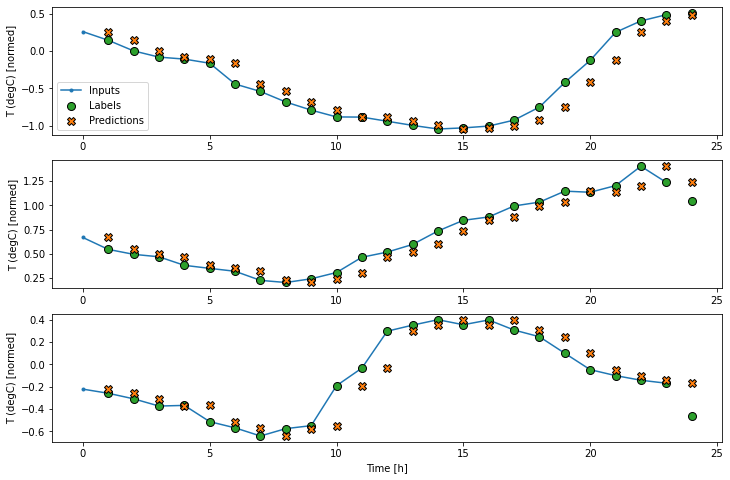

In [38]:
wide_window.plot(baseline)

In the above plots of three examples the single step model is run over the course of 24h. This deserves some explanation:

* The blue "Inputs" line shows the input temperature at each time step. The model recieves all features, this plot only shows the temperature.
* The green "Labels" dots show the target prediction value. These dots are shown at the prediction time, not the input time. That is why the range of labels is shifted 1 step relative to the inputs.
* The orange "Predictions" crosses are the model's prediction's for each output time step. If the model were predicting perfectly the predictions would land directly on the "labels".

### Linear model

The simplest **trainable** model you can apply to this task is to insert linear transformation between the input and output. In this case the output from a time step only depends on that step:

![A single step prediction](images/narrow_window.png)

A `layers.Dense` with no `activation` set is a linear model. The layer only transforms the last axis of the data from `(batch, time, inputs)` to `(batch, time, units)`, it is applied independently to every item across the `batch` and `time` axes.

In [39]:
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1)
])

In [40]:
print('Input shape:', single_step_window.example[0].shape)
print('Output shape:', linear(single_step_window.example[0]).shape)

Input shape: (32, 1, 19)


Output shape: (32, 1, 1)


This tutorial trains many models, so package the training procedure into a function:

In [41]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

Train the model and evaluate its performance:

In [42]:
history = compile_and_fit(linear, single_step_window)

val_performance['Linear'] = linear.evaluate(single_step_window.val)
performance['Linear'] = linear.evaluate(single_step_window.test, verbose=0)

Epoch 1/20


   1/1534 [..............................] - ETA: 8:44 - loss: 1.0631 - mean_absolute_error: 0.8536

  19/1534 [..............................] - ETA: 4s - loss: 0.8877 - mean_absolute_error: 0.7574  

  37/1534 [..............................] - ETA: 4s - loss: 0.8458 - mean_absolute_error: 0.7330

  56/1534 [>.............................] - ETA: 4s - loss: 0.8022 - mean_absolute_error: 0.7091

  75/1534 [>.............................] - ETA: 4s - loss: 0.7654 - mean_absolute_error: 0.6892

  93/1534 [>.............................] - ETA: 4s - loss: 0.7329 - mean_absolute_error: 0.6715

 112/1534 [=>............................] - ETA: 3s - loss: 0.7010 - mean_absolute_error: 0.6538

 131/1534 [=>............................] - ETA: 3s - loss: 0.6720 - mean_absolute_error: 0.6375

 150/1534 [=>............................] - ETA: 3s - loss: 0.6457 - mean_absolute_error: 0.6226

 169/1534 [==>...........................] - ETA: 3s - loss: 0.6218 - mean_absolute_error: 0.6087

 188/1534 [==>...........................] - ETA: 3s - loss: 0.5999 - mean_absolute_error: 0.5959

 207/1534 [===>..........................] - ETA: 3s - loss: 0.5800 - mean_absolute_error: 0.5840

 226/1534 [===>..........................] - ETA: 3s - loss: 0.5616 - mean_absolute_error: 0.5728

 246/1534 [===>..........................] - ETA: 3s - loss: 0.5438 - mean_absolute_error: 0.5618

 265/1534 [====>.........................] - ETA: 3s - loss: 0.5281 - mean_absolute_error: 0.5520

 284/1534 [====>.........................] - ETA: 3s - loss: 0.5135 - mean_absolute_error: 0.5426

 303/1534 [====>.........................] - ETA: 3s - loss: 0.4998 - mean_absolute_error: 0.5338

 321/1534 [=====>........................] - ETA: 3s - loss: 0.4876 - mean_absolute_error: 0.5257

 340/1534 [=====>........................] - ETA: 3s - loss: 0.4756 - mean_absolute_error: 0.5177

 359/1534 [======>.......................] - ETA: 3s - loss: 0.4642 - mean_absolute_error: 0.5099

 377/1534 [======>.......................] - ETA: 3s - loss: 0.4539 - mean_absolute_error: 0.5029

 396/1534 [======>.......................] - ETA: 3s - loss: 0.4437 - mean_absolute_error: 0.4957

 416/1534 [=======>......................] - ETA: 3s - loss: 0.4335 - mean_absolute_error: 0.4884

 434/1534 [=======>......................] - ETA: 2s - loss: 0.4248 - mean_absolute_error: 0.4821

 452/1534 [=======>......................] - ETA: 2s - loss: 0.4165 - mean_absolute_error: 0.4760

 471/1534 [========>.....................] - ETA: 2s - loss: 0.4081 - mean_absolute_error: 0.4699

 489/1534 [========>.....................] - ETA: 2s - loss: 0.4005 - mean_absolute_error: 0.4642

 508/1534 [========>.....................] - ETA: 2s - loss: 0.3929 - mean_absolute_error: 0.4584

 527/1534 [=========>....................] - ETA: 2s - loss: 0.3855 - mean_absolute_error: 0.4528

 546/1534 [=========>....................] - ETA: 2s - loss: 0.3785 - mean_absolute_error: 0.4474

 565/1534 [==========>...................] - ETA: 2s - loss: 0.3718 - mean_absolute_error: 0.4421

 584/1534 [==========>...................] - ETA: 2s - loss: 0.3654 - mean_absolute_error: 0.4370

 603/1534 [==========>...................] - ETA: 2s - loss: 0.3592 - mean_absolute_error: 0.4320

 622/1534 [===========>..................] - ETA: 2s - loss: 0.3533 - mean_absolute_error: 0.4272

 641/1534 [===========>..................] - ETA: 2s - loss: 0.3476 - mean_absolute_error: 0.4226

 661/1534 [===========>..................] - ETA: 2s - loss: 0.3418 - mean_absolute_error: 0.4178

 680/1534 [============>.................] - ETA: 2s - loss: 0.3365 - mean_absolute_error: 0.4134

 699/1534 [============>.................] - ETA: 2s - loss: 0.3314 - mean_absolute_error: 0.4091

 718/1534 [=============>................] - ETA: 2s - loss: 0.3265 - mean_absolute_error: 0.4050

 736/1534 [=============>................] - ETA: 2s - loss: 0.3220 - mean_absolute_error: 0.4012

 755/1534 [=============>................] - ETA: 2s - loss: 0.3174 - mean_absolute_error: 0.3972

 775/1534 [==============>...............] - ETA: 2s - loss: 0.3127 - mean_absolute_error: 0.3932

 793/1534 [==============>...............] - ETA: 2s - loss: 0.3086 - mean_absolute_error: 0.3897

 811/1534 [==============>...............] - ETA: 1s - loss: 0.3047 - mean_absolute_error: 0.3862

 828/1534 [===============>..............] - ETA: 1s - loss: 0.3010 - mean_absolute_error: 0.3831

 846/1534 [===============>..............] - ETA: 1s - loss: 0.2973 - mean_absolute_error: 0.3798

 864/1534 [===============>..............] - ETA: 1s - loss: 0.2937 - mean_absolute_error: 0.3766

 884/1534 [================>.............] - ETA: 1s - loss: 0.2898 - mean_absolute_error: 0.3731

 902/1534 [================>.............] - ETA: 1s - loss: 0.2864 - mean_absolute_error: 0.3701

 921/1534 [=================>............] - ETA: 1s - loss: 0.2829 - mean_absolute_error: 0.3669

 941/1534 [=================>............] - ETA: 1s - loss: 0.2793 - mean_absolute_error: 0.3637

 959/1534 [=================>............] - ETA: 1s - loss: 0.2762 - mean_absolute_error: 0.3609

 977/1534 [==================>...........] - ETA: 1s - loss: 0.2731 - mean_absolute_error: 0.3581

 996/1534 [==================>...........] - ETA: 1s - loss: 0.2700 - mean_absolute_error: 0.3552

1014/1534 [==================>...........] - ETA: 1s - loss: 0.2671 - mean_absolute_error: 0.3526

1032/1534 [===================>..........] - ETA: 1s - loss: 0.2643 - mean_absolute_error: 0.3500

1051/1534 [===================>..........] - ETA: 1s - loss: 0.2614 - mean_absolute_error: 0.3473

1069/1534 [===================>..........] - ETA: 1s - loss: 0.2587 - mean_absolute_error: 0.3448

1088/1534 [====================>.........] - ETA: 1s - loss: 0.2560 - mean_absolute_error: 0.3422

1106/1534 [====================>.........] - ETA: 1s - loss: 0.2534 - mean_absolute_error: 0.3398

1124/1534 [====================>.........] - ETA: 1s - loss: 0.2509 - mean_absolute_error: 0.3375

1142/1534 [=====================>........] - ETA: 1s - loss: 0.2485 - mean_absolute_error: 0.3352

1160/1534 [=====================>........] - ETA: 1s - loss: 0.2461 - mean_absolute_error: 0.3330

1178/1534 [======================>.......] - ETA: 0s - loss: 0.2438 - mean_absolute_error: 0.3308

1195/1534 [======================>.......] - ETA: 0s - loss: 0.2417 - mean_absolute_error: 0.3287

1213/1534 [======================>.......] - ETA: 0s - loss: 0.2394 - mean_absolute_error: 0.3266

1232/1534 [=======================>......] - ETA: 0s - loss: 0.2371 - mean_absolute_error: 0.3244

1251/1534 [=======================>......] - ETA: 0s - loss: 0.2349 - mean_absolute_error: 0.3223

1270/1534 [=======================>......] - ETA: 0s - loss: 0.2327 - mean_absolute_error: 0.3201

1289/1534 [========================>.....] - ETA: 0s - loss: 0.2306 - mean_absolute_error: 0.3181

1308/1534 [========================>.....] - ETA: 0s - loss: 0.2285 - mean_absolute_error: 0.3160

1327/1534 [========================>.....] - ETA: 0s - loss: 0.2264 - mean_absolute_error: 0.3140

1346/1534 [=========================>....] - ETA: 0s - loss: 0.2244 - mean_absolute_error: 0.3121

1365/1534 [=========================>....] - ETA: 0s - loss: 0.2224 - mean_absolute_error: 0.3101

1384/1534 [==========================>...] - ETA: 0s - loss: 0.2205 - mean_absolute_error: 0.3083

1403/1534 [==========================>...] - ETA: 0s - loss: 0.2186 - mean_absolute_error: 0.3064

1421/1534 [==========================>...] - ETA: 0s - loss: 0.2168 - mean_absolute_error: 0.3047

1440/1534 [===========================>..] - ETA: 0s - loss: 0.2150 - mean_absolute_error: 0.3029

1460/1534 [===========================>..] - ETA: 0s - loss: 0.2131 - mean_absolute_error: 0.3010

1478/1534 [===========================>..] - ETA: 0s - loss: 0.2115 - mean_absolute_error: 0.2994

1497/1534 [============================>.] - ETA: 0s - loss: 0.2098 - mean_absolute_error: 0.2977

1516/1534 [============================>.] - ETA: 0s - loss: 0.2081 - mean_absolute_error: 0.2960

1534/1534 [==============================] - 6s 4ms/step - loss: 0.2064 - mean_absolute_error: 0.2944 - val_loss: 0.0101 - val_mean_absolute_error: 0.0752


Epoch 2/20
   1/1534 [..............................] - ETA: 29s - loss: 0.0075 - mean_absolute_error: 0.0657

  20/1534 [..............................] - ETA: 4s - loss: 0.0111 - mean_absolute_error: 0.0757 

  39/1534 [..............................] - ETA: 3s - loss: 0.0110 - mean_absolute_error: 0.0759

  58/1534 [>.............................] - ETA: 3s - loss: 0.0108 - mean_absolute_error: 0.0757

  77/1534 [>.............................] - ETA: 3s - loss: 0.0106 - mean_absolute_error: 0.0755

  97/1534 [>.............................] - ETA: 3s - loss: 0.0105 - mean_absolute_error: 0.0753

 115/1534 [=>............................] - ETA: 3s - loss: 0.0104 - mean_absolute_error: 0.0752

 135/1534 [=>............................] - ETA: 3s - loss: 0.0103 - mean_absolute_error: 0.0751

 154/1534 [==>...........................] - ETA: 3s - loss: 0.0103 - mean_absolute_error: 0.0750

 173/1534 [==>...........................] - ETA: 3s - loss: 0.0103 - mean_absolute_error: 0.0749

 192/1534 [==>...........................] - ETA: 3s - loss: 0.0103 - mean_absolute_error: 0.0748

 211/1534 [===>..........................] - ETA: 3s - loss: 0.0102 - mean_absolute_error: 0.0748

 231/1534 [===>..........................] - ETA: 3s - loss: 0.0102 - mean_absolute_error: 0.0747

 250/1534 [===>..........................] - ETA: 3s - loss: 0.0102 - mean_absolute_error: 0.0747

 266/1534 [====>.........................] - ETA: 3s - loss: 0.0102 - mean_absolute_error: 0.0747

 285/1534 [====>.........................] - ETA: 3s - loss: 0.0102 - mean_absolute_error: 0.0747

 304/1534 [====>.........................] - ETA: 3s - loss: 0.0102 - mean_absolute_error: 0.0747

 323/1534 [=====>........................] - ETA: 3s - loss: 0.0102 - mean_absolute_error: 0.0746

 342/1534 [=====>........................] - ETA: 3s - loss: 0.0102 - mean_absolute_error: 0.0746

 362/1534 [======>.......................] - ETA: 3s - loss: 0.0102 - mean_absolute_error: 0.0746

 381/1534 [======>.......................] - ETA: 3s - loss: 0.0102 - mean_absolute_error: 0.0746

 401/1534 [======>.......................] - ETA: 3s - loss: 0.0102 - mean_absolute_error: 0.0746

 420/1534 [=======>......................] - ETA: 2s - loss: 0.0102 - mean_absolute_error: 0.0746

 439/1534 [=======>......................] - ETA: 2s - loss: 0.0102 - mean_absolute_error: 0.0745

 458/1534 [=======>......................] - ETA: 2s - loss: 0.0102 - mean_absolute_error: 0.0745

 477/1534 [========>.....................] - ETA: 2s - loss: 0.0102 - mean_absolute_error: 0.0745

 497/1534 [========>.....................] - ETA: 2s - loss: 0.0102 - mean_absolute_error: 0.0745

 516/1534 [=========>....................] - ETA: 2s - loss: 0.0102 - mean_absolute_error: 0.0745

 535/1534 [=========>....................] - ETA: 2s - loss: 0.0102 - mean_absolute_error: 0.0745

 554/1534 [=========>....................] - ETA: 2s - loss: 0.0102 - mean_absolute_error: 0.0744

 574/1534 [==========>...................] - ETA: 2s - loss: 0.0102 - mean_absolute_error: 0.0744

 593/1534 [==========>...................] - ETA: 2s - loss: 0.0102 - mean_absolute_error: 0.0744

 613/1534 [==========>...................] - ETA: 2s - loss: 0.0102 - mean_absolute_error: 0.0744

 632/1534 [===========>..................] - ETA: 2s - loss: 0.0102 - mean_absolute_error: 0.0744

 652/1534 [===========>..................] - ETA: 2s - loss: 0.0102 - mean_absolute_error: 0.0743

 671/1534 [============>.................] - ETA: 2s - loss: 0.0102 - mean_absolute_error: 0.0743

 691/1534 [============>.................] - ETA: 2s - loss: 0.0101 - mean_absolute_error: 0.0743

 710/1534 [============>.................] - ETA: 2s - loss: 0.0101 - mean_absolute_error: 0.0743

 730/1534 [=============>................] - ETA: 2s - loss: 0.0101 - mean_absolute_error: 0.0742

 749/1534 [=============>................] - ETA: 2s - loss: 0.0101 - mean_absolute_error: 0.0742

 768/1534 [==============>...............] - ETA: 2s - loss: 0.0101 - mean_absolute_error: 0.0742

 787/1534 [==============>...............] - ETA: 1s - loss: 0.0101 - mean_absolute_error: 0.0742

 806/1534 [==============>...............] - ETA: 1s - loss: 0.0101 - mean_absolute_error: 0.0742

 825/1534 [===============>..............] - ETA: 1s - loss: 0.0101 - mean_absolute_error: 0.0742

 844/1534 [===============>..............] - ETA: 1s - loss: 0.0101 - mean_absolute_error: 0.0741

 864/1534 [===============>..............] - ETA: 1s - loss: 0.0101 - mean_absolute_error: 0.0741

 883/1534 [================>.............] - ETA: 1s - loss: 0.0101 - mean_absolute_error: 0.0741

 903/1534 [================>.............] - ETA: 1s - loss: 0.0101 - mean_absolute_error: 0.0741

 922/1534 [=================>............] - ETA: 1s - loss: 0.0101 - mean_absolute_error: 0.0741

 941/1534 [=================>............] - ETA: 1s - loss: 0.0101 - mean_absolute_error: 0.0740

 960/1534 [=================>............] - ETA: 1s - loss: 0.0101 - mean_absolute_error: 0.0740

 979/1534 [==================>...........] - ETA: 1s - loss: 0.0101 - mean_absolute_error: 0.0740

 998/1534 [==================>...........] - ETA: 1s - loss: 0.0101 - mean_absolute_error: 0.0740

1017/1534 [==================>...........] - ETA: 1s - loss: 0.0101 - mean_absolute_error: 0.0740

1036/1534 [===================>..........] - ETA: 1s - loss: 0.0101 - mean_absolute_error: 0.0739

1056/1534 [===================>..........] - ETA: 1s - loss: 0.0101 - mean_absolute_error: 0.0739

1076/1534 [====================>.........] - ETA: 1s - loss: 0.0101 - mean_absolute_error: 0.0739

1096/1534 [====================>.........] - ETA: 1s - loss: 0.0101 - mean_absolute_error: 0.0739

1116/1534 [====================>.........] - ETA: 1s - loss: 0.0101 - mean_absolute_error: 0.0738

1135/1534 [=====================>........] - ETA: 1s - loss: 0.0100 - mean_absolute_error: 0.0738

1154/1534 [=====================>........] - ETA: 1s - loss: 0.0100 - mean_absolute_error: 0.0738

1173/1534 [=====================>........] - ETA: 0s - loss: 0.0100 - mean_absolute_error: 0.0738

1192/1534 [======================>.......] - ETA: 0s - loss: 0.0100 - mean_absolute_error: 0.0738

1212/1534 [======================>.......] - ETA: 0s - loss: 0.0100 - mean_absolute_error: 0.0738

1231/1534 [=======================>......] - ETA: 0s - loss: 0.0100 - mean_absolute_error: 0.0737

1250/1534 [=======================>......] - ETA: 0s - loss: 0.0100 - mean_absolute_error: 0.0737

1269/1534 [=======================>......] - ETA: 0s - loss: 0.0100 - mean_absolute_error: 0.0737

1288/1534 [========================>.....] - ETA: 0s - loss: 0.0100 - mean_absolute_error: 0.0737

1308/1534 [========================>.....] - ETA: 0s - loss: 0.0100 - mean_absolute_error: 0.0736

1327/1534 [========================>.....] - ETA: 0s - loss: 0.0100 - mean_absolute_error: 0.0736

1347/1534 [=========================>....] - ETA: 0s - loss: 0.0100 - mean_absolute_error: 0.0736

1367/1534 [=========================>....] - ETA: 0s - loss: 0.0100 - mean_absolute_error: 0.0736

1383/1534 [==========================>...] - ETA: 0s - loss: 0.0100 - mean_absolute_error: 0.0736

1402/1534 [==========================>...] - ETA: 0s - loss: 0.0100 - mean_absolute_error: 0.0735

1421/1534 [==========================>...] - ETA: 0s - loss: 0.0100 - mean_absolute_error: 0.0735

1440/1534 [===========================>..] - ETA: 0s - loss: 0.0100 - mean_absolute_error: 0.0735

1458/1534 [===========================>..] - ETA: 0s - loss: 0.0100 - mean_absolute_error: 0.0735

1477/1534 [===========================>..] - ETA: 0s - loss: 0.0100 - mean_absolute_error: 0.0734

1496/1534 [============================>.] - ETA: 0s - loss: 0.0099 - mean_absolute_error: 0.0734

1516/1534 [============================>.] - ETA: 0s - loss: 0.0099 - mean_absolute_error: 0.0734

1534/1534 [==============================] - 5s 3ms/step - loss: 0.0099 - mean_absolute_error: 0.0734 - val_loss: 0.0089 - val_mean_absolute_error: 0.0708


Epoch 3/20
   1/1534 [..............................] - ETA: 28s - loss: 0.0112 - mean_absolute_error: 0.0812

  20/1534 [..............................] - ETA: 4s - loss: 0.0104 - mean_absolute_error: 0.0737 

  39/1534 [..............................] - ETA: 4s - loss: 0.0098 - mean_absolute_error: 0.0725

  58/1534 [>.............................] - ETA: 3s - loss: 0.0095 - mean_absolute_error: 0.0718

  78/1534 [>.............................] - ETA: 3s - loss: 0.0093 - mean_absolute_error: 0.0712

  97/1534 [>.............................] - ETA: 3s - loss: 0.0091 - mean_absolute_error: 0.0708

 117/1534 [=>............................] - ETA: 3s - loss: 0.0090 - mean_absolute_error: 0.0704

 136/1534 [=>............................] - ETA: 3s - loss: 0.0090 - mean_absolute_error: 0.0703

 156/1534 [==>...........................] - ETA: 3s - loss: 0.0090 - mean_absolute_error: 0.0701

 175/1534 [==>...........................] - ETA: 3s - loss: 0.0089 - mean_absolute_error: 0.0700

 195/1534 [==>...........................] - ETA: 3s - loss: 0.0089 - mean_absolute_error: 0.0699

 214/1534 [===>..........................] - ETA: 3s - loss: 0.0089 - mean_absolute_error: 0.0699

 233/1534 [===>..........................] - ETA: 3s - loss: 0.0090 - mean_absolute_error: 0.0699

 253/1534 [===>..........................] - ETA: 3s - loss: 0.0090 - mean_absolute_error: 0.0699

 272/1534 [====>.........................] - ETA: 3s - loss: 0.0090 - mean_absolute_error: 0.0699

 291/1534 [====>.........................] - ETA: 3s - loss: 0.0090 - mean_absolute_error: 0.0699

 310/1534 [=====>........................] - ETA: 3s - loss: 0.0090 - mean_absolute_error: 0.0699

 329/1534 [=====>........................] - ETA: 3s - loss: 0.0090 - mean_absolute_error: 0.0699

 348/1534 [=====>........................] - ETA: 3s - loss: 0.0090 - mean_absolute_error: 0.0699

 367/1534 [======>.......................] - ETA: 3s - loss: 0.0090 - mean_absolute_error: 0.0699

 386/1534 [======>.......................] - ETA: 3s - loss: 0.0090 - mean_absolute_error: 0.0699

 405/1534 [======>.......................] - ETA: 2s - loss: 0.0090 - mean_absolute_error: 0.0699

 424/1534 [=======>......................] - ETA: 2s - loss: 0.0090 - mean_absolute_error: 0.0699

 444/1534 [=======>......................] - ETA: 2s - loss: 0.0090 - mean_absolute_error: 0.0700

 463/1534 [========>.....................] - ETA: 2s - loss: 0.0090 - mean_absolute_error: 0.0700

 482/1534 [========>.....................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0700

 499/1534 [========>.....................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0700

 518/1534 [=========>....................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0700

 536/1534 [=========>....................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0700

 555/1534 [=========>....................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0700

 574/1534 [==========>...................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0700

 593/1534 [==========>...................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0700

 613/1534 [==========>...................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0700

 633/1534 [===========>..................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0700

 653/1534 [===========>..................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0700

 673/1534 [============>.................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0700

 693/1534 [============>.................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0700

 712/1534 [============>.................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0700

 731/1534 [=============>................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0700

 750/1534 [=============>................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0700

 770/1534 [==============>...............] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0700

 789/1534 [==============>...............] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0700

 809/1534 [==============>...............] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0700

 828/1534 [===============>..............] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0700

 848/1534 [===============>..............] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0701

 868/1534 [===============>..............] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0701

 887/1534 [================>.............] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0701

 906/1534 [================>.............] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0701

 925/1534 [=================>............] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0701

 944/1534 [=================>............] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0701

 963/1534 [=================>............] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0701

 983/1534 [==================>...........] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0701

1002/1534 [==================>...........] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0701

1021/1534 [==================>...........] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0701

1039/1534 [===================>..........] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0701

1058/1534 [===================>..........] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0701

1077/1534 [====================>.........] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0701

1096/1534 [====================>.........] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0701

1115/1534 [====================>.........] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0701

1134/1534 [=====================>........] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0701

1153/1534 [=====================>........] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0701

1172/1534 [=====================>........] - ETA: 0s - loss: 0.0092 - mean_absolute_error: 0.0701

1191/1534 [======================>.......] - ETA: 0s - loss: 0.0092 - mean_absolute_error: 0.0701

1210/1534 [======================>.......] - ETA: 0s - loss: 0.0092 - mean_absolute_error: 0.0701

1230/1534 [=======================>......] - ETA: 0s - loss: 0.0092 - mean_absolute_error: 0.0701

1250/1534 [=======================>......] - ETA: 0s - loss: 0.0092 - mean_absolute_error: 0.0701

1270/1534 [=======================>......] - ETA: 0s - loss: 0.0092 - mean_absolute_error: 0.0701

1289/1534 [========================>.....] - ETA: 0s - loss: 0.0092 - mean_absolute_error: 0.0701

1308/1534 [========================>.....] - ETA: 0s - loss: 0.0092 - mean_absolute_error: 0.0701

1327/1534 [========================>.....] - ETA: 0s - loss: 0.0092 - mean_absolute_error: 0.0701

1346/1534 [=========================>....] - ETA: 0s - loss: 0.0092 - mean_absolute_error: 0.0701

1365/1534 [=========================>....] - ETA: 0s - loss: 0.0092 - mean_absolute_error: 0.0701

1384/1534 [==========================>...] - ETA: 0s - loss: 0.0092 - mean_absolute_error: 0.0700

1404/1534 [==========================>...] - ETA: 0s - loss: 0.0092 - mean_absolute_error: 0.0700

1423/1534 [==========================>...] - ETA: 0s - loss: 0.0092 - mean_absolute_error: 0.0700

1442/1534 [===========================>..] - ETA: 0s - loss: 0.0092 - mean_absolute_error: 0.0700

1461/1534 [===========================>..] - ETA: 0s - loss: 0.0092 - mean_absolute_error: 0.0700

1480/1534 [===========================>..] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0700

1499/1534 [============================>.] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0700

1519/1534 [============================>.] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0700

1534/1534 [==============================] - 5s 3ms/step - loss: 0.0091 - mean_absolute_error: 0.0700 - val_loss: 0.0088 - val_mean_absolute_error: 0.0702


Epoch 4/20
   1/1534 [..............................] - ETA: 30s - loss: 0.0055 - mean_absolute_error: 0.0626

  20/1534 [..............................] - ETA: 4s - loss: 0.0083 - mean_absolute_error: 0.0680 

  39/1534 [..............................] - ETA: 3s - loss: 0.0086 - mean_absolute_error: 0.0696

  58/1534 [>.............................] - ETA: 3s - loss: 0.0087 - mean_absolute_error: 0.0698

  78/1534 [>.............................] - ETA: 3s - loss: 0.0087 - mean_absolute_error: 0.0698

  96/1534 [>.............................] - ETA: 3s - loss: 0.0087 - mean_absolute_error: 0.0697

 115/1534 [=>............................] - ETA: 3s - loss: 0.0086 - mean_absolute_error: 0.0695

 132/1534 [=>............................] - ETA: 3s - loss: 0.0086 - mean_absolute_error: 0.0694

 149/1534 [=>............................] - ETA: 3s - loss: 0.0087 - mean_absolute_error: 0.0694

 167/1534 [==>...........................] - ETA: 3s - loss: 0.0087 - mean_absolute_error: 0.0693

 184/1534 [==>...........................] - ETA: 3s - loss: 0.0087 - mean_absolute_error: 0.0693

 201/1534 [==>...........................] - ETA: 3s - loss: 0.0087 - mean_absolute_error: 0.0693

 218/1534 [===>..........................] - ETA: 3s - loss: 0.0087 - mean_absolute_error: 0.0693

 235/1534 [===>..........................] - ETA: 3s - loss: 0.0087 - mean_absolute_error: 0.0693

 252/1534 [===>..........................] - ETA: 3s - loss: 0.0088 - mean_absolute_error: 0.0694

 268/1534 [====>.........................] - ETA: 3s - loss: 0.0088 - mean_absolute_error: 0.0694

 284/1534 [====>.........................] - ETA: 3s - loss: 0.0088 - mean_absolute_error: 0.0694

 300/1534 [====>.........................] - ETA: 3s - loss: 0.0088 - mean_absolute_error: 0.0695

 316/1534 [=====>........................] - ETA: 3s - loss: 0.0088 - mean_absolute_error: 0.0695

 332/1534 [=====>........................] - ETA: 3s - loss: 0.0088 - mean_absolute_error: 0.0695

 348/1534 [=====>........................] - ETA: 3s - loss: 0.0089 - mean_absolute_error: 0.0695

 364/1534 [======>.......................] - ETA: 3s - loss: 0.0089 - mean_absolute_error: 0.0695

 379/1534 [======>.......................] - ETA: 3s - loss: 0.0089 - mean_absolute_error: 0.0696

 395/1534 [======>.......................] - ETA: 3s - loss: 0.0089 - mean_absolute_error: 0.0696

 411/1534 [=======>......................] - ETA: 3s - loss: 0.0089 - mean_absolute_error: 0.0696

 427/1534 [=======>......................] - ETA: 3s - loss: 0.0089 - mean_absolute_error: 0.0696

 443/1534 [=======>......................] - ETA: 3s - loss: 0.0089 - mean_absolute_error: 0.0696

 460/1534 [=======>......................] - ETA: 3s - loss: 0.0089 - mean_absolute_error: 0.0696

 474/1534 [========>.....................] - ETA: 3s - loss: 0.0089 - mean_absolute_error: 0.0696

 490/1534 [========>.....................] - ETA: 3s - loss: 0.0089 - mean_absolute_error: 0.0696

 506/1534 [========>.....................] - ETA: 3s - loss: 0.0089 - mean_absolute_error: 0.0696

 522/1534 [=========>....................] - ETA: 3s - loss: 0.0090 - mean_absolute_error: 0.0697

 539/1534 [=========>....................] - ETA: 3s - loss: 0.0090 - mean_absolute_error: 0.0697

 555/1534 [=========>....................] - ETA: 2s - loss: 0.0090 - mean_absolute_error: 0.0697

 572/1534 [==========>...................] - ETA: 2s - loss: 0.0090 - mean_absolute_error: 0.0697

 588/1534 [==========>...................] - ETA: 2s - loss: 0.0090 - mean_absolute_error: 0.0697

 605/1534 [==========>...................] - ETA: 2s - loss: 0.0090 - mean_absolute_error: 0.0697

 621/1534 [===========>..................] - ETA: 2s - loss: 0.0090 - mean_absolute_error: 0.0697

 637/1534 [===========>..................] - ETA: 2s - loss: 0.0090 - mean_absolute_error: 0.0697

 653/1534 [===========>..................] - ETA: 2s - loss: 0.0090 - mean_absolute_error: 0.0697

 670/1534 [============>.................] - ETA: 2s - loss: 0.0090 - mean_absolute_error: 0.0697

 686/1534 [============>.................] - ETA: 2s - loss: 0.0090 - mean_absolute_error: 0.0697

 703/1534 [============>.................] - ETA: 2s - loss: 0.0090 - mean_absolute_error: 0.0697

 719/1534 [=============>................] - ETA: 2s - loss: 0.0090 - mean_absolute_error: 0.0697

 736/1534 [=============>................] - ETA: 2s - loss: 0.0090 - mean_absolute_error: 0.0697

 752/1534 [=============>................] - ETA: 2s - loss: 0.0090 - mean_absolute_error: 0.0698

 768/1534 [==============>...............] - ETA: 2s - loss: 0.0090 - mean_absolute_error: 0.0698

 785/1534 [==============>...............] - ETA: 2s - loss: 0.0090 - mean_absolute_error: 0.0698

 801/1534 [==============>...............] - ETA: 2s - loss: 0.0090 - mean_absolute_error: 0.0698

 817/1534 [==============>...............] - ETA: 2s - loss: 0.0090 - mean_absolute_error: 0.0698

 833/1534 [===============>..............] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0698

 849/1534 [===============>..............] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0698

 865/1534 [===============>..............] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0698

 882/1534 [================>.............] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0698

 898/1534 [================>.............] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0698

 914/1534 [================>.............] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0698

 929/1534 [=================>............] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0698

 946/1534 [=================>............] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0698

 962/1534 [=================>............] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0698

 979/1534 [==================>...........] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0698

 995/1534 [==================>...........] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0698

1012/1534 [==================>...........] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0699

1028/1534 [===================>..........] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0699

1044/1534 [===================>..........] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0699

1060/1534 [===================>..........] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0699

1075/1534 [====================>.........] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0699

1091/1534 [====================>.........] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0699

1107/1534 [====================>.........] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0699

1123/1534 [====================>.........] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0699

1139/1534 [=====================>........] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0699

1155/1534 [=====================>........] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0699

1171/1534 [=====================>........] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0699

1188/1534 [======================>.......] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0699

1204/1534 [======================>.......] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0699

1220/1534 [======================>.......] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0699

1235/1534 [=======================>......] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0699

1251/1534 [=======================>......] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0699

1266/1534 [=======================>......] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0699

1282/1534 [========================>.....] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0699

1298/1534 [========================>.....] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0699

1314/1534 [========================>.....] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0699

1330/1534 [=========================>....] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0699

1346/1534 [=========================>....] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0699

1363/1534 [=========================>....] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0699

1379/1534 [=========================>....] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0699

1395/1534 [==========================>...] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0699

1411/1534 [==========================>...] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0699

1428/1534 [==========================>...] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0699

1444/1534 [===========================>..] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0699

1461/1534 [===========================>..] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0699

1477/1534 [===========================>..] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0699

1494/1534 [============================>.] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0699

1510/1534 [============================>.] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0699

1526/1534 [============================>.] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0699

1534/1534 [==============================] - 6s 4ms/step - loss: 0.0091 - mean_absolute_error: 0.0699 - val_loss: 0.0088 - val_mean_absolute_error: 0.0703


Epoch 5/20
   1/1534 [..............................] - ETA: 30s - loss: 0.0060 - mean_absolute_error: 0.0614

  16/1534 [..............................] - ETA: 5s - loss: 0.0086 - mean_absolute_error: 0.0699 

  32/1534 [..............................] - ETA: 4s - loss: 0.0085 - mean_absolute_error: 0.0700

  48/1534 [..............................] - ETA: 4s - loss: 0.0087 - mean_absolute_error: 0.0702

  64/1534 [>.............................] - ETA: 4s - loss: 0.0087 - mean_absolute_error: 0.0700

  80/1534 [>.............................] - ETA: 4s - loss: 0.0087 - mean_absolute_error: 0.0700

  96/1534 [>.............................] - ETA: 4s - loss: 0.0087 - mean_absolute_error: 0.0699

 112/1534 [=>............................] - ETA: 4s - loss: 0.0087 - mean_absolute_error: 0.0698

 128/1534 [=>............................] - ETA: 4s - loss: 0.0087 - mean_absolute_error: 0.0698

 141/1534 [=>............................] - ETA: 4s - loss: 0.0087 - mean_absolute_error: 0.0697

 157/1534 [==>...........................] - ETA: 4s - loss: 0.0087 - mean_absolute_error: 0.0697

 174/1534 [==>...........................] - ETA: 4s - loss: 0.0087 - mean_absolute_error: 0.0696

 190/1534 [==>...........................] - ETA: 4s - loss: 0.0087 - mean_absolute_error: 0.0696

 206/1534 [===>..........................] - ETA: 4s - loss: 0.0087 - mean_absolute_error: 0.0696

 222/1534 [===>..........................] - ETA: 4s - loss: 0.0088 - mean_absolute_error: 0.0696

 238/1534 [===>..........................] - ETA: 4s - loss: 0.0088 - mean_absolute_error: 0.0696

 254/1534 [===>..........................] - ETA: 4s - loss: 0.0088 - mean_absolute_error: 0.0696

 271/1534 [====>.........................] - ETA: 4s - loss: 0.0088 - mean_absolute_error: 0.0696

 287/1534 [====>.........................] - ETA: 4s - loss: 0.0088 - mean_absolute_error: 0.0696

 303/1534 [====>.........................] - ETA: 3s - loss: 0.0089 - mean_absolute_error: 0.0697

 319/1534 [=====>........................] - ETA: 3s - loss: 0.0089 - mean_absolute_error: 0.0697

 334/1534 [=====>........................] - ETA: 3s - loss: 0.0089 - mean_absolute_error: 0.0697

 350/1534 [=====>........................] - ETA: 3s - loss: 0.0089 - mean_absolute_error: 0.0697

 366/1534 [======>.......................] - ETA: 3s - loss: 0.0089 - mean_absolute_error: 0.0697

 382/1534 [======>.......................] - ETA: 3s - loss: 0.0089 - mean_absolute_error: 0.0697

 397/1534 [======>.......................] - ETA: 3s - loss: 0.0089 - mean_absolute_error: 0.0697

 414/1534 [=======>......................] - ETA: 3s - loss: 0.0089 - mean_absolute_error: 0.0697

 430/1534 [=======>......................] - ETA: 3s - loss: 0.0089 - mean_absolute_error: 0.0697

 446/1534 [=======>......................] - ETA: 3s - loss: 0.0089 - mean_absolute_error: 0.0697

 462/1534 [========>.....................] - ETA: 3s - loss: 0.0089 - mean_absolute_error: 0.0697

 478/1534 [========>.....................] - ETA: 3s - loss: 0.0090 - mean_absolute_error: 0.0697

 495/1534 [========>.....................] - ETA: 3s - loss: 0.0090 - mean_absolute_error: 0.0697

 510/1534 [========>.....................] - ETA: 3s - loss: 0.0090 - mean_absolute_error: 0.0697

 526/1534 [=========>....................] - ETA: 3s - loss: 0.0090 - mean_absolute_error: 0.0698

 542/1534 [=========>....................] - ETA: 3s - loss: 0.0090 - mean_absolute_error: 0.0698

 557/1534 [=========>....................] - ETA: 3s - loss: 0.0090 - mean_absolute_error: 0.0698

 572/1534 [==========>...................] - ETA: 3s - loss: 0.0090 - mean_absolute_error: 0.0698

 588/1534 [==========>...................] - ETA: 3s - loss: 0.0090 - mean_absolute_error: 0.0698

 604/1534 [==========>...................] - ETA: 3s - loss: 0.0090 - mean_absolute_error: 0.0698

 621/1534 [===========>..................] - ETA: 2s - loss: 0.0090 - mean_absolute_error: 0.0698

 637/1534 [===========>..................] - ETA: 2s - loss: 0.0090 - mean_absolute_error: 0.0698

 653/1534 [===========>..................] - ETA: 2s - loss: 0.0090 - mean_absolute_error: 0.0698

 669/1534 [============>.................] - ETA: 2s - loss: 0.0090 - mean_absolute_error: 0.0698

 685/1534 [============>.................] - ETA: 2s - loss: 0.0090 - mean_absolute_error: 0.0698

 701/1534 [============>.................] - ETA: 2s - loss: 0.0090 - mean_absolute_error: 0.0698

 717/1534 [=============>................] - ETA: 2s - loss: 0.0090 - mean_absolute_error: 0.0698

 733/1534 [=============>................] - ETA: 2s - loss: 0.0090 - mean_absolute_error: 0.0698

 749/1534 [=============>................] - ETA: 2s - loss: 0.0090 - mean_absolute_error: 0.0698

 765/1534 [=============>................] - ETA: 2s - loss: 0.0090 - mean_absolute_error: 0.0698

 781/1534 [==============>...............] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0698

 797/1534 [==============>...............] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0698

 813/1534 [==============>...............] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0698

 829/1534 [===============>..............] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0698

 845/1534 [===============>..............] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0699

 861/1534 [===============>..............] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0699

 877/1534 [================>.............] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0699

 894/1534 [================>.............] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0699

 911/1534 [================>.............] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0699

 928/1534 [=================>............] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0699

 944/1534 [=================>............] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0699

 960/1534 [=================>............] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0699

 976/1534 [==================>...........] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0699

 992/1534 [==================>...........] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0699

1007/1534 [==================>...........] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0699

1023/1534 [===================>..........] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0699

1039/1534 [===================>..........] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0699

1056/1534 [===================>..........] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0699

1072/1534 [===================>..........] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0699

1088/1534 [====================>.........] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0699

1104/1534 [====================>.........] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0699

1121/1534 [====================>.........] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0699

1138/1534 [=====================>........] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0699

1154/1534 [=====================>........] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0699

1170/1534 [=====================>........] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0699

1185/1534 [======================>.......] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0699

1201/1534 [======================>.......] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0699

1217/1534 [======================>.......] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0699

1233/1534 [=======================>......] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0699

1249/1534 [=======================>......] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0699

1265/1534 [=======================>......] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0699

1281/1534 [========================>.....] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0699

1298/1534 [========================>.....] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0699

1314/1534 [========================>.....] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0699

1330/1534 [=========================>....] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0699

1346/1534 [=========================>....] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0699

1362/1534 [=========================>....] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0699

1378/1534 [=========================>....] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0699

1393/1534 [==========================>...] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0699

1409/1534 [==========================>...] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0699

1426/1534 [==========================>...] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0699

1445/1534 [===========================>..] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0699

1464/1534 [===========================>..] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0699

1484/1534 [============================>.] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0699

1503/1534 [============================>.] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0699

1523/1534 [============================>.] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0699

1534/1534 [==============================] - 6s 4ms/step - loss: 0.0091 - mean_absolute_error: 0.0699 - val_loss: 0.0088 - val_mean_absolute_error: 0.0707


  1/439 [..............................] - ETA: 23s - loss: 0.0340 - mean_absolute_error: 0.0916

 22/439 [>.............................] - ETA: 0s - loss: 0.0106 - mean_absolute_error: 0.0739 

 44/439 [==>...........................] - ETA: 0s - loss: 0.0100 - mean_absolute_error: 0.0729

 66/439 [===>..........................] - ETA: 0s - loss: 0.0100 - mean_absolute_error: 0.0734

 88/439 [=====>........................] - ETA: 0s - loss: 0.0095 - mean_absolute_error: 0.0721

110/439 [======>.......................] - ETA: 0s - loss: 0.0093 - mean_absolute_error: 0.0713

132/439 [========>.....................] - ETA: 0s - loss: 0.0093 - mean_absolute_error: 0.0716

154/439 [=========>....................] - ETA: 0s - loss: 0.0094 - mean_absolute_error: 0.0721

175/439 [==========>...................] - ETA: 0s - loss: 0.0093 - mean_absolute_error: 0.0721

197/439 [============>.................] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0713

219/439 [=============>................] - ETA: 0s - loss: 0.0089 - mean_absolute_error: 0.0706

241/439 [===============>..............] - ETA: 0s - loss: 0.0089 - mean_absolute_error: 0.0706

263/439 [================>.............] - ETA: 0s - loss: 0.0089 - mean_absolute_error: 0.0706

284/439 [==================>...........] - ETA: 0s - loss: 0.0089 - mean_absolute_error: 0.0705

306/439 [===================>..........] - ETA: 0s - loss: 0.0088 - mean_absolute_error: 0.0704

327/439 [=====================>........] - ETA: 0s - loss: 0.0089 - mean_absolute_error: 0.0706

349/439 [======================>.......] - ETA: 0s - loss: 0.0088 - mean_absolute_error: 0.0706

371/439 [========================>.....] - ETA: 0s - loss: 0.0088 - mean_absolute_error: 0.0705

393/439 [=========================>....] - ETA: 0s - loss: 0.0088 - mean_absolute_error: 0.0705

415/439 [===========================>..] - ETA: 0s - loss: 0.0089 - mean_absolute_error: 0.0707

436/439 [============================>.] - ETA: 0s - loss: 0.0088 - mean_absolute_error: 0.0706

439/439 [==============================] - 1s 2ms/step - loss: 0.0088 - mean_absolute_error: 0.0707


Like the `baseline` model, the linear model can be called on batches of wide windows. Used this way the model makes a set of independent predictions on consecutive time steps. The `time` axis acts like another `batch` axis. There are no interactions between the predictions at each time step.

![A single step prediction](images/wide_window.png)

In [43]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)

Input shape: (32, 24, 19)
Output shape: (32, 24, 1)


Here is the plot of its example predictions on the `wide_window`, note how in many cases the prediction is clearly better than just returning the input temperature, but in a few cases it's worse:

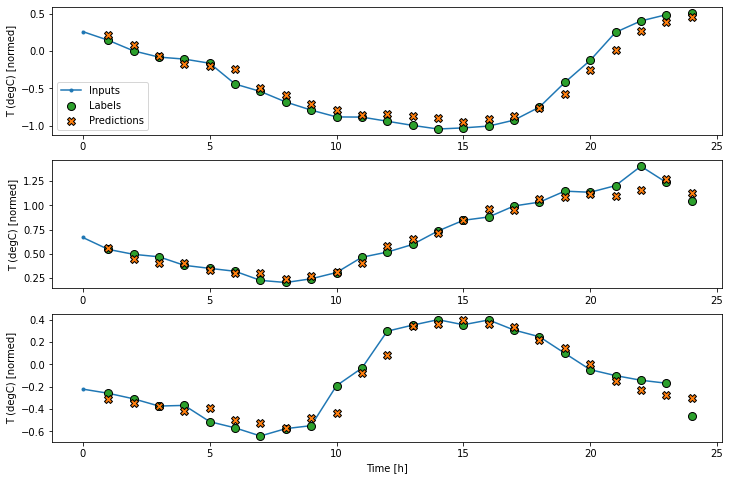

In [44]:
wide_window.plot(linear)

One advantage to linear models is that they're relatively simple to  interpret.
You can pull out the layer's weights, and see the weight assigned to each input:

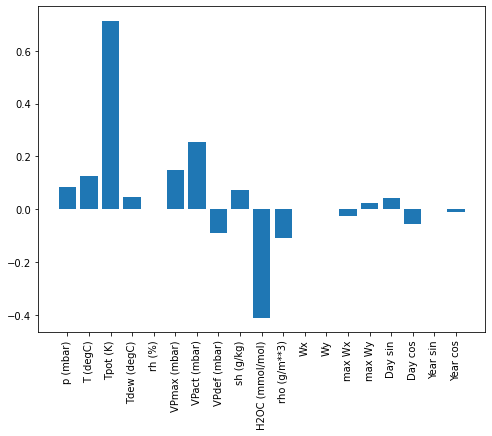

In [45]:
plt.bar(x = range(len(train_df.columns)),
        height=linear.layers[0].kernel[:,0].numpy())
axis = plt.gca()
axis.set_xticks(range(len(train_df.columns)))
_ = axis.set_xticklabels(train_df.columns, rotation=90)

Sometimes the model doesn't even place the most weight on the input `T (degC)`. This is one of the risks of random initialization. 

### Dense

Before applying models that actually operate on multiple time-steps, it's worth checking the performance of deeper, more powerful, single input step models.

Here's a model similar to the `linear` model, except it stacks several a few `Dense` layers between the input and the output: 

In [46]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

history = compile_and_fit(dense, single_step_window)

val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)

Epoch 1/20


   1/1534 [..............................] - ETA: 15:47 - loss: 2.4491 - mean_absolute_error: 1.1876

  16/1534 [..............................] - ETA: 5s - loss: 1.3829 - mean_absolute_error: 0.8666   

  31/1534 [..............................] - ETA: 5s - loss: 1.0033 - mean_absolute_error: 0.6964

  46/1534 [..............................] - ETA: 5s - loss: 0.8034 - mean_absolute_error: 0.5989

  62/1534 [>.............................] - ETA: 4s - loss: 0.6705 - mean_absolute_error: 0.5284

  77/1534 [>.............................] - ETA: 4s - loss: 0.5846 - mean_absolute_error: 0.4803

  93/1534 [>.............................] - ETA: 4s - loss: 0.5171 - mean_absolute_error: 0.4410

 108/1534 [=>............................] - ETA: 4s - loss: 0.4683 - mean_absolute_error: 0.4117

 124/1534 [=>............................] - ETA: 4s - loss: 0.4267 - mean_absolute_error: 0.3861

 139/1534 [=>............................] - ETA: 4s - loss: 0.3948 - mean_absolute_error: 0.3660

 154/1534 [==>...........................] - ETA: 4s - loss: 0.3679 - mean_absolute_error: 0.3488

 169/1534 [==>...........................] - ETA: 4s - loss: 0.3450 - mean_absolute_error: 0.3339

 184/1534 [==>...........................] - ETA: 4s - loss: 0.3251 - mean_absolute_error: 0.3208

 200/1534 [==>...........................] - ETA: 4s - loss: 0.3066 - mean_absolute_error: 0.3085

 215/1534 [===>..........................] - ETA: 4s - loss: 0.2914 - mean_absolute_error: 0.2981

 230/1534 [===>..........................] - ETA: 4s - loss: 0.2778 - mean_absolute_error: 0.2889

 245/1534 [===>..........................] - ETA: 4s - loss: 0.2656 - mean_absolute_error: 0.2805

 260/1534 [====>.........................] - ETA: 4s - loss: 0.2546 - mean_absolute_error: 0.2728

 275/1534 [====>.........................] - ETA: 4s - loss: 0.2446 - mean_absolute_error: 0.2657

 291/1534 [====>.........................] - ETA: 4s - loss: 0.2349 - mean_absolute_error: 0.2588

 306/1534 [====>.........................] - ETA: 4s - loss: 0.2265 - mean_absolute_error: 0.2528

 321/1534 [=====>........................] - ETA: 4s - loss: 0.2189 - mean_absolute_error: 0.2473

 336/1534 [=====>........................] - ETA: 4s - loss: 0.2118 - mean_absolute_error: 0.2421

 350/1534 [=====>........................] - ETA: 4s - loss: 0.2056 - mean_absolute_error: 0.2376

 365/1534 [======>.......................] - ETA: 3s - loss: 0.1995 - mean_absolute_error: 0.2331

 380/1534 [======>.......................] - ETA: 3s - loss: 0.1937 - mean_absolute_error: 0.2289

 396/1534 [======>.......................] - ETA: 3s - loss: 0.1880 - mean_absolute_error: 0.2246

 411/1534 [=======>......................] - ETA: 3s - loss: 0.1830 - mean_absolute_error: 0.2208

 427/1534 [=======>......................] - ETA: 3s - loss: 0.1780 - mean_absolute_error: 0.2171

 442/1534 [=======>......................] - ETA: 3s - loss: 0.1736 - mean_absolute_error: 0.2137

 457/1534 [=======>......................] - ETA: 3s - loss: 0.1694 - mean_absolute_error: 0.2105

 472/1534 [========>.....................] - ETA: 3s - loss: 0.1655 - mean_absolute_error: 0.2075

 487/1534 [========>.....................] - ETA: 3s - loss: 0.1618 - mean_absolute_error: 0.2046

 502/1534 [========>.....................] - ETA: 3s - loss: 0.1582 - mean_absolute_error: 0.2019

 517/1534 [=========>....................] - ETA: 3s - loss: 0.1549 - mean_absolute_error: 0.1992

 532/1534 [=========>....................] - ETA: 3s - loss: 0.1517 - mean_absolute_error: 0.1967

 547/1534 [=========>....................] - ETA: 3s - loss: 0.1486 - mean_absolute_error: 0.1944

 562/1534 [=========>....................] - ETA: 3s - loss: 0.1457 - mean_absolute_error: 0.1921

 578/1534 [==========>...................] - ETA: 3s - loss: 0.1428 - mean_absolute_error: 0.1897

 593/1534 [==========>...................] - ETA: 3s - loss: 0.1401 - mean_absolute_error: 0.1876

 608/1534 [==========>...................] - ETA: 3s - loss: 0.1376 - mean_absolute_error: 0.1856

 623/1534 [===========>..................] - ETA: 3s - loss: 0.1351 - mean_absolute_error: 0.1837

 638/1534 [===========>..................] - ETA: 3s - loss: 0.1328 - mean_absolute_error: 0.1818

 653/1534 [===========>..................] - ETA: 2s - loss: 0.1306 - mean_absolute_error: 0.1800

 668/1534 [============>.................] - ETA: 2s - loss: 0.1284 - mean_absolute_error: 0.1782

 684/1534 [============>.................] - ETA: 2s - loss: 0.1262 - mean_absolute_error: 0.1764

 699/1534 [============>.................] - ETA: 2s - loss: 0.1242 - mean_absolute_error: 0.1748

 714/1534 [============>.................] - ETA: 2s - loss: 0.1223 - mean_absolute_error: 0.1732

 729/1534 [=============>................] - ETA: 2s - loss: 0.1205 - mean_absolute_error: 0.1717

 745/1534 [=============>................] - ETA: 2s - loss: 0.1186 - mean_absolute_error: 0.1701

 760/1534 [=============>................] - ETA: 2s - loss: 0.1169 - mean_absolute_error: 0.1687

 775/1534 [==============>...............] - ETA: 2s - loss: 0.1152 - mean_absolute_error: 0.1673

 790/1534 [==============>...............] - ETA: 2s - loss: 0.1136 - mean_absolute_error: 0.1660

 805/1534 [==============>...............] - ETA: 2s - loss: 0.1120 - mean_absolute_error: 0.1647

 820/1534 [===============>..............] - ETA: 2s - loss: 0.1105 - mean_absolute_error: 0.1635

 834/1534 [===============>..............] - ETA: 2s - loss: 0.1092 - mean_absolute_error: 0.1623

 850/1534 [===============>..............] - ETA: 2s - loss: 0.1077 - mean_absolute_error: 0.1611

 865/1534 [===============>..............] - ETA: 2s - loss: 0.1063 - mean_absolute_error: 0.1599

 881/1534 [================>.............] - ETA: 2s - loss: 0.1049 - mean_absolute_error: 0.1587

 896/1534 [================>.............] - ETA: 2s - loss: 0.1036 - mean_absolute_error: 0.1576

 912/1534 [================>.............] - ETA: 2s - loss: 0.1023 - mean_absolute_error: 0.1565

 927/1534 [=================>............] - ETA: 2s - loss: 0.1011 - mean_absolute_error: 0.1555

 942/1534 [=================>............] - ETA: 2s - loss: 0.0999 - mean_absolute_error: 0.1545

 958/1534 [=================>............] - ETA: 1s - loss: 0.0987 - mean_absolute_error: 0.1534

 973/1534 [==================>...........] - ETA: 1s - loss: 0.0975 - mean_absolute_error: 0.1525

 988/1534 [==================>...........] - ETA: 1s - loss: 0.0965 - mean_absolute_error: 0.1515

1003/1534 [==================>...........] - ETA: 1s - loss: 0.0954 - mean_absolute_error: 0.1506

1018/1534 [==================>...........] - ETA: 1s - loss: 0.0944 - mean_absolute_error: 0.1497

1033/1534 [===================>..........] - ETA: 1s - loss: 0.0934 - mean_absolute_error: 0.1489

1048/1534 [===================>..........] - ETA: 1s - loss: 0.0924 - mean_absolute_error: 0.1480

1062/1534 [===================>..........] - ETA: 1s - loss: 0.0915 - mean_absolute_error: 0.1473

1078/1534 [====================>.........] - ETA: 1s - loss: 0.0905 - mean_absolute_error: 0.1464

1093/1534 [====================>.........] - ETA: 1s - loss: 0.0896 - mean_absolute_error: 0.1456

1108/1534 [====================>.........] - ETA: 1s - loss: 0.0887 - mean_absolute_error: 0.1449

1123/1534 [====================>.........] - ETA: 1s - loss: 0.0879 - mean_absolute_error: 0.1441

1138/1534 [=====================>........] - ETA: 1s - loss: 0.0870 - mean_absolute_error: 0.1434

1153/1534 [=====================>........] - ETA: 1s - loss: 0.0862 - mean_absolute_error: 0.1426

1168/1534 [=====================>........] - ETA: 1s - loss: 0.0854 - mean_absolute_error: 0.1419

1183/1534 [======================>.......] - ETA: 1s - loss: 0.0846 - mean_absolute_error: 0.1412

1197/1534 [======================>.......] - ETA: 1s - loss: 0.0839 - mean_absolute_error: 0.1406

1212/1534 [======================>.......] - ETA: 1s - loss: 0.0831 - mean_absolute_error: 0.1399

1228/1534 [=======================>......] - ETA: 1s - loss: 0.0824 - mean_absolute_error: 0.1392

1242/1534 [=======================>......] - ETA: 0s - loss: 0.0817 - mean_absolute_error: 0.1386

1257/1534 [=======================>......] - ETA: 0s - loss: 0.0810 - mean_absolute_error: 0.1380

1272/1534 [=======================>......] - ETA: 0s - loss: 0.0803 - mean_absolute_error: 0.1374

1287/1534 [========================>.....] - ETA: 0s - loss: 0.0796 - mean_absolute_error: 0.1368

1302/1534 [========================>.....] - ETA: 0s - loss: 0.0789 - mean_absolute_error: 0.1362

1317/1534 [========================>.....] - ETA: 0s - loss: 0.0783 - mean_absolute_error: 0.1356

1332/1534 [=========================>....] - ETA: 0s - loss: 0.0776 - mean_absolute_error: 0.1350

1347/1534 [=========================>....] - ETA: 0s - loss: 0.0770 - mean_absolute_error: 0.1345

1362/1534 [=========================>....] - ETA: 0s - loss: 0.0764 - mean_absolute_error: 0.1339

1377/1534 [=========================>....] - ETA: 0s - loss: 0.0758 - mean_absolute_error: 0.1334

1392/1534 [==========================>...] - ETA: 0s - loss: 0.0752 - mean_absolute_error: 0.1328

1407/1534 [==========================>...] - ETA: 0s - loss: 0.0746 - mean_absolute_error: 0.1323

1422/1534 [==========================>...] - ETA: 0s - loss: 0.0741 - mean_absolute_error: 0.1318

1437/1534 [===========================>..] - ETA: 0s - loss: 0.0735 - mean_absolute_error: 0.1313

1452/1534 [===========================>..] - ETA: 0s - loss: 0.0730 - mean_absolute_error: 0.1308

1467/1534 [===========================>..] - ETA: 0s - loss: 0.0724 - mean_absolute_error: 0.1303

1482/1534 [===========================>..] - ETA: 0s - loss: 0.0719 - mean_absolute_error: 0.1298

1497/1534 [============================>.] - ETA: 0s - loss: 0.0714 - mean_absolute_error: 0.1293

1512/1534 [============================>.] - ETA: 0s - loss: 0.0709 - mean_absolute_error: 0.1289

1527/1534 [============================>.] - ETA: 0s - loss: 0.0704 - mean_absolute_error: 0.1284

1534/1534 [==============================] - 7s 4ms/step - loss: 0.0701 - mean_absolute_error: 0.1282 - val_loss: 0.0090 - val_mean_absolute_error: 0.0719


Epoch 2/20
   1/1534 [..............................] - ETA: 30s - loss: 0.0094 - mean_absolute_error: 0.0793

  16/1534 [..............................] - ETA: 5s - loss: 0.0108 - mean_absolute_error: 0.0730 

  31/1534 [..............................] - ETA: 5s - loss: 0.0103 - mean_absolute_error: 0.0719

  47/1534 [..............................] - ETA: 5s - loss: 0.0100 - mean_absolute_error: 0.0711

  62/1534 [>.............................] - ETA: 4s - loss: 0.0098 - mean_absolute_error: 0.0707

  77/1534 [>.............................] - ETA: 4s - loss: 0.0096 - mean_absolute_error: 0.0704

  92/1534 [>.............................] - ETA: 4s - loss: 0.0095 - mean_absolute_error: 0.0700

 108/1534 [=>............................] - ETA: 4s - loss: 0.0094 - mean_absolute_error: 0.0697

 123/1534 [=>............................] - ETA: 4s - loss: 0.0093 - mean_absolute_error: 0.0694

 138/1534 [=>............................] - ETA: 4s - loss: 0.0092 - mean_absolute_error: 0.0691

 153/1534 [=>............................] - ETA: 4s - loss: 0.0091 - mean_absolute_error: 0.0689

 168/1534 [==>...........................] - ETA: 4s - loss: 0.0091 - mean_absolute_error: 0.0687

 183/1534 [==>...........................] - ETA: 4s - loss: 0.0090 - mean_absolute_error: 0.0685

 197/1534 [==>...........................] - ETA: 4s - loss: 0.0089 - mean_absolute_error: 0.0684

 213/1534 [===>..........................] - ETA: 4s - loss: 0.0089 - mean_absolute_error: 0.0683

 228/1534 [===>..........................] - ETA: 4s - loss: 0.0089 - mean_absolute_error: 0.0682

 243/1534 [===>..........................] - ETA: 4s - loss: 0.0088 - mean_absolute_error: 0.0681

 258/1534 [====>.........................] - ETA: 4s - loss: 0.0088 - mean_absolute_error: 0.0680

 273/1534 [====>.........................] - ETA: 4s - loss: 0.0088 - mean_absolute_error: 0.0679

 287/1534 [====>.........................] - ETA: 4s - loss: 0.0087 - mean_absolute_error: 0.0679

 302/1534 [====>.........................] - ETA: 4s - loss: 0.0087 - mean_absolute_error: 0.0678

 316/1534 [=====>........................] - ETA: 4s - loss: 0.0087 - mean_absolute_error: 0.0677

 331/1534 [=====>........................] - ETA: 4s - loss: 0.0087 - mean_absolute_error: 0.0677

 346/1534 [=====>........................] - ETA: 4s - loss: 0.0087 - mean_absolute_error: 0.0676

 361/1534 [======>.......................] - ETA: 4s - loss: 0.0086 - mean_absolute_error: 0.0676

 376/1534 [======>.......................] - ETA: 3s - loss: 0.0086 - mean_absolute_error: 0.0675

 391/1534 [======>.......................] - ETA: 3s - loss: 0.0086 - mean_absolute_error: 0.0675

 406/1534 [======>.......................] - ETA: 3s - loss: 0.0086 - mean_absolute_error: 0.0674

 421/1534 [=======>......................] - ETA: 3s - loss: 0.0086 - mean_absolute_error: 0.0673

 436/1534 [=======>......................] - ETA: 3s - loss: 0.0086 - mean_absolute_error: 0.0673

 451/1534 [=======>......................] - ETA: 3s - loss: 0.0085 - mean_absolute_error: 0.0672

 466/1534 [========>.....................] - ETA: 3s - loss: 0.0085 - mean_absolute_error: 0.0671

 481/1534 [========>.....................] - ETA: 3s - loss: 0.0085 - mean_absolute_error: 0.0671

 497/1534 [========>.....................] - ETA: 3s - loss: 0.0085 - mean_absolute_error: 0.0670

 512/1534 [=========>....................] - ETA: 3s - loss: 0.0085 - mean_absolute_error: 0.0670

 527/1534 [=========>....................] - ETA: 3s - loss: 0.0085 - mean_absolute_error: 0.0669

 542/1534 [=========>....................] - ETA: 3s - loss: 0.0085 - mean_absolute_error: 0.0669

 556/1534 [=========>....................] - ETA: 3s - loss: 0.0084 - mean_absolute_error: 0.0668

 570/1534 [==========>...................] - ETA: 3s - loss: 0.0084 - mean_absolute_error: 0.0668

 585/1534 [==========>...................] - ETA: 3s - loss: 0.0084 - mean_absolute_error: 0.0667

 600/1534 [==========>...................] - ETA: 3s - loss: 0.0084 - mean_absolute_error: 0.0667

 614/1534 [===========>..................] - ETA: 3s - loss: 0.0084 - mean_absolute_error: 0.0667

 629/1534 [===========>..................] - ETA: 3s - loss: 0.0084 - mean_absolute_error: 0.0666

 643/1534 [===========>..................] - ETA: 3s - loss: 0.0084 - mean_absolute_error: 0.0666

 658/1534 [===========>..................] - ETA: 3s - loss: 0.0084 - mean_absolute_error: 0.0666

 672/1534 [============>.................] - ETA: 2s - loss: 0.0084 - mean_absolute_error: 0.0665

 687/1534 [============>.................] - ETA: 2s - loss: 0.0084 - mean_absolute_error: 0.0665

 701/1534 [============>.................] - ETA: 2s - loss: 0.0084 - mean_absolute_error: 0.0665

 715/1534 [============>.................] - ETA: 2s - loss: 0.0084 - mean_absolute_error: 0.0665

 730/1534 [=============>................] - ETA: 2s - loss: 0.0084 - mean_absolute_error: 0.0664

 745/1534 [=============>................] - ETA: 2s - loss: 0.0083 - mean_absolute_error: 0.0664

 760/1534 [=============>................] - ETA: 2s - loss: 0.0083 - mean_absolute_error: 0.0664

 774/1534 [==============>...............] - ETA: 2s - loss: 0.0083 - mean_absolute_error: 0.0663

 789/1534 [==============>...............] - ETA: 2s - loss: 0.0083 - mean_absolute_error: 0.0663

 804/1534 [==============>...............] - ETA: 2s - loss: 0.0083 - mean_absolute_error: 0.0663

 819/1534 [===============>..............] - ETA: 2s - loss: 0.0083 - mean_absolute_error: 0.0662

 833/1534 [===============>..............] - ETA: 2s - loss: 0.0083 - mean_absolute_error: 0.0662

 848/1534 [===============>..............] - ETA: 2s - loss: 0.0083 - mean_absolute_error: 0.0662

 863/1534 [===============>..............] - ETA: 2s - loss: 0.0083 - mean_absolute_error: 0.0661

 878/1534 [================>.............] - ETA: 2s - loss: 0.0083 - mean_absolute_error: 0.0661

 892/1534 [================>.............] - ETA: 2s - loss: 0.0083 - mean_absolute_error: 0.0661

 906/1534 [================>.............] - ETA: 2s - loss: 0.0083 - mean_absolute_error: 0.0661

 921/1534 [=================>............] - ETA: 2s - loss: 0.0083 - mean_absolute_error: 0.0660

 936/1534 [=================>............] - ETA: 2s - loss: 0.0082 - mean_absolute_error: 0.0660

 951/1534 [=================>............] - ETA: 2s - loss: 0.0082 - mean_absolute_error: 0.0660

 966/1534 [=================>............] - ETA: 1s - loss: 0.0082 - mean_absolute_error: 0.0660

 981/1534 [==================>...........] - ETA: 1s - loss: 0.0082 - mean_absolute_error: 0.0659

 995/1534 [==================>...........] - ETA: 1s - loss: 0.0082 - mean_absolute_error: 0.0659

1010/1534 [==================>...........] - ETA: 1s - loss: 0.0082 - mean_absolute_error: 0.0659

1025/1534 [===================>..........] - ETA: 1s - loss: 0.0082 - mean_absolute_error: 0.0659

1040/1534 [===================>..........] - ETA: 1s - loss: 0.0082 - mean_absolute_error: 0.0659

1054/1534 [===================>..........] - ETA: 1s - loss: 0.0082 - mean_absolute_error: 0.0658

1068/1534 [===================>..........] - ETA: 1s - loss: 0.0082 - mean_absolute_error: 0.0658

1082/1534 [====================>.........] - ETA: 1s - loss: 0.0082 - mean_absolute_error: 0.0658

1096/1534 [====================>.........] - ETA: 1s - loss: 0.0082 - mean_absolute_error: 0.0658

1111/1534 [====================>.........] - ETA: 1s - loss: 0.0082 - mean_absolute_error: 0.0658

1125/1534 [=====================>........] - ETA: 1s - loss: 0.0082 - mean_absolute_error: 0.0657

1140/1534 [=====================>........] - ETA: 1s - loss: 0.0082 - mean_absolute_error: 0.0657

1155/1534 [=====================>........] - ETA: 1s - loss: 0.0082 - mean_absolute_error: 0.0657

1170/1534 [=====================>........] - ETA: 1s - loss: 0.0082 - mean_absolute_error: 0.0657

1185/1534 [======================>.......] - ETA: 1s - loss: 0.0082 - mean_absolute_error: 0.0657

1200/1534 [======================>.......] - ETA: 1s - loss: 0.0082 - mean_absolute_error: 0.0656

1215/1534 [======================>.......] - ETA: 1s - loss: 0.0082 - mean_absolute_error: 0.0656

1230/1534 [=======================>......] - ETA: 1s - loss: 0.0082 - mean_absolute_error: 0.0656

1245/1534 [=======================>......] - ETA: 1s - loss: 0.0081 - mean_absolute_error: 0.0656

1260/1534 [=======================>......] - ETA: 0s - loss: 0.0081 - mean_absolute_error: 0.0656

1275/1534 [=======================>......] - ETA: 0s - loss: 0.0081 - mean_absolute_error: 0.0655

1290/1534 [========================>.....] - ETA: 0s - loss: 0.0081 - mean_absolute_error: 0.0655

1305/1534 [========================>.....] - ETA: 0s - loss: 0.0081 - mean_absolute_error: 0.0655

1320/1534 [========================>.....] - ETA: 0s - loss: 0.0081 - mean_absolute_error: 0.0655

1335/1534 [=========================>....] - ETA: 0s - loss: 0.0081 - mean_absolute_error: 0.0655

1349/1534 [=========================>....] - ETA: 0s - loss: 0.0081 - mean_absolute_error: 0.0655

1364/1534 [=========================>....] - ETA: 0s - loss: 0.0081 - mean_absolute_error: 0.0654

1379/1534 [=========================>....] - ETA: 0s - loss: 0.0081 - mean_absolute_error: 0.0654

1394/1534 [==========================>...] - ETA: 0s - loss: 0.0081 - mean_absolute_error: 0.0654

1409/1534 [==========================>...] - ETA: 0s - loss: 0.0081 - mean_absolute_error: 0.0654

1424/1534 [==========================>...] - ETA: 0s - loss: 0.0081 - mean_absolute_error: 0.0654

1438/1534 [===========================>..] - ETA: 0s - loss: 0.0081 - mean_absolute_error: 0.0654

1452/1534 [===========================>..] - ETA: 0s - loss: 0.0081 - mean_absolute_error: 0.0654

1467/1534 [===========================>..] - ETA: 0s - loss: 0.0081 - mean_absolute_error: 0.0653

1481/1534 [===========================>..] - ETA: 0s - loss: 0.0081 - mean_absolute_error: 0.0653

1496/1534 [============================>.] - ETA: 0s - loss: 0.0081 - mean_absolute_error: 0.0653

1511/1534 [============================>.] - ETA: 0s - loss: 0.0081 - mean_absolute_error: 0.0653

1526/1534 [============================>.] - ETA: 0s - loss: 0.0081 - mean_absolute_error: 0.0653

1534/1534 [==============================] - 7s 4ms/step - loss: 0.0081 - mean_absolute_error: 0.0653 - val_loss: 0.0069 - val_mean_absolute_error: 0.0592


Epoch 3/20
   1/1534 [..............................] - ETA: 30s - loss: 0.0088 - mean_absolute_error: 0.0739

  15/1534 [..............................] - ETA: 5s - loss: 0.0091 - mean_absolute_error: 0.0629 

  30/1534 [..............................] - ETA: 5s - loss: 0.0087 - mean_absolute_error: 0.0618

  45/1534 [..............................] - ETA: 5s - loss: 0.0086 - mean_absolute_error: 0.0623

  60/1534 [>.............................] - ETA: 5s - loss: 0.0085 - mean_absolute_error: 0.0626

  74/1534 [>.............................] - ETA: 5s - loss: 0.0084 - mean_absolute_error: 0.0626

  89/1534 [>.............................] - ETA: 5s - loss: 0.0083 - mean_absolute_error: 0.0627

 103/1534 [=>............................] - ETA: 5s - loss: 0.0083 - mean_absolute_error: 0.0627

 118/1534 [=>............................] - ETA: 4s - loss: 0.0082 - mean_absolute_error: 0.0627

 132/1534 [=>............................] - ETA: 4s - loss: 0.0081 - mean_absolute_error: 0.0627

 147/1534 [=>............................] - ETA: 4s - loss: 0.0081 - mean_absolute_error: 0.0626

 161/1534 [==>...........................] - ETA: 4s - loss: 0.0080 - mean_absolute_error: 0.0626

 175/1534 [==>...........................] - ETA: 4s - loss: 0.0080 - mean_absolute_error: 0.0626

 190/1534 [==>...........................] - ETA: 4s - loss: 0.0080 - mean_absolute_error: 0.0625

 204/1534 [==>...........................] - ETA: 4s - loss: 0.0079 - mean_absolute_error: 0.0625

 219/1534 [===>..........................] - ETA: 4s - loss: 0.0079 - mean_absolute_error: 0.0625

 234/1534 [===>..........................] - ETA: 4s - loss: 0.0079 - mean_absolute_error: 0.0625

 249/1534 [===>..........................] - ETA: 4s - loss: 0.0079 - mean_absolute_error: 0.0625

 264/1534 [====>.........................] - ETA: 4s - loss: 0.0078 - mean_absolute_error: 0.0625

 279/1534 [====>.........................] - ETA: 4s - loss: 0.0078 - mean_absolute_error: 0.0625

 293/1534 [====>.........................] - ETA: 4s - loss: 0.0078 - mean_absolute_error: 0.0625

 308/1534 [=====>........................] - ETA: 4s - loss: 0.0078 - mean_absolute_error: 0.0625

 323/1534 [=====>........................] - ETA: 4s - loss: 0.0078 - mean_absolute_error: 0.0625

 338/1534 [=====>........................] - ETA: 4s - loss: 0.0078 - mean_absolute_error: 0.0625

 353/1534 [=====>........................] - ETA: 4s - loss: 0.0078 - mean_absolute_error: 0.0625

 368/1534 [======>.......................] - ETA: 4s - loss: 0.0078 - mean_absolute_error: 0.0625

 382/1534 [======>.......................] - ETA: 4s - loss: 0.0078 - mean_absolute_error: 0.0625

 396/1534 [======>.......................] - ETA: 4s - loss: 0.0077 - mean_absolute_error: 0.0626

 410/1534 [=======>......................] - ETA: 3s - loss: 0.0077 - mean_absolute_error: 0.0626

 425/1534 [=======>......................] - ETA: 3s - loss: 0.0077 - mean_absolute_error: 0.0626

 440/1534 [=======>......................] - ETA: 3s - loss: 0.0077 - mean_absolute_error: 0.0626

 455/1534 [=======>......................] - ETA: 3s - loss: 0.0077 - mean_absolute_error: 0.0625

 470/1534 [========>.....................] - ETA: 3s - loss: 0.0077 - mean_absolute_error: 0.0625

 484/1534 [========>.....................] - ETA: 3s - loss: 0.0077 - mean_absolute_error: 0.0625

 499/1534 [========>.....................] - ETA: 3s - loss: 0.0077 - mean_absolute_error: 0.0625

 514/1534 [=========>....................] - ETA: 3s - loss: 0.0077 - mean_absolute_error: 0.0625

 529/1534 [=========>....................] - ETA: 3s - loss: 0.0077 - mean_absolute_error: 0.0625

 544/1534 [=========>....................] - ETA: 3s - loss: 0.0077 - mean_absolute_error: 0.0625

 559/1534 [=========>....................] - ETA: 3s - loss: 0.0077 - mean_absolute_error: 0.0625

 574/1534 [==========>...................] - ETA: 3s - loss: 0.0077 - mean_absolute_error: 0.0625

 588/1534 [==========>...................] - ETA: 3s - loss: 0.0077 - mean_absolute_error: 0.0625

 603/1534 [==========>...................] - ETA: 3s - loss: 0.0077 - mean_absolute_error: 0.0625

 617/1534 [===========>..................] - ETA: 3s - loss: 0.0077 - mean_absolute_error: 0.0625

 631/1534 [===========>..................] - ETA: 3s - loss: 0.0077 - mean_absolute_error: 0.0624

 645/1534 [===========>..................] - ETA: 3s - loss: 0.0076 - mean_absolute_error: 0.0624

 659/1534 [===========>..................] - ETA: 3s - loss: 0.0076 - mean_absolute_error: 0.0624

 673/1534 [============>.................] - ETA: 3s - loss: 0.0076 - mean_absolute_error: 0.0624

 688/1534 [============>.................] - ETA: 3s - loss: 0.0076 - mean_absolute_error: 0.0624

 703/1534 [============>.................] - ETA: 2s - loss: 0.0076 - mean_absolute_error: 0.0624

 718/1534 [=============>................] - ETA: 2s - loss: 0.0076 - mean_absolute_error: 0.0624

 732/1534 [=============>................] - ETA: 2s - loss: 0.0076 - mean_absolute_error: 0.0624

 747/1534 [=============>................] - ETA: 2s - loss: 0.0076 - mean_absolute_error: 0.0624

 761/1534 [=============>................] - ETA: 2s - loss: 0.0076 - mean_absolute_error: 0.0624

 776/1534 [==============>...............] - ETA: 2s - loss: 0.0076 - mean_absolute_error: 0.0624

 790/1534 [==============>...............] - ETA: 2s - loss: 0.0076 - mean_absolute_error: 0.0624

 804/1534 [==============>...............] - ETA: 2s - loss: 0.0076 - mean_absolute_error: 0.0623

 819/1534 [===============>..............] - ETA: 2s - loss: 0.0076 - mean_absolute_error: 0.0623

 834/1534 [===============>..............] - ETA: 2s - loss: 0.0076 - mean_absolute_error: 0.0623

 849/1534 [===============>..............] - ETA: 2s - loss: 0.0076 - mean_absolute_error: 0.0623

 864/1534 [===============>..............] - ETA: 2s - loss: 0.0076 - mean_absolute_error: 0.0623

 879/1534 [================>.............] - ETA: 2s - loss: 0.0076 - mean_absolute_error: 0.0623

 894/1534 [================>.............] - ETA: 2s - loss: 0.0076 - mean_absolute_error: 0.0623

 909/1534 [================>.............] - ETA: 2s - loss: 0.0076 - mean_absolute_error: 0.0623

 924/1534 [=================>............] - ETA: 2s - loss: 0.0076 - mean_absolute_error: 0.0623

 939/1534 [=================>............] - ETA: 2s - loss: 0.0076 - mean_absolute_error: 0.0623

 954/1534 [=================>............] - ETA: 2s - loss: 0.0076 - mean_absolute_error: 0.0623

 969/1534 [=================>............] - ETA: 2s - loss: 0.0076 - mean_absolute_error: 0.0623

 984/1534 [==================>...........] - ETA: 1s - loss: 0.0076 - mean_absolute_error: 0.0623

 999/1534 [==================>...........] - ETA: 1s - loss: 0.0076 - mean_absolute_error: 0.0623

1014/1534 [==================>...........] - ETA: 1s - loss: 0.0076 - mean_absolute_error: 0.0623

1029/1534 [===================>..........] - ETA: 1s - loss: 0.0075 - mean_absolute_error: 0.0623

1044/1534 [===================>..........] - ETA: 1s - loss: 0.0075 - mean_absolute_error: 0.0623

1058/1534 [===================>..........] - ETA: 1s - loss: 0.0075 - mean_absolute_error: 0.0623

1073/1534 [===================>..........] - ETA: 1s - loss: 0.0075 - mean_absolute_error: 0.0622

1088/1534 [====================>.........] - ETA: 1s - loss: 0.0075 - mean_absolute_error: 0.0622

1103/1534 [====================>.........] - ETA: 1s - loss: 0.0075 - mean_absolute_error: 0.0622

1118/1534 [====================>.........] - ETA: 1s - loss: 0.0075 - mean_absolute_error: 0.0622

1133/1534 [=====================>........] - ETA: 1s - loss: 0.0075 - mean_absolute_error: 0.0622

1147/1534 [=====================>........] - ETA: 1s - loss: 0.0075 - mean_absolute_error: 0.0622

1162/1534 [=====================>........] - ETA: 1s - loss: 0.0075 - mean_absolute_error: 0.0622

1177/1534 [======================>.......] - ETA: 1s - loss: 0.0075 - mean_absolute_error: 0.0622

1191/1534 [======================>.......] - ETA: 1s - loss: 0.0075 - mean_absolute_error: 0.0622

1206/1534 [======================>.......] - ETA: 1s - loss: 0.0075 - mean_absolute_error: 0.0622

1221/1534 [======================>.......] - ETA: 1s - loss: 0.0075 - mean_absolute_error: 0.0622

1236/1534 [=======================>......] - ETA: 1s - loss: 0.0075 - mean_absolute_error: 0.0622

1250/1534 [=======================>......] - ETA: 1s - loss: 0.0075 - mean_absolute_error: 0.0622

1265/1534 [=======================>......] - ETA: 0s - loss: 0.0075 - mean_absolute_error: 0.0622

1279/1534 [========================>.....] - ETA: 0s - loss: 0.0075 - mean_absolute_error: 0.0622

1294/1534 [========================>.....] - ETA: 0s - loss: 0.0075 - mean_absolute_error: 0.0622

1309/1534 [========================>.....] - ETA: 0s - loss: 0.0075 - mean_absolute_error: 0.0622

1324/1534 [========================>.....] - ETA: 0s - loss: 0.0075 - mean_absolute_error: 0.0621

1339/1534 [=========================>....] - ETA: 0s - loss: 0.0075 - mean_absolute_error: 0.0621

1354/1534 [=========================>....] - ETA: 0s - loss: 0.0075 - mean_absolute_error: 0.0621

1369/1534 [=========================>....] - ETA: 0s - loss: 0.0075 - mean_absolute_error: 0.0621

1384/1534 [==========================>...] - ETA: 0s - loss: 0.0075 - mean_absolute_error: 0.0621

1399/1534 [==========================>...] - ETA: 0s - loss: 0.0075 - mean_absolute_error: 0.0621

1414/1534 [==========================>...] - ETA: 0s - loss: 0.0075 - mean_absolute_error: 0.0621

1429/1534 [==========================>...] - ETA: 0s - loss: 0.0075 - mean_absolute_error: 0.0621

1443/1534 [===========================>..] - ETA: 0s - loss: 0.0075 - mean_absolute_error: 0.0621

1458/1534 [===========================>..] - ETA: 0s - loss: 0.0075 - mean_absolute_error: 0.0621

1472/1534 [===========================>..] - ETA: 0s - loss: 0.0075 - mean_absolute_error: 0.0621

1487/1534 [============================>.] - ETA: 0s - loss: 0.0075 - mean_absolute_error: 0.0621

1502/1534 [============================>.] - ETA: 0s - loss: 0.0075 - mean_absolute_error: 0.0621

1517/1534 [============================>.] - ETA: 0s - loss: 0.0075 - mean_absolute_error: 0.0621

1530/1534 [============================>.] - ETA: 0s - loss: 0.0075 - mean_absolute_error: 0.0621

1534/1534 [==============================] - 7s 4ms/step - loss: 0.0075 - mean_absolute_error: 0.0621 - val_loss: 0.0069 - val_mean_absolute_error: 0.0607


Epoch 4/20
   1/1534 [..............................] - ETA: 31s - loss: 0.0068 - mean_absolute_error: 0.0662

  16/1534 [..............................] - ETA: 5s - loss: 0.0096 - mean_absolute_error: 0.0667 

  31/1534 [..............................] - ETA: 5s - loss: 0.0091 - mean_absolute_error: 0.0650

  46/1534 [..............................] - ETA: 5s - loss: 0.0089 - mean_absolute_error: 0.0647

  61/1534 [>.............................] - ETA: 5s - loss: 0.0087 - mean_absolute_error: 0.0642

  76/1534 [>.............................] - ETA: 5s - loss: 0.0085 - mean_absolute_error: 0.0638

  91/1534 [>.............................] - ETA: 5s - loss: 0.0084 - mean_absolute_error: 0.0637

 106/1534 [=>............................] - ETA: 4s - loss: 0.0083 - mean_absolute_error: 0.0636

 121/1534 [=>............................] - ETA: 4s - loss: 0.0082 - mean_absolute_error: 0.0634

 136/1534 [=>............................] - ETA: 4s - loss: 0.0082 - mean_absolute_error: 0.0633

 150/1534 [=>............................] - ETA: 4s - loss: 0.0081 - mean_absolute_error: 0.0631

 165/1534 [==>...........................] - ETA: 4s - loss: 0.0080 - mean_absolute_error: 0.0629

 180/1534 [==>...........................] - ETA: 4s - loss: 0.0080 - mean_absolute_error: 0.0628

 195/1534 [==>...........................] - ETA: 4s - loss: 0.0079 - mean_absolute_error: 0.0627

 210/1534 [===>..........................] - ETA: 4s - loss: 0.0079 - mean_absolute_error: 0.0626

 224/1534 [===>..........................] - ETA: 4s - loss: 0.0078 - mean_absolute_error: 0.0625

 239/1534 [===>..........................] - ETA: 4s - loss: 0.0078 - mean_absolute_error: 0.0625

 254/1534 [===>..........................] - ETA: 4s - loss: 0.0078 - mean_absolute_error: 0.0625

 269/1534 [====>.........................] - ETA: 4s - loss: 0.0078 - mean_absolute_error: 0.0624

 281/1534 [====>.........................] - ETA: 4s - loss: 0.0078 - mean_absolute_error: 0.0624

 296/1534 [====>.........................] - ETA: 4s - loss: 0.0077 - mean_absolute_error: 0.0624

 311/1534 [=====>........................] - ETA: 4s - loss: 0.0077 - mean_absolute_error: 0.0624

 326/1534 [=====>........................] - ETA: 4s - loss: 0.0077 - mean_absolute_error: 0.0623

 341/1534 [=====>........................] - ETA: 4s - loss: 0.0077 - mean_absolute_error: 0.0623

 356/1534 [=====>........................] - ETA: 4s - loss: 0.0077 - mean_absolute_error: 0.0623

 370/1534 [======>.......................] - ETA: 4s - loss: 0.0077 - mean_absolute_error: 0.0623

 385/1534 [======>.......................] - ETA: 4s - loss: 0.0077 - mean_absolute_error: 0.0623

 400/1534 [======>.......................] - ETA: 3s - loss: 0.0077 - mean_absolute_error: 0.0623

 415/1534 [=======>......................] - ETA: 3s - loss: 0.0077 - mean_absolute_error: 0.0622

 430/1534 [=======>......................] - ETA: 3s - loss: 0.0077 - mean_absolute_error: 0.0622

 445/1534 [=======>......................] - ETA: 3s - loss: 0.0076 - mean_absolute_error: 0.0622

 460/1534 [=======>......................] - ETA: 3s - loss: 0.0076 - mean_absolute_error: 0.0621

 475/1534 [========>.....................] - ETA: 3s - loss: 0.0076 - mean_absolute_error: 0.0621

 490/1534 [========>.....................] - ETA: 3s - loss: 0.0076 - mean_absolute_error: 0.0621

 505/1534 [========>.....................] - ETA: 3s - loss: 0.0076 - mean_absolute_error: 0.0620

 520/1534 [=========>....................] - ETA: 3s - loss: 0.0076 - mean_absolute_error: 0.0620

 535/1534 [=========>....................] - ETA: 3s - loss: 0.0076 - mean_absolute_error: 0.0620

 550/1534 [=========>....................] - ETA: 3s - loss: 0.0076 - mean_absolute_error: 0.0619

 564/1534 [==========>...................] - ETA: 3s - loss: 0.0076 - mean_absolute_error: 0.0619

 579/1534 [==========>...................] - ETA: 3s - loss: 0.0075 - mean_absolute_error: 0.0619

 594/1534 [==========>...................] - ETA: 3s - loss: 0.0075 - mean_absolute_error: 0.0619

 608/1534 [==========>...................] - ETA: 3s - loss: 0.0075 - mean_absolute_error: 0.0618

 623/1534 [===========>..................] - ETA: 3s - loss: 0.0075 - mean_absolute_error: 0.0618

 638/1534 [===========>..................] - ETA: 3s - loss: 0.0075 - mean_absolute_error: 0.0618

 653/1534 [===========>..................] - ETA: 3s - loss: 0.0075 - mean_absolute_error: 0.0618

 667/1534 [============>.................] - ETA: 3s - loss: 0.0075 - mean_absolute_error: 0.0617

 682/1534 [============>.................] - ETA: 2s - loss: 0.0075 - mean_absolute_error: 0.0617

 697/1534 [============>.................] - ETA: 2s - loss: 0.0075 - mean_absolute_error: 0.0617

 712/1534 [============>.................] - ETA: 2s - loss: 0.0075 - mean_absolute_error: 0.0617

 726/1534 [=============>................] - ETA: 2s - loss: 0.0075 - mean_absolute_error: 0.0616

 741/1534 [=============>................] - ETA: 2s - loss: 0.0075 - mean_absolute_error: 0.0616

 755/1534 [=============>................] - ETA: 2s - loss: 0.0075 - mean_absolute_error: 0.0616

 770/1534 [==============>...............] - ETA: 2s - loss: 0.0075 - mean_absolute_error: 0.0616

 785/1534 [==============>...............] - ETA: 2s - loss: 0.0075 - mean_absolute_error: 0.0615

 799/1534 [==============>...............] - ETA: 2s - loss: 0.0074 - mean_absolute_error: 0.0615

 814/1534 [==============>...............] - ETA: 2s - loss: 0.0074 - mean_absolute_error: 0.0615

 829/1534 [===============>..............] - ETA: 2s - loss: 0.0074 - mean_absolute_error: 0.0615

 844/1534 [===============>..............] - ETA: 2s - loss: 0.0074 - mean_absolute_error: 0.0615

 859/1534 [===============>..............] - ETA: 2s - loss: 0.0074 - mean_absolute_error: 0.0614

 872/1534 [================>.............] - ETA: 2s - loss: 0.0074 - mean_absolute_error: 0.0614

 887/1534 [================>.............] - ETA: 2s - loss: 0.0074 - mean_absolute_error: 0.0614

 902/1534 [================>.............] - ETA: 2s - loss: 0.0074 - mean_absolute_error: 0.0614

 917/1534 [================>.............] - ETA: 2s - loss: 0.0074 - mean_absolute_error: 0.0614

 932/1534 [=================>............] - ETA: 2s - loss: 0.0074 - mean_absolute_error: 0.0614

 947/1534 [=================>............] - ETA: 2s - loss: 0.0074 - mean_absolute_error: 0.0614

 961/1534 [=================>............] - ETA: 2s - loss: 0.0074 - mean_absolute_error: 0.0614

 976/1534 [==================>...........] - ETA: 1s - loss: 0.0074 - mean_absolute_error: 0.0613

 990/1534 [==================>...........] - ETA: 1s - loss: 0.0074 - mean_absolute_error: 0.0613

1005/1534 [==================>...........] - ETA: 1s - loss: 0.0074 - mean_absolute_error: 0.0613

1019/1534 [==================>...........] - ETA: 1s - loss: 0.0074 - mean_absolute_error: 0.0613

1034/1534 [===================>..........] - ETA: 1s - loss: 0.0074 - mean_absolute_error: 0.0613

1049/1534 [===================>..........] - ETA: 1s - loss: 0.0074 - mean_absolute_error: 0.0613

1064/1534 [===================>..........] - ETA: 1s - loss: 0.0074 - mean_absolute_error: 0.0613

1078/1534 [====================>.........] - ETA: 1s - loss: 0.0074 - mean_absolute_error: 0.0613

1093/1534 [====================>.........] - ETA: 1s - loss: 0.0074 - mean_absolute_error: 0.0613

1108/1534 [====================>.........] - ETA: 1s - loss: 0.0074 - mean_absolute_error: 0.0613

1123/1534 [====================>.........] - ETA: 1s - loss: 0.0074 - mean_absolute_error: 0.0612

1138/1534 [=====================>........] - ETA: 1s - loss: 0.0073 - mean_absolute_error: 0.0612

1153/1534 [=====================>........] - ETA: 1s - loss: 0.0073 - mean_absolute_error: 0.0612

1168/1534 [=====================>........] - ETA: 1s - loss: 0.0073 - mean_absolute_error: 0.0612

1183/1534 [======================>.......] - ETA: 1s - loss: 0.0073 - mean_absolute_error: 0.0612

1198/1534 [======================>.......] - ETA: 1s - loss: 0.0073 - mean_absolute_error: 0.0612

1213/1534 [======================>.......] - ETA: 1s - loss: 0.0073 - mean_absolute_error: 0.0612

1228/1534 [=======================>......] - ETA: 1s - loss: 0.0073 - mean_absolute_error: 0.0612

1241/1534 [=======================>......] - ETA: 1s - loss: 0.0073 - mean_absolute_error: 0.0612

1256/1534 [=======================>......] - ETA: 0s - loss: 0.0073 - mean_absolute_error: 0.0611

1271/1534 [=======================>......] - ETA: 0s - loss: 0.0073 - mean_absolute_error: 0.0611

1286/1534 [========================>.....] - ETA: 0s - loss: 0.0073 - mean_absolute_error: 0.0611

1301/1534 [========================>.....] - ETA: 0s - loss: 0.0073 - mean_absolute_error: 0.0611

1316/1534 [========================>.....] - ETA: 0s - loss: 0.0073 - mean_absolute_error: 0.0611

1331/1534 [=========================>....] - ETA: 0s - loss: 0.0073 - mean_absolute_error: 0.0611

1345/1534 [=========================>....] - ETA: 0s - loss: 0.0073 - mean_absolute_error: 0.0611

1360/1534 [=========================>....] - ETA: 0s - loss: 0.0073 - mean_absolute_error: 0.0611

1375/1534 [=========================>....] - ETA: 0s - loss: 0.0073 - mean_absolute_error: 0.0611

1391/1534 [==========================>...] - ETA: 0s - loss: 0.0073 - mean_absolute_error: 0.0611

1406/1534 [==========================>...] - ETA: 0s - loss: 0.0073 - mean_absolute_error: 0.0611

1421/1534 [==========================>...] - ETA: 0s - loss: 0.0073 - mean_absolute_error: 0.0611

1436/1534 [===========================>..] - ETA: 0s - loss: 0.0073 - mean_absolute_error: 0.0610

1451/1534 [===========================>..] - ETA: 0s - loss: 0.0073 - mean_absolute_error: 0.0610

1465/1534 [===========================>..] - ETA: 0s - loss: 0.0073 - mean_absolute_error: 0.0610

1480/1534 [===========================>..] - ETA: 0s - loss: 0.0073 - mean_absolute_error: 0.0610

1495/1534 [============================>.] - ETA: 0s - loss: 0.0073 - mean_absolute_error: 0.0610

1509/1534 [============================>.] - ETA: 0s - loss: 0.0073 - mean_absolute_error: 0.0610

1524/1534 [============================>.] - ETA: 0s - loss: 0.0073 - mean_absolute_error: 0.0610

1534/1534 [==============================] - 7s 4ms/step - loss: 0.0073 - mean_absolute_error: 0.0610 - val_loss: 0.0067 - val_mean_absolute_error: 0.0590


Epoch 5/20
   1/1534 [..............................] - ETA: 31s - loss: 0.0038 - mean_absolute_error: 0.0456

  16/1534 [..............................] - ETA: 5s - loss: 0.0073 - mean_absolute_error: 0.0595 

  31/1534 [..............................] - ETA: 5s - loss: 0.0075 - mean_absolute_error: 0.0600

  46/1534 [..............................] - ETA: 5s - loss: 0.0077 - mean_absolute_error: 0.0605

  61/1534 [>.............................] - ETA: 5s - loss: 0.0076 - mean_absolute_error: 0.0606

  76/1534 [>.............................] - ETA: 5s - loss: 0.0076 - mean_absolute_error: 0.0605

  91/1534 [>.............................] - ETA: 4s - loss: 0.0075 - mean_absolute_error: 0.0605

 106/1534 [=>............................] - ETA: 4s - loss: 0.0075 - mean_absolute_error: 0.0605

 121/1534 [=>............................] - ETA: 4s - loss: 0.0075 - mean_absolute_error: 0.0605

 135/1534 [=>............................] - ETA: 4s - loss: 0.0074 - mean_absolute_error: 0.0605

 150/1534 [=>............................] - ETA: 4s - loss: 0.0074 - mean_absolute_error: 0.0604

 164/1534 [==>...........................] - ETA: 4s - loss: 0.0074 - mean_absolute_error: 0.0604

 179/1534 [==>...........................] - ETA: 4s - loss: 0.0074 - mean_absolute_error: 0.0603

 194/1534 [==>...........................] - ETA: 4s - loss: 0.0073 - mean_absolute_error: 0.0603

 209/1534 [===>..........................] - ETA: 4s - loss: 0.0073 - mean_absolute_error: 0.0603

 224/1534 [===>..........................] - ETA: 4s - loss: 0.0073 - mean_absolute_error: 0.0603

 236/1534 [===>..........................] - ETA: 4s - loss: 0.0073 - mean_absolute_error: 0.0603

 251/1534 [===>..........................] - ETA: 4s - loss: 0.0073 - mean_absolute_error: 0.0603

 266/1534 [====>.........................] - ETA: 4s - loss: 0.0073 - mean_absolute_error: 0.0603

 281/1534 [====>.........................] - ETA: 4s - loss: 0.0073 - mean_absolute_error: 0.0603

 296/1534 [====>.........................] - ETA: 4s - loss: 0.0072 - mean_absolute_error: 0.0603

 311/1534 [=====>........................] - ETA: 4s - loss: 0.0072 - mean_absolute_error: 0.0603

 326/1534 [=====>........................] - ETA: 4s - loss: 0.0072 - mean_absolute_error: 0.0603

 341/1534 [=====>........................] - ETA: 4s - loss: 0.0072 - mean_absolute_error: 0.0603

 356/1534 [=====>........................] - ETA: 4s - loss: 0.0072 - mean_absolute_error: 0.0603

 371/1534 [======>.......................] - ETA: 4s - loss: 0.0072 - mean_absolute_error: 0.0603

 385/1534 [======>.......................] - ETA: 4s - loss: 0.0072 - mean_absolute_error: 0.0603

 400/1534 [======>.......................] - ETA: 3s - loss: 0.0072 - mean_absolute_error: 0.0603

 415/1534 [=======>......................] - ETA: 3s - loss: 0.0072 - mean_absolute_error: 0.0603

 430/1534 [=======>......................] - ETA: 3s - loss: 0.0072 - mean_absolute_error: 0.0603

 445/1534 [=======>......................] - ETA: 3s - loss: 0.0072 - mean_absolute_error: 0.0603

 459/1534 [=======>......................] - ETA: 3s - loss: 0.0072 - mean_absolute_error: 0.0603

 474/1534 [========>.....................] - ETA: 3s - loss: 0.0072 - mean_absolute_error: 0.0602

 489/1534 [========>.....................] - ETA: 3s - loss: 0.0072 - mean_absolute_error: 0.0602

 504/1534 [========>.....................] - ETA: 3s - loss: 0.0072 - mean_absolute_error: 0.0602

 519/1534 [=========>....................] - ETA: 3s - loss: 0.0072 - mean_absolute_error: 0.0602

 534/1534 [=========>....................] - ETA: 3s - loss: 0.0071 - mean_absolute_error: 0.0602

 548/1534 [=========>....................] - ETA: 3s - loss: 0.0071 - mean_absolute_error: 0.0602

 563/1534 [==========>...................] - ETA: 3s - loss: 0.0071 - mean_absolute_error: 0.0602

 577/1534 [==========>...................] - ETA: 3s - loss: 0.0071 - mean_absolute_error: 0.0602

 592/1534 [==========>...................] - ETA: 3s - loss: 0.0071 - mean_absolute_error: 0.0602

 606/1534 [==========>...................] - ETA: 3s - loss: 0.0071 - mean_absolute_error: 0.0602

 621/1534 [===========>..................] - ETA: 3s - loss: 0.0071 - mean_absolute_error: 0.0602

 636/1534 [===========>..................] - ETA: 3s - loss: 0.0071 - mean_absolute_error: 0.0601

 651/1534 [===========>..................] - ETA: 3s - loss: 0.0071 - mean_absolute_error: 0.0601

 666/1534 [============>.................] - ETA: 3s - loss: 0.0071 - mean_absolute_error: 0.0601

 678/1534 [============>.................] - ETA: 2s - loss: 0.0071 - mean_absolute_error: 0.0601

 693/1534 [============>.................] - ETA: 2s - loss: 0.0071 - mean_absolute_error: 0.0601

 707/1534 [============>.................] - ETA: 2s - loss: 0.0071 - mean_absolute_error: 0.0601

 722/1534 [=============>................] - ETA: 2s - loss: 0.0071 - mean_absolute_error: 0.0601

 737/1534 [=============>................] - ETA: 2s - loss: 0.0071 - mean_absolute_error: 0.0601

 752/1534 [=============>................] - ETA: 2s - loss: 0.0071 - mean_absolute_error: 0.0600

 767/1534 [==============>...............] - ETA: 2s - loss: 0.0071 - mean_absolute_error: 0.0600

 782/1534 [==============>...............] - ETA: 2s - loss: 0.0071 - mean_absolute_error: 0.0600

 797/1534 [==============>...............] - ETA: 2s - loss: 0.0071 - mean_absolute_error: 0.0600

 812/1534 [==============>...............] - ETA: 2s - loss: 0.0071 - mean_absolute_error: 0.0600

 827/1534 [===============>..............] - ETA: 2s - loss: 0.0071 - mean_absolute_error: 0.0600

 842/1534 [===============>..............] - ETA: 2s - loss: 0.0071 - mean_absolute_error: 0.0600

 857/1534 [===============>..............] - ETA: 2s - loss: 0.0071 - mean_absolute_error: 0.0599

 872/1534 [================>.............] - ETA: 2s - loss: 0.0071 - mean_absolute_error: 0.0599

 887/1534 [================>.............] - ETA: 2s - loss: 0.0071 - mean_absolute_error: 0.0599

 901/1534 [================>.............] - ETA: 2s - loss: 0.0071 - mean_absolute_error: 0.0599

 916/1534 [================>.............] - ETA: 2s - loss: 0.0070 - mean_absolute_error: 0.0599

 931/1534 [=================>............] - ETA: 2s - loss: 0.0070 - mean_absolute_error: 0.0599

 946/1534 [=================>............] - ETA: 2s - loss: 0.0070 - mean_absolute_error: 0.0599

 961/1534 [=================>............] - ETA: 2s - loss: 0.0070 - mean_absolute_error: 0.0599

 976/1534 [==================>...........] - ETA: 1s - loss: 0.0070 - mean_absolute_error: 0.0599

 991/1534 [==================>...........] - ETA: 1s - loss: 0.0070 - mean_absolute_error: 0.0599

1006/1534 [==================>...........] - ETA: 1s - loss: 0.0070 - mean_absolute_error: 0.0599

1021/1534 [==================>...........] - ETA: 1s - loss: 0.0070 - mean_absolute_error: 0.0599

1035/1534 [===================>..........] - ETA: 1s - loss: 0.0070 - mean_absolute_error: 0.0599

1049/1534 [===================>..........] - ETA: 1s - loss: 0.0070 - mean_absolute_error: 0.0599

1063/1534 [===================>..........] - ETA: 1s - loss: 0.0070 - mean_absolute_error: 0.0598

1078/1534 [====================>.........] - ETA: 1s - loss: 0.0070 - mean_absolute_error: 0.0598

1093/1534 [====================>.........] - ETA: 1s - loss: 0.0070 - mean_absolute_error: 0.0598

1108/1534 [====================>.........] - ETA: 1s - loss: 0.0070 - mean_absolute_error: 0.0598

1122/1534 [====================>.........] - ETA: 1s - loss: 0.0070 - mean_absolute_error: 0.0598

1136/1534 [=====================>........] - ETA: 1s - loss: 0.0070 - mean_absolute_error: 0.0598

1150/1534 [=====================>........] - ETA: 1s - loss: 0.0070 - mean_absolute_error: 0.0598

1164/1534 [=====================>........] - ETA: 1s - loss: 0.0070 - mean_absolute_error: 0.0598

1179/1534 [======================>.......] - ETA: 1s - loss: 0.0070 - mean_absolute_error: 0.0598

1193/1534 [======================>.......] - ETA: 1s - loss: 0.0070 - mean_absolute_error: 0.0598

1208/1534 [======================>.......] - ETA: 1s - loss: 0.0070 - mean_absolute_error: 0.0598

1223/1534 [======================>.......] - ETA: 1s - loss: 0.0070 - mean_absolute_error: 0.0598

1238/1534 [=======================>......] - ETA: 1s - loss: 0.0070 - mean_absolute_error: 0.0598

1252/1534 [=======================>......] - ETA: 0s - loss: 0.0070 - mean_absolute_error: 0.0598

1267/1534 [=======================>......] - ETA: 0s - loss: 0.0070 - mean_absolute_error: 0.0598

1281/1534 [========================>.....] - ETA: 0s - loss: 0.0070 - mean_absolute_error: 0.0598

1296/1534 [========================>.....] - ETA: 0s - loss: 0.0070 - mean_absolute_error: 0.0598

1309/1534 [========================>.....] - ETA: 0s - loss: 0.0070 - mean_absolute_error: 0.0598

1323/1534 [========================>.....] - ETA: 0s - loss: 0.0070 - mean_absolute_error: 0.0598

1338/1534 [=========================>....] - ETA: 0s - loss: 0.0070 - mean_absolute_error: 0.0597

1353/1534 [=========================>....] - ETA: 0s - loss: 0.0070 - mean_absolute_error: 0.0597

1367/1534 [=========================>....] - ETA: 0s - loss: 0.0070 - mean_absolute_error: 0.0597

1381/1534 [==========================>...] - ETA: 0s - loss: 0.0070 - mean_absolute_error: 0.0597

1395/1534 [==========================>...] - ETA: 0s - loss: 0.0070 - mean_absolute_error: 0.0597

1409/1534 [==========================>...] - ETA: 0s - loss: 0.0070 - mean_absolute_error: 0.0597

1424/1534 [==========================>...] - ETA: 0s - loss: 0.0070 - mean_absolute_error: 0.0597

1438/1534 [===========================>..] - ETA: 0s - loss: 0.0070 - mean_absolute_error: 0.0597

1453/1534 [===========================>..] - ETA: 0s - loss: 0.0070 - mean_absolute_error: 0.0597

1467/1534 [===========================>..] - ETA: 0s - loss: 0.0070 - mean_absolute_error: 0.0597

1482/1534 [===========================>..] - ETA: 0s - loss: 0.0070 - mean_absolute_error: 0.0597

1497/1534 [============================>.] - ETA: 0s - loss: 0.0070 - mean_absolute_error: 0.0597

1511/1534 [============================>.] - ETA: 0s - loss: 0.0070 - mean_absolute_error: 0.0597

1526/1534 [============================>.] - ETA: 0s - loss: 0.0070 - mean_absolute_error: 0.0597

1534/1534 [==============================] - 7s 4ms/step - loss: 0.0070 - mean_absolute_error: 0.0597 - val_loss: 0.0065 - val_mean_absolute_error: 0.0571


Epoch 6/20
   1/1534 [..............................] - ETA: 30s - loss: 0.0044 - mean_absolute_error: 0.0466

  16/1534 [..............................] - ETA: 5s - loss: 0.0101 - mean_absolute_error: 0.0640 

  30/1534 [..............................] - ETA: 5s - loss: 0.0094 - mean_absolute_error: 0.0633

  44/1534 [..............................] - ETA: 5s - loss: 0.0091 - mean_absolute_error: 0.0631

  59/1534 [>.............................] - ETA: 5s - loss: 0.0087 - mean_absolute_error: 0.0628

  74/1534 [>.............................] - ETA: 5s - loss: 0.0085 - mean_absolute_error: 0.0624

  89/1534 [>.............................] - ETA: 5s - loss: 0.0083 - mean_absolute_error: 0.0621

 103/1534 [=>............................] - ETA: 5s - loss: 0.0082 - mean_absolute_error: 0.0619

 118/1534 [=>............................] - ETA: 5s - loss: 0.0080 - mean_absolute_error: 0.0617

 132/1534 [=>............................] - ETA: 4s - loss: 0.0079 - mean_absolute_error: 0.0615

 147/1534 [=>............................] - ETA: 4s - loss: 0.0079 - mean_absolute_error: 0.0614

 161/1534 [==>...........................] - ETA: 4s - loss: 0.0078 - mean_absolute_error: 0.0612

 176/1534 [==>...........................] - ETA: 4s - loss: 0.0077 - mean_absolute_error: 0.0611

 191/1534 [==>...........................] - ETA: 4s - loss: 0.0077 - mean_absolute_error: 0.0610

 206/1534 [===>..........................] - ETA: 4s - loss: 0.0076 - mean_absolute_error: 0.0609

 220/1534 [===>..........................] - ETA: 4s - loss: 0.0076 - mean_absolute_error: 0.0609

 234/1534 [===>..........................] - ETA: 4s - loss: 0.0075 - mean_absolute_error: 0.0608

 249/1534 [===>..........................] - ETA: 4s - loss: 0.0075 - mean_absolute_error: 0.0607

 263/1534 [====>.........................] - ETA: 4s - loss: 0.0075 - mean_absolute_error: 0.0607

 278/1534 [====>.........................] - ETA: 4s - loss: 0.0075 - mean_absolute_error: 0.0607

 292/1534 [====>.........................] - ETA: 4s - loss: 0.0074 - mean_absolute_error: 0.0606

 307/1534 [=====>........................] - ETA: 4s - loss: 0.0074 - mean_absolute_error: 0.0606

 321/1534 [=====>........................] - ETA: 4s - loss: 0.0074 - mean_absolute_error: 0.0606

 336/1534 [=====>........................] - ETA: 4s - loss: 0.0074 - mean_absolute_error: 0.0606

 350/1534 [=====>........................] - ETA: 4s - loss: 0.0074 - mean_absolute_error: 0.0606

 364/1534 [======>.......................] - ETA: 4s - loss: 0.0074 - mean_absolute_error: 0.0605

 378/1534 [======>.......................] - ETA: 4s - loss: 0.0073 - mean_absolute_error: 0.0605

 393/1534 [======>.......................] - ETA: 4s - loss: 0.0073 - mean_absolute_error: 0.0605

 408/1534 [======>.......................] - ETA: 4s - loss: 0.0073 - mean_absolute_error: 0.0605

 423/1534 [=======>......................] - ETA: 3s - loss: 0.0073 - mean_absolute_error: 0.0604

 438/1534 [=======>......................] - ETA: 3s - loss: 0.0073 - mean_absolute_error: 0.0604

 452/1534 [=======>......................] - ETA: 3s - loss: 0.0073 - mean_absolute_error: 0.0604

 466/1534 [========>.....................] - ETA: 3s - loss: 0.0073 - mean_absolute_error: 0.0603

 480/1534 [========>.....................] - ETA: 3s - loss: 0.0073 - mean_absolute_error: 0.0603

 495/1534 [========>.....................] - ETA: 3s - loss: 0.0072 - mean_absolute_error: 0.0603

 510/1534 [========>.....................] - ETA: 3s - loss: 0.0072 - mean_absolute_error: 0.0602

 525/1534 [=========>....................] - ETA: 3s - loss: 0.0072 - mean_absolute_error: 0.0602

 539/1534 [=========>....................] - ETA: 3s - loss: 0.0072 - mean_absolute_error: 0.0602

 554/1534 [=========>....................] - ETA: 3s - loss: 0.0072 - mean_absolute_error: 0.0602

 568/1534 [==========>...................] - ETA: 3s - loss: 0.0072 - mean_absolute_error: 0.0601

 583/1534 [==========>...................] - ETA: 3s - loss: 0.0072 - mean_absolute_error: 0.0601

 598/1534 [==========>...................] - ETA: 3s - loss: 0.0072 - mean_absolute_error: 0.0601

 612/1534 [==========>...................] - ETA: 3s - loss: 0.0072 - mean_absolute_error: 0.0601

 627/1534 [===========>..................] - ETA: 3s - loss: 0.0072 - mean_absolute_error: 0.0601

 642/1534 [===========>..................] - ETA: 3s - loss: 0.0072 - mean_absolute_error: 0.0600

 657/1534 [===========>..................] - ETA: 3s - loss: 0.0072 - mean_absolute_error: 0.0600

 671/1534 [============>.................] - ETA: 3s - loss: 0.0071 - mean_absolute_error: 0.0600

 686/1534 [============>.................] - ETA: 3s - loss: 0.0071 - mean_absolute_error: 0.0600

 700/1534 [============>.................] - ETA: 2s - loss: 0.0071 - mean_absolute_error: 0.0599

 715/1534 [============>.................] - ETA: 2s - loss: 0.0071 - mean_absolute_error: 0.0599

 730/1534 [=============>................] - ETA: 2s - loss: 0.0071 - mean_absolute_error: 0.0599

 745/1534 [=============>................] - ETA: 2s - loss: 0.0071 - mean_absolute_error: 0.0599

 760/1534 [=============>................] - ETA: 2s - loss: 0.0071 - mean_absolute_error: 0.0599

 774/1534 [==============>...............] - ETA: 2s - loss: 0.0071 - mean_absolute_error: 0.0598

 789/1534 [==============>...............] - ETA: 2s - loss: 0.0071 - mean_absolute_error: 0.0598

 803/1534 [==============>...............] - ETA: 2s - loss: 0.0071 - mean_absolute_error: 0.0598

 818/1534 [==============>...............] - ETA: 2s - loss: 0.0071 - mean_absolute_error: 0.0598

 832/1534 [===============>..............] - ETA: 2s - loss: 0.0071 - mean_absolute_error: 0.0598

 847/1534 [===============>..............] - ETA: 2s - loss: 0.0071 - mean_absolute_error: 0.0597

 861/1534 [===============>..............] - ETA: 2s - loss: 0.0071 - mean_absolute_error: 0.0597

 876/1534 [================>.............] - ETA: 2s - loss: 0.0071 - mean_absolute_error: 0.0597

 890/1534 [================>.............] - ETA: 2s - loss: 0.0070 - mean_absolute_error: 0.0597

 905/1534 [================>.............] - ETA: 2s - loss: 0.0070 - mean_absolute_error: 0.0597

 920/1534 [================>.............] - ETA: 2s - loss: 0.0070 - mean_absolute_error: 0.0597

 934/1534 [=================>............] - ETA: 2s - loss: 0.0070 - mean_absolute_error: 0.0596

 949/1534 [=================>............] - ETA: 2s - loss: 0.0070 - mean_absolute_error: 0.0596

 963/1534 [=================>............] - ETA: 2s - loss: 0.0070 - mean_absolute_error: 0.0596

 978/1534 [==================>...........] - ETA: 1s - loss: 0.0070 - mean_absolute_error: 0.0596

 992/1534 [==================>...........] - ETA: 1s - loss: 0.0070 - mean_absolute_error: 0.0596

1007/1534 [==================>...........] - ETA: 1s - loss: 0.0070 - mean_absolute_error: 0.0596

1022/1534 [==================>...........] - ETA: 1s - loss: 0.0070 - mean_absolute_error: 0.0596

1035/1534 [===================>..........] - ETA: 1s - loss: 0.0070 - mean_absolute_error: 0.0596

1049/1534 [===================>..........] - ETA: 1s - loss: 0.0070 - mean_absolute_error: 0.0595

1064/1534 [===================>..........] - ETA: 1s - loss: 0.0070 - mean_absolute_error: 0.0595

1079/1534 [====================>.........] - ETA: 1s - loss: 0.0070 - mean_absolute_error: 0.0595

1094/1534 [====================>.........] - ETA: 1s - loss: 0.0070 - mean_absolute_error: 0.0595

1109/1534 [====================>.........] - ETA: 1s - loss: 0.0070 - mean_absolute_error: 0.0595

1124/1534 [====================>.........] - ETA: 1s - loss: 0.0070 - mean_absolute_error: 0.0595

1139/1534 [=====================>........] - ETA: 1s - loss: 0.0070 - mean_absolute_error: 0.0595

1154/1534 [=====================>........] - ETA: 1s - loss: 0.0070 - mean_absolute_error: 0.0595

1169/1534 [=====================>........] - ETA: 1s - loss: 0.0070 - mean_absolute_error: 0.0595

1183/1534 [======================>.......] - ETA: 1s - loss: 0.0070 - mean_absolute_error: 0.0595

1198/1534 [======================>.......] - ETA: 1s - loss: 0.0070 - mean_absolute_error: 0.0595

1213/1534 [======================>.......] - ETA: 1s - loss: 0.0070 - mean_absolute_error: 0.0594

1227/1534 [======================>.......] - ETA: 1s - loss: 0.0070 - mean_absolute_error: 0.0594

1241/1534 [=======================>......] - ETA: 1s - loss: 0.0070 - mean_absolute_error: 0.0594

1256/1534 [=======================>......] - ETA: 0s - loss: 0.0070 - mean_absolute_error: 0.0594

1268/1534 [=======================>......] - ETA: 0s - loss: 0.0070 - mean_absolute_error: 0.0594

1282/1534 [========================>.....] - ETA: 0s - loss: 0.0070 - mean_absolute_error: 0.0594

1297/1534 [========================>.....] - ETA: 0s - loss: 0.0070 - mean_absolute_error: 0.0594

1311/1534 [========================>.....] - ETA: 0s - loss: 0.0070 - mean_absolute_error: 0.0594

1326/1534 [========================>.....] - ETA: 0s - loss: 0.0070 - mean_absolute_error: 0.0594

1340/1534 [=========================>....] - ETA: 0s - loss: 0.0070 - mean_absolute_error: 0.0594

1355/1534 [=========================>....] - ETA: 0s - loss: 0.0070 - mean_absolute_error: 0.0594

1370/1534 [=========================>....] - ETA: 0s - loss: 0.0070 - mean_absolute_error: 0.0594

1385/1534 [==========================>...] - ETA: 0s - loss: 0.0070 - mean_absolute_error: 0.0594

1399/1534 [==========================>...] - ETA: 0s - loss: 0.0070 - mean_absolute_error: 0.0594

1414/1534 [==========================>...] - ETA: 0s - loss: 0.0070 - mean_absolute_error: 0.0594

1429/1534 [==========================>...] - ETA: 0s - loss: 0.0070 - mean_absolute_error: 0.0594

1444/1534 [===========================>..] - ETA: 0s - loss: 0.0070 - mean_absolute_error: 0.0594

1459/1534 [===========================>..] - ETA: 0s - loss: 0.0070 - mean_absolute_error: 0.0594

1474/1534 [===========================>..] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0594

1489/1534 [============================>.] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0594

1503/1534 [============================>.] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0593

1518/1534 [============================>.] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0593

1534/1534 [==============================] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0593

1534/1534 [==============================] - 7s 4ms/step - loss: 0.0069 - mean_absolute_error: 0.0593 - val_loss: 0.0067 - val_mean_absolute_error: 0.0590


Epoch 7/20
   1/1534 [..............................] - ETA: 30s - loss: 0.0066 - mean_absolute_error: 0.0659

  15/1534 [..............................] - ETA: 5s - loss: 0.0078 - mean_absolute_error: 0.0661 

  30/1534 [..............................] - ETA: 5s - loss: 0.0080 - mean_absolute_error: 0.0650

  45/1534 [..............................] - ETA: 5s - loss: 0.0080 - mean_absolute_error: 0.0641

  60/1534 [>.............................] - ETA: 5s - loss: 0.0079 - mean_absolute_error: 0.0637

  75/1534 [>.............................] - ETA: 5s - loss: 0.0079 - mean_absolute_error: 0.0634

  89/1534 [>.............................] - ETA: 5s - loss: 0.0078 - mean_absolute_error: 0.0632

 103/1534 [=>............................] - ETA: 5s - loss: 0.0078 - mean_absolute_error: 0.0630

 118/1534 [=>............................] - ETA: 5s - loss: 0.0078 - mean_absolute_error: 0.0628

 133/1534 [=>............................] - ETA: 4s - loss: 0.0077 - mean_absolute_error: 0.0626

 148/1534 [=>............................] - ETA: 4s - loss: 0.0076 - mean_absolute_error: 0.0624

 163/1534 [==>...........................] - ETA: 4s - loss: 0.0076 - mean_absolute_error: 0.0622

 177/1534 [==>...........................] - ETA: 4s - loss: 0.0075 - mean_absolute_error: 0.0620

 192/1534 [==>...........................] - ETA: 4s - loss: 0.0075 - mean_absolute_error: 0.0618

 207/1534 [===>..........................] - ETA: 4s - loss: 0.0075 - mean_absolute_error: 0.0617

 222/1534 [===>..........................] - ETA: 4s - loss: 0.0074 - mean_absolute_error: 0.0615

 237/1534 [===>..........................] - ETA: 4s - loss: 0.0074 - mean_absolute_error: 0.0614

 251/1534 [===>..........................] - ETA: 4s - loss: 0.0074 - mean_absolute_error: 0.0614

 265/1534 [====>.........................] - ETA: 4s - loss: 0.0074 - mean_absolute_error: 0.0613

 280/1534 [====>.........................] - ETA: 4s - loss: 0.0073 - mean_absolute_error: 0.0612

 295/1534 [====>.........................] - ETA: 4s - loss: 0.0073 - mean_absolute_error: 0.0611

 309/1534 [=====>........................] - ETA: 4s - loss: 0.0073 - mean_absolute_error: 0.0611

 324/1534 [=====>........................] - ETA: 4s - loss: 0.0073 - mean_absolute_error: 0.0610

 338/1534 [=====>........................] - ETA: 4s - loss: 0.0073 - mean_absolute_error: 0.0610

 353/1534 [=====>........................] - ETA: 4s - loss: 0.0073 - mean_absolute_error: 0.0610

 367/1534 [======>.......................] - ETA: 4s - loss: 0.0073 - mean_absolute_error: 0.0609

 382/1534 [======>.......................] - ETA: 4s - loss: 0.0073 - mean_absolute_error: 0.0609

 397/1534 [======>.......................] - ETA: 4s - loss: 0.0073 - mean_absolute_error: 0.0608

 412/1534 [=======>......................] - ETA: 3s - loss: 0.0072 - mean_absolute_error: 0.0608

 427/1534 [=======>......................] - ETA: 3s - loss: 0.0072 - mean_absolute_error: 0.0607

 441/1534 [=======>......................] - ETA: 3s - loss: 0.0072 - mean_absolute_error: 0.0607

 456/1534 [=======>......................] - ETA: 3s - loss: 0.0072 - mean_absolute_error: 0.0606

 470/1534 [========>.....................] - ETA: 3s - loss: 0.0072 - mean_absolute_error: 0.0606

 485/1534 [========>.....................] - ETA: 3s - loss: 0.0072 - mean_absolute_error: 0.0605

 500/1534 [========>.....................] - ETA: 3s - loss: 0.0072 - mean_absolute_error: 0.0605

 515/1534 [=========>....................] - ETA: 3s - loss: 0.0072 - mean_absolute_error: 0.0604

 529/1534 [=========>....................] - ETA: 3s - loss: 0.0071 - mean_absolute_error: 0.0604

 544/1534 [=========>....................] - ETA: 3s - loss: 0.0071 - mean_absolute_error: 0.0603

 559/1534 [=========>....................] - ETA: 3s - loss: 0.0071 - mean_absolute_error: 0.0603

 573/1534 [==========>...................] - ETA: 3s - loss: 0.0071 - mean_absolute_error: 0.0603

 588/1534 [==========>...................] - ETA: 3s - loss: 0.0071 - mean_absolute_error: 0.0602

 602/1534 [==========>...................] - ETA: 3s - loss: 0.0071 - mean_absolute_error: 0.0602

 616/1534 [===========>..................] - ETA: 3s - loss: 0.0071 - mean_absolute_error: 0.0602

 630/1534 [===========>..................] - ETA: 3s - loss: 0.0071 - mean_absolute_error: 0.0601

 644/1534 [===========>..................] - ETA: 3s - loss: 0.0071 - mean_absolute_error: 0.0601

 658/1534 [===========>..................] - ETA: 3s - loss: 0.0071 - mean_absolute_error: 0.0601

 673/1534 [============>.................] - ETA: 3s - loss: 0.0071 - mean_absolute_error: 0.0601

 687/1534 [============>.................] - ETA: 3s - loss: 0.0071 - mean_absolute_error: 0.0600

 702/1534 [============>.................] - ETA: 2s - loss: 0.0071 - mean_absolute_error: 0.0600

 717/1534 [=============>................] - ETA: 2s - loss: 0.0071 - mean_absolute_error: 0.0600

 732/1534 [=============>................] - ETA: 2s - loss: 0.0071 - mean_absolute_error: 0.0599

 747/1534 [=============>................] - ETA: 2s - loss: 0.0070 - mean_absolute_error: 0.0599

 762/1534 [=============>................] - ETA: 2s - loss: 0.0070 - mean_absolute_error: 0.0599

 777/1534 [==============>...............] - ETA: 2s - loss: 0.0070 - mean_absolute_error: 0.0598

 792/1534 [==============>...............] - ETA: 2s - loss: 0.0070 - mean_absolute_error: 0.0598

 807/1534 [==============>...............] - ETA: 2s - loss: 0.0070 - mean_absolute_error: 0.0598

 822/1534 [===============>..............] - ETA: 2s - loss: 0.0070 - mean_absolute_error: 0.0598

 837/1534 [===============>..............] - ETA: 2s - loss: 0.0070 - mean_absolute_error: 0.0597

 852/1534 [===============>..............] - ETA: 2s - loss: 0.0070 - mean_absolute_error: 0.0597

 867/1534 [===============>..............] - ETA: 2s - loss: 0.0070 - mean_absolute_error: 0.0597

 882/1534 [================>.............] - ETA: 2s - loss: 0.0070 - mean_absolute_error: 0.0597

 897/1534 [================>.............] - ETA: 2s - loss: 0.0070 - mean_absolute_error: 0.0597

 912/1534 [================>.............] - ETA: 2s - loss: 0.0070 - mean_absolute_error: 0.0596

 927/1534 [=================>............] - ETA: 2s - loss: 0.0070 - mean_absolute_error: 0.0596

 942/1534 [=================>............] - ETA: 2s - loss: 0.0070 - mean_absolute_error: 0.0596

 956/1534 [=================>............] - ETA: 2s - loss: 0.0070 - mean_absolute_error: 0.0596

 971/1534 [=================>............] - ETA: 1s - loss: 0.0070 - mean_absolute_error: 0.0596

 985/1534 [==================>...........] - ETA: 1s - loss: 0.0070 - mean_absolute_error: 0.0596

1000/1534 [==================>...........] - ETA: 1s - loss: 0.0070 - mean_absolute_error: 0.0596

1015/1534 [==================>...........] - ETA: 1s - loss: 0.0070 - mean_absolute_error: 0.0595

1030/1534 [===================>..........] - ETA: 1s - loss: 0.0070 - mean_absolute_error: 0.0595

1045/1534 [===================>..........] - ETA: 1s - loss: 0.0070 - mean_absolute_error: 0.0595

1060/1534 [===================>..........] - ETA: 1s - loss: 0.0070 - mean_absolute_error: 0.0595

1075/1534 [====================>.........] - ETA: 1s - loss: 0.0069 - mean_absolute_error: 0.0595

1090/1534 [====================>.........] - ETA: 1s - loss: 0.0069 - mean_absolute_error: 0.0595

1105/1534 [====================>.........] - ETA: 1s - loss: 0.0069 - mean_absolute_error: 0.0595

1119/1534 [====================>.........] - ETA: 1s - loss: 0.0069 - mean_absolute_error: 0.0595

1134/1534 [=====================>........] - ETA: 1s - loss: 0.0069 - mean_absolute_error: 0.0595

1149/1534 [=====================>........] - ETA: 1s - loss: 0.0069 - mean_absolute_error: 0.0594

1164/1534 [=====================>........] - ETA: 1s - loss: 0.0069 - mean_absolute_error: 0.0594

1179/1534 [======================>.......] - ETA: 1s - loss: 0.0069 - mean_absolute_error: 0.0594

1194/1534 [======================>.......] - ETA: 1s - loss: 0.0069 - mean_absolute_error: 0.0594

1209/1534 [======================>.......] - ETA: 1s - loss: 0.0069 - mean_absolute_error: 0.0594

1224/1534 [======================>.......] - ETA: 1s - loss: 0.0069 - mean_absolute_error: 0.0594

1238/1534 [=======================>......] - ETA: 1s - loss: 0.0069 - mean_absolute_error: 0.0594

1253/1534 [=======================>......] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0594

1266/1534 [=======================>......] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0594

1281/1534 [========================>.....] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0594

1296/1534 [========================>.....] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0594

1311/1534 [========================>.....] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0593

1326/1534 [========================>.....] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0593

1341/1534 [=========================>....] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0593

1356/1534 [=========================>....] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0593

1371/1534 [=========================>....] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0593

1386/1534 [==========================>...] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0593

1401/1534 [==========================>...] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0593

1416/1534 [==========================>...] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0593

1431/1534 [==========================>...] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0593

1446/1534 [===========================>..] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0593

1461/1534 [===========================>..] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0593

1476/1534 [===========================>..] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0593

1491/1534 [============================>.] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0593

1505/1534 [============================>.] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0593

1520/1534 [============================>.] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0593

1534/1534 [==============================] - 7s 4ms/step - loss: 0.0069 - mean_absolute_error: 0.0592 - val_loss: 0.0064 - val_mean_absolute_error: 0.0564


Epoch 8/20
   1/1534 [..............................] - ETA: 31s - loss: 0.0165 - mean_absolute_error: 0.0780

  16/1534 [..............................] - ETA: 5s - loss: 0.0101 - mean_absolute_error: 0.0631 

  31/1534 [..............................] - ETA: 5s - loss: 0.0094 - mean_absolute_error: 0.0629

  46/1534 [..............................] - ETA: 5s - loss: 0.0089 - mean_absolute_error: 0.0627

  61/1534 [>.............................] - ETA: 5s - loss: 0.0087 - mean_absolute_error: 0.0624

  75/1534 [>.............................] - ETA: 5s - loss: 0.0085 - mean_absolute_error: 0.0621

  90/1534 [>.............................] - ETA: 5s - loss: 0.0083 - mean_absolute_error: 0.0619

 104/1534 [=>............................] - ETA: 5s - loss: 0.0082 - mean_absolute_error: 0.0618

 119/1534 [=>............................] - ETA: 4s - loss: 0.0081 - mean_absolute_error: 0.0616

 133/1534 [=>............................] - ETA: 4s - loss: 0.0080 - mean_absolute_error: 0.0615

 147/1534 [=>............................] - ETA: 4s - loss: 0.0079 - mean_absolute_error: 0.0615

 162/1534 [==>...........................] - ETA: 4s - loss: 0.0079 - mean_absolute_error: 0.0614

 177/1534 [==>...........................] - ETA: 4s - loss: 0.0078 - mean_absolute_error: 0.0613

 192/1534 [==>...........................] - ETA: 4s - loss: 0.0078 - mean_absolute_error: 0.0613

 207/1534 [===>..........................] - ETA: 4s - loss: 0.0077 - mean_absolute_error: 0.0612

 222/1534 [===>..........................] - ETA: 4s - loss: 0.0077 - mean_absolute_error: 0.0611

 237/1534 [===>..........................] - ETA: 4s - loss: 0.0076 - mean_absolute_error: 0.0611

 252/1534 [===>..........................] - ETA: 4s - loss: 0.0076 - mean_absolute_error: 0.0610

 267/1534 [====>.........................] - ETA: 4s - loss: 0.0076 - mean_absolute_error: 0.0609

 282/1534 [====>.........................] - ETA: 4s - loss: 0.0075 - mean_absolute_error: 0.0608

 297/1534 [====>.........................] - ETA: 4s - loss: 0.0075 - mean_absolute_error: 0.0608

 312/1534 [=====>........................] - ETA: 4s - loss: 0.0075 - mean_absolute_error: 0.0607

 326/1534 [=====>........................] - ETA: 4s - loss: 0.0075 - mean_absolute_error: 0.0607

 341/1534 [=====>........................] - ETA: 4s - loss: 0.0075 - mean_absolute_error: 0.0607

 356/1534 [=====>........................] - ETA: 4s - loss: 0.0074 - mean_absolute_error: 0.0606

 371/1534 [======>.......................] - ETA: 4s - loss: 0.0074 - mean_absolute_error: 0.0606

 386/1534 [======>.......................] - ETA: 4s - loss: 0.0074 - mean_absolute_error: 0.0605

 401/1534 [======>.......................] - ETA: 3s - loss: 0.0074 - mean_absolute_error: 0.0605

 416/1534 [=======>......................] - ETA: 3s - loss: 0.0074 - mean_absolute_error: 0.0604

 431/1534 [=======>......................] - ETA: 3s - loss: 0.0073 - mean_absolute_error: 0.0604

 446/1534 [=======>......................] - ETA: 3s - loss: 0.0073 - mean_absolute_error: 0.0603

 461/1534 [========>.....................] - ETA: 3s - loss: 0.0073 - mean_absolute_error: 0.0603

 476/1534 [========>.....................] - ETA: 3s - loss: 0.0073 - mean_absolute_error: 0.0602

 491/1534 [========>.....................] - ETA: 3s - loss: 0.0073 - mean_absolute_error: 0.0602

 506/1534 [========>.....................] - ETA: 3s - loss: 0.0073 - mean_absolute_error: 0.0601

 521/1534 [=========>....................] - ETA: 3s - loss: 0.0072 - mean_absolute_error: 0.0600

 536/1534 [=========>....................] - ETA: 3s - loss: 0.0072 - mean_absolute_error: 0.0600

 551/1534 [=========>....................] - ETA: 3s - loss: 0.0072 - mean_absolute_error: 0.0600

 566/1534 [==========>...................] - ETA: 3s - loss: 0.0072 - mean_absolute_error: 0.0599

 581/1534 [==========>...................] - ETA: 3s - loss: 0.0072 - mean_absolute_error: 0.0599

 596/1534 [==========>...................] - ETA: 3s - loss: 0.0072 - mean_absolute_error: 0.0599

 611/1534 [==========>...................] - ETA: 3s - loss: 0.0072 - mean_absolute_error: 0.0598

 626/1534 [===========>..................] - ETA: 3s - loss: 0.0072 - mean_absolute_error: 0.0598

 641/1534 [===========>..................] - ETA: 3s - loss: 0.0072 - mean_absolute_error: 0.0598

 656/1534 [===========>..................] - ETA: 3s - loss: 0.0072 - mean_absolute_error: 0.0597

 671/1534 [============>.................] - ETA: 3s - loss: 0.0071 - mean_absolute_error: 0.0597

 686/1534 [============>.................] - ETA: 2s - loss: 0.0071 - mean_absolute_error: 0.0597

 700/1534 [============>.................] - ETA: 2s - loss: 0.0071 - mean_absolute_error: 0.0596

 714/1534 [============>.................] - ETA: 2s - loss: 0.0071 - mean_absolute_error: 0.0596

 728/1534 [=============>................] - ETA: 2s - loss: 0.0071 - mean_absolute_error: 0.0596

 742/1534 [=============>................] - ETA: 2s - loss: 0.0071 - mean_absolute_error: 0.0596

 756/1534 [=============>................] - ETA: 2s - loss: 0.0071 - mean_absolute_error: 0.0595

 769/1534 [==============>...............] - ETA: 2s - loss: 0.0071 - mean_absolute_error: 0.0595

 782/1534 [==============>...............] - ETA: 2s - loss: 0.0071 - mean_absolute_error: 0.0595

 796/1534 [==============>...............] - ETA: 2s - loss: 0.0071 - mean_absolute_error: 0.0594

 809/1534 [==============>...............] - ETA: 2s - loss: 0.0071 - mean_absolute_error: 0.0594

 823/1534 [===============>..............] - ETA: 2s - loss: 0.0071 - mean_absolute_error: 0.0594

 837/1534 [===============>..............] - ETA: 2s - loss: 0.0071 - mean_absolute_error: 0.0594

 851/1534 [===============>..............] - ETA: 2s - loss: 0.0070 - mean_absolute_error: 0.0594

 864/1534 [===============>..............] - ETA: 2s - loss: 0.0070 - mean_absolute_error: 0.0593

 878/1534 [================>.............] - ETA: 2s - loss: 0.0070 - mean_absolute_error: 0.0593

 892/1534 [================>.............] - ETA: 2s - loss: 0.0070 - mean_absolute_error: 0.0593

 905/1534 [================>.............] - ETA: 2s - loss: 0.0070 - mean_absolute_error: 0.0593

 919/1534 [================>.............] - ETA: 2s - loss: 0.0070 - mean_absolute_error: 0.0593

 932/1534 [=================>............] - ETA: 2s - loss: 0.0070 - mean_absolute_error: 0.0593

 946/1534 [=================>............] - ETA: 2s - loss: 0.0070 - mean_absolute_error: 0.0592

 959/1534 [=================>............] - ETA: 2s - loss: 0.0070 - mean_absolute_error: 0.0592

 973/1534 [==================>...........] - ETA: 2s - loss: 0.0070 - mean_absolute_error: 0.0592

 987/1534 [==================>...........] - ETA: 1s - loss: 0.0070 - mean_absolute_error: 0.0592

1001/1534 [==================>...........] - ETA: 1s - loss: 0.0070 - mean_absolute_error: 0.0592

1015/1534 [==================>...........] - ETA: 1s - loss: 0.0070 - mean_absolute_error: 0.0592

1029/1534 [===================>..........] - ETA: 1s - loss: 0.0070 - mean_absolute_error: 0.0592

1042/1534 [===================>..........] - ETA: 1s - loss: 0.0070 - mean_absolute_error: 0.0591

1056/1534 [===================>..........] - ETA: 1s - loss: 0.0070 - mean_absolute_error: 0.0591

1070/1534 [===================>..........] - ETA: 1s - loss: 0.0070 - mean_absolute_error: 0.0591

1083/1534 [====================>.........] - ETA: 1s - loss: 0.0070 - mean_absolute_error: 0.0591

1097/1534 [====================>.........] - ETA: 1s - loss: 0.0070 - mean_absolute_error: 0.0591

1110/1534 [====================>.........] - ETA: 1s - loss: 0.0070 - mean_absolute_error: 0.0591

1123/1534 [====================>.........] - ETA: 1s - loss: 0.0070 - mean_absolute_error: 0.0591

1136/1534 [=====================>........] - ETA: 1s - loss: 0.0070 - mean_absolute_error: 0.0591

1149/1534 [=====================>........] - ETA: 1s - loss: 0.0070 - mean_absolute_error: 0.0590

1162/1534 [=====================>........] - ETA: 1s - loss: 0.0070 - mean_absolute_error: 0.0590

1176/1534 [=====================>........] - ETA: 1s - loss: 0.0070 - mean_absolute_error: 0.0590

1190/1534 [======================>.......] - ETA: 1s - loss: 0.0069 - mean_absolute_error: 0.0590

1204/1534 [======================>.......] - ETA: 1s - loss: 0.0069 - mean_absolute_error: 0.0590

1218/1534 [======================>.......] - ETA: 1s - loss: 0.0069 - mean_absolute_error: 0.0590

1232/1534 [=======================>......] - ETA: 1s - loss: 0.0069 - mean_absolute_error: 0.0590

1246/1534 [=======================>......] - ETA: 1s - loss: 0.0069 - mean_absolute_error: 0.0590

1260/1534 [=======================>......] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0590

1274/1534 [=======================>......] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0589

1288/1534 [========================>.....] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0589

1302/1534 [========================>.....] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0589

1316/1534 [========================>.....] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0589

1330/1534 [=========================>....] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0589

1343/1534 [=========================>....] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0589

1357/1534 [=========================>....] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0589

1370/1534 [=========================>....] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0589

1384/1534 [==========================>...] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0589

1397/1534 [==========================>...] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0589

1408/1534 [==========================>...] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0589

1422/1534 [==========================>...] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0589

1436/1534 [===========================>..] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0588

1450/1534 [===========================>..] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0588

1463/1534 [===========================>..] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0588

1477/1534 [===========================>..] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0588

1490/1534 [============================>.] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0588

1504/1534 [============================>.] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0588

1517/1534 [============================>.] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0588

1531/1534 [============================>.] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0588

1534/1534 [==============================] - 7s 5ms/step - loss: 0.0069 - mean_absolute_error: 0.0588 - val_loss: 0.0074 - val_mean_absolute_error: 0.0628


Epoch 9/20
   1/1534 [..............................] - ETA: 30s - loss: 0.0137 - mean_absolute_error: 0.0672

  15/1534 [..............................] - ETA: 5s - loss: 0.0089 - mean_absolute_error: 0.0642 

  29/1534 [..............................] - ETA: 5s - loss: 0.0085 - mean_absolute_error: 0.0635

  43/1534 [..............................] - ETA: 5s - loss: 0.0083 - mean_absolute_error: 0.0630

  57/1534 [>.............................] - ETA: 5s - loss: 0.0082 - mean_absolute_error: 0.0627

  70/1534 [>.............................] - ETA: 5s - loss: 0.0080 - mean_absolute_error: 0.0623

  84/1534 [>.............................] - ETA: 5s - loss: 0.0079 - mean_absolute_error: 0.0621

  98/1534 [>.............................] - ETA: 5s - loss: 0.0079 - mean_absolute_error: 0.0619

 112/1534 [=>............................] - ETA: 5s - loss: 0.0078 - mean_absolute_error: 0.0617

 125/1534 [=>............................] - ETA: 5s - loss: 0.0077 - mean_absolute_error: 0.0614

 139/1534 [=>............................] - ETA: 5s - loss: 0.0076 - mean_absolute_error: 0.0612

 154/1534 [==>...........................] - ETA: 5s - loss: 0.0076 - mean_absolute_error: 0.0610

 169/1534 [==>...........................] - ETA: 5s - loss: 0.0075 - mean_absolute_error: 0.0609

 184/1534 [==>...........................] - ETA: 4s - loss: 0.0075 - mean_absolute_error: 0.0607

 199/1534 [==>...........................] - ETA: 4s - loss: 0.0074 - mean_absolute_error: 0.0606

 214/1534 [===>..........................] - ETA: 4s - loss: 0.0074 - mean_absolute_error: 0.0605

 229/1534 [===>..........................] - ETA: 4s - loss: 0.0073 - mean_absolute_error: 0.0604

 244/1534 [===>..........................] - ETA: 4s - loss: 0.0073 - mean_absolute_error: 0.0603

 258/1534 [====>.........................] - ETA: 4s - loss: 0.0073 - mean_absolute_error: 0.0602

 273/1534 [====>.........................] - ETA: 4s - loss: 0.0073 - mean_absolute_error: 0.0601

 287/1534 [====>.........................] - ETA: 4s - loss: 0.0072 - mean_absolute_error: 0.0600

 302/1534 [====>.........................] - ETA: 4s - loss: 0.0072 - mean_absolute_error: 0.0600

 317/1534 [=====>........................] - ETA: 4s - loss: 0.0072 - mean_absolute_error: 0.0599

 332/1534 [=====>........................] - ETA: 4s - loss: 0.0072 - mean_absolute_error: 0.0599

 346/1534 [=====>........................] - ETA: 4s - loss: 0.0072 - mean_absolute_error: 0.0598

 361/1534 [======>.......................] - ETA: 4s - loss: 0.0071 - mean_absolute_error: 0.0598

 376/1534 [======>.......................] - ETA: 4s - loss: 0.0071 - mean_absolute_error: 0.0597

 390/1534 [======>.......................] - ETA: 4s - loss: 0.0071 - mean_absolute_error: 0.0597

 403/1534 [======>.......................] - ETA: 4s - loss: 0.0071 - mean_absolute_error: 0.0596

 417/1534 [=======>......................] - ETA: 4s - loss: 0.0071 - mean_absolute_error: 0.0596

 432/1534 [=======>......................] - ETA: 3s - loss: 0.0071 - mean_absolute_error: 0.0595

 446/1534 [=======>......................] - ETA: 3s - loss: 0.0071 - mean_absolute_error: 0.0595

 461/1534 [========>.....................] - ETA: 3s - loss: 0.0070 - mean_absolute_error: 0.0594

 475/1534 [========>.....................] - ETA: 3s - loss: 0.0070 - mean_absolute_error: 0.0594

 489/1534 [========>.....................] - ETA: 3s - loss: 0.0070 - mean_absolute_error: 0.0593

 502/1534 [========>.....................] - ETA: 3s - loss: 0.0070 - mean_absolute_error: 0.0593

 517/1534 [=========>....................] - ETA: 3s - loss: 0.0070 - mean_absolute_error: 0.0592

 532/1534 [=========>....................] - ETA: 3s - loss: 0.0070 - mean_absolute_error: 0.0592

 547/1534 [=========>....................] - ETA: 3s - loss: 0.0070 - mean_absolute_error: 0.0591

 562/1534 [=========>....................] - ETA: 3s - loss: 0.0070 - mean_absolute_error: 0.0591

 576/1534 [==========>...................] - ETA: 3s - loss: 0.0070 - mean_absolute_error: 0.0591

 591/1534 [==========>...................] - ETA: 3s - loss: 0.0070 - mean_absolute_error: 0.0590

 605/1534 [==========>...................] - ETA: 3s - loss: 0.0069 - mean_absolute_error: 0.0590

 620/1534 [===========>..................] - ETA: 3s - loss: 0.0069 - mean_absolute_error: 0.0590

 635/1534 [===========>..................] - ETA: 3s - loss: 0.0069 - mean_absolute_error: 0.0589

 650/1534 [===========>..................] - ETA: 3s - loss: 0.0069 - mean_absolute_error: 0.0589

 665/1534 [============>.................] - ETA: 3s - loss: 0.0069 - mean_absolute_error: 0.0589

 680/1534 [============>.................] - ETA: 3s - loss: 0.0069 - mean_absolute_error: 0.0588

 694/1534 [============>.................] - ETA: 3s - loss: 0.0069 - mean_absolute_error: 0.0588

 709/1534 [============>.................] - ETA: 2s - loss: 0.0069 - mean_absolute_error: 0.0588

 724/1534 [=============>................] - ETA: 2s - loss: 0.0069 - mean_absolute_error: 0.0587

 739/1534 [=============>................] - ETA: 2s - loss: 0.0069 - mean_absolute_error: 0.0587

 754/1534 [=============>................] - ETA: 2s - loss: 0.0069 - mean_absolute_error: 0.0587

 769/1534 [==============>...............] - ETA: 2s - loss: 0.0069 - mean_absolute_error: 0.0587

 783/1534 [==============>...............] - ETA: 2s - loss: 0.0069 - mean_absolute_error: 0.0586

 798/1534 [==============>...............] - ETA: 2s - loss: 0.0069 - mean_absolute_error: 0.0586

 813/1534 [==============>...............] - ETA: 2s - loss: 0.0068 - mean_absolute_error: 0.0586

 827/1534 [===============>..............] - ETA: 2s - loss: 0.0068 - mean_absolute_error: 0.0586

 842/1534 [===============>..............] - ETA: 2s - loss: 0.0068 - mean_absolute_error: 0.0585

 856/1534 [===============>..............] - ETA: 2s - loss: 0.0068 - mean_absolute_error: 0.0585

 871/1534 [================>.............] - ETA: 2s - loss: 0.0068 - mean_absolute_error: 0.0585

 886/1534 [================>.............] - ETA: 2s - loss: 0.0068 - mean_absolute_error: 0.0585

 901/1534 [================>.............] - ETA: 2s - loss: 0.0068 - mean_absolute_error: 0.0585

 915/1534 [================>.............] - ETA: 2s - loss: 0.0068 - mean_absolute_error: 0.0584

 930/1534 [=================>............] - ETA: 2s - loss: 0.0068 - mean_absolute_error: 0.0584

 945/1534 [=================>............] - ETA: 2s - loss: 0.0068 - mean_absolute_error: 0.0584

 960/1534 [=================>............] - ETA: 2s - loss: 0.0068 - mean_absolute_error: 0.0584

 975/1534 [==================>...........] - ETA: 1s - loss: 0.0068 - mean_absolute_error: 0.0584

 990/1534 [==================>...........] - ETA: 1s - loss: 0.0068 - mean_absolute_error: 0.0583

1005/1534 [==================>...........] - ETA: 1s - loss: 0.0068 - mean_absolute_error: 0.0583

1019/1534 [==================>...........] - ETA: 1s - loss: 0.0068 - mean_absolute_error: 0.0583

1034/1534 [===================>..........] - ETA: 1s - loss: 0.0068 - mean_absolute_error: 0.0583

1049/1534 [===================>..........] - ETA: 1s - loss: 0.0068 - mean_absolute_error: 0.0583

1064/1534 [===================>..........] - ETA: 1s - loss: 0.0068 - mean_absolute_error: 0.0583

1079/1534 [====================>.........] - ETA: 1s - loss: 0.0068 - mean_absolute_error: 0.0583

1094/1534 [====================>.........] - ETA: 1s - loss: 0.0068 - mean_absolute_error: 0.0582

1109/1534 [====================>.........] - ETA: 1s - loss: 0.0068 - mean_absolute_error: 0.0582

1124/1534 [====================>.........] - ETA: 1s - loss: 0.0068 - mean_absolute_error: 0.0582

1139/1534 [=====================>........] - ETA: 1s - loss: 0.0068 - mean_absolute_error: 0.0582

1154/1534 [=====================>........] - ETA: 1s - loss: 0.0068 - mean_absolute_error: 0.0582

1168/1534 [=====================>........] - ETA: 1s - loss: 0.0067 - mean_absolute_error: 0.0582

1183/1534 [======================>.......] - ETA: 1s - loss: 0.0067 - mean_absolute_error: 0.0582

1198/1534 [======================>.......] - ETA: 1s - loss: 0.0067 - mean_absolute_error: 0.0581

1212/1534 [======================>.......] - ETA: 1s - loss: 0.0067 - mean_absolute_error: 0.0581

1227/1534 [======================>.......] - ETA: 1s - loss: 0.0067 - mean_absolute_error: 0.0581

1241/1534 [=======================>......] - ETA: 1s - loss: 0.0067 - mean_absolute_error: 0.0581

1256/1534 [=======================>......] - ETA: 0s - loss: 0.0067 - mean_absolute_error: 0.0581

1269/1534 [=======================>......] - ETA: 0s - loss: 0.0067 - mean_absolute_error: 0.0581

1284/1534 [========================>.....] - ETA: 0s - loss: 0.0067 - mean_absolute_error: 0.0581

1299/1534 [========================>.....] - ETA: 0s - loss: 0.0067 - mean_absolute_error: 0.0581

1313/1534 [========================>.....] - ETA: 0s - loss: 0.0067 - mean_absolute_error: 0.0581

1328/1534 [========================>.....] - ETA: 0s - loss: 0.0067 - mean_absolute_error: 0.0581

1343/1534 [=========================>....] - ETA: 0s - loss: 0.0067 - mean_absolute_error: 0.0580

1358/1534 [=========================>....] - ETA: 0s - loss: 0.0067 - mean_absolute_error: 0.0580

1373/1534 [=========================>....] - ETA: 0s - loss: 0.0067 - mean_absolute_error: 0.0580

1388/1534 [==========================>...] - ETA: 0s - loss: 0.0067 - mean_absolute_error: 0.0580

1402/1534 [==========================>...] - ETA: 0s - loss: 0.0067 - mean_absolute_error: 0.0580

1417/1534 [==========================>...] - ETA: 0s - loss: 0.0067 - mean_absolute_error: 0.0580

1429/1534 [==========================>...] - ETA: 0s - loss: 0.0067 - mean_absolute_error: 0.0580

1444/1534 [===========================>..] - ETA: 0s - loss: 0.0067 - mean_absolute_error: 0.0580

1459/1534 [===========================>..] - ETA: 0s - loss: 0.0067 - mean_absolute_error: 0.0580

1474/1534 [===========================>..] - ETA: 0s - loss: 0.0067 - mean_absolute_error: 0.0580

1489/1534 [============================>.] - ETA: 0s - loss: 0.0067 - mean_absolute_error: 0.0580

1505/1534 [============================>.] - ETA: 0s - loss: 0.0067 - mean_absolute_error: 0.0580

1520/1534 [============================>.] - ETA: 0s - loss: 0.0067 - mean_absolute_error: 0.0580

1534/1534 [==============================] - ETA: 0s - loss: 0.0067 - mean_absolute_error: 0.0580

1534/1534 [==============================] - 7s 4ms/step - loss: 0.0067 - mean_absolute_error: 0.0580 - val_loss: 0.0067 - val_mean_absolute_error: 0.0587


  1/439 [..............................] - ETA: 24s - loss: 0.0043 - mean_absolute_error: 0.0508

 18/439 [>.............................] - ETA: 1s - loss: 0.0063 - mean_absolute_error: 0.0602 

 35/439 [=>............................] - ETA: 1s - loss: 0.0066 - mean_absolute_error: 0.0602

 52/439 [==>...........................] - ETA: 1s - loss: 0.0065 - mean_absolute_error: 0.0594

 69/439 [===>..........................] - ETA: 1s - loss: 0.0063 - mean_absolute_error: 0.0582

 85/439 [====>.........................] - ETA: 1s - loss: 0.0063 - mean_absolute_error: 0.0586

101/439 [=====>........................] - ETA: 1s - loss: 0.0066 - mean_absolute_error: 0.0592

118/439 [=======>......................] - ETA: 0s - loss: 0.0066 - mean_absolute_error: 0.0592

135/439 [========>.....................] - ETA: 0s - loss: 0.0066 - mean_absolute_error: 0.0593

153/439 [=========>....................] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0597

170/439 [==========>...................] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0596

187/439 [===========>..................] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0597

204/439 [============>.................] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0595

221/439 [==============>...............] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0597

238/439 [===============>..............] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0595

255/439 [================>.............] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0593

272/439 [=================>............] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0593

289/439 [==================>...........] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0594

306/439 [===================>..........] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0595

323/439 [=====================>........] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0594

340/439 [======================>.......] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0593

357/439 [=======================>......] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0592

374/439 [========================>.....] - ETA: 0s - loss: 0.0067 - mean_absolute_error: 0.0590

391/439 [=========================>....] - ETA: 0s - loss: 0.0067 - mean_absolute_error: 0.0588

408/439 [==========================>...] - ETA: 0s - loss: 0.0067 - mean_absolute_error: 0.0588

425/439 [============================>.] - ETA: 0s - loss: 0.0067 - mean_absolute_error: 0.0588

439/439 [==============================] - 1s 3ms/step - loss: 0.0067 - mean_absolute_error: 0.0587


### Multi-step dense

A single-time-step model has no context for the current values of its inputs. It can't see how the input features are changing over time. To address this issue the model needs access to multiple time steps when making predictions:

![Three time steps are used for each prediction.](images/conv_window.png)


The `baseline`, `linear` and `dense` models handled each time step independently. Here the model will take multiple time steps as input to produce a single output.

Create a `WindowGenerator` that will produce batches of the 3h of inputs and, 1h of labels:

Note that the `Window`'s `shift` parameter is relative to the end of the two windows.


In [47]:
CONV_WIDTH = 3
conv_window = WindowGenerator(
    input_width=CONV_WIDTH,
    label_width=1,
    shift=1,
    label_columns=['T (degC)'])

conv_window

Total window size: 4
Input indices: [0 1 2]
Label indices: [3]
Label column name(s): ['T (degC)']

Text(0.5, 1.0, 'Given 3h as input, predict 1h into the future.')

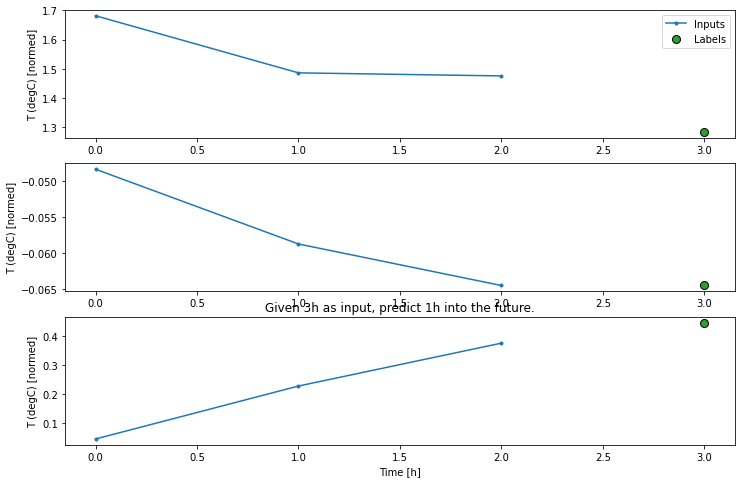

In [48]:
conv_window.plot()
plt.title("Given 3h as input, predict 1h into the future.")

You could train a `dense` model on a multiple-input-step window by adding a `layers.Flatten` as the first layer of the model:

In [49]:
multi_step_dense = tf.keras.Sequential([
    # Shape: (time, features) => (time*features)
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
    # Add back the time dimension.
    # Shape: (outputs) => (1, outputs)
    tf.keras.layers.Reshape([1, -1]),
])

In [50]:
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', multi_step_dense(conv_window.example[0]).shape)

Input shape: (32, 3, 19)
Output shape: (32, 1, 1)


In [51]:
history = compile_and_fit(multi_step_dense, conv_window)

IPython.display.clear_output()
val_performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.val)
performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.test, verbose=0)

  1/438 [..............................] - ETA: 25s - loss: 0.0058 - mean_absolute_error: 0.0569

 19/438 [>.............................] - ETA: 1s - loss: 0.0061 - mean_absolute_error: 0.0560 

 39/438 [=>............................] - ETA: 1s - loss: 0.0062 - mean_absolute_error: 0.0544

 62/438 [===>..........................] - ETA: 0s - loss: 0.0063 - mean_absolute_error: 0.0551

 84/438 [====>.........................] - ETA: 0s - loss: 0.0062 - mean_absolute_error: 0.0557

105/438 [======>.......................] - ETA: 0s - loss: 0.0062 - mean_absolute_error: 0.0555

128/438 [=======>......................] - ETA: 0s - loss: 0.0063 - mean_absolute_error: 0.0559

149/438 [=========>....................] - ETA: 0s - loss: 0.0063 - mean_absolute_error: 0.0558

168/438 [==========>...................] - ETA: 0s - loss: 0.0063 - mean_absolute_error: 0.0558

189/438 [===========>..................] - ETA: 0s - loss: 0.0063 - mean_absolute_error: 0.0557

210/438 [=============>................] - ETA: 0s - loss: 0.0063 - mean_absolute_error: 0.0558

231/438 [==============>...............] - ETA: 0s - loss: 0.0062 - mean_absolute_error: 0.0557

253/438 [================>.............] - ETA: 0s - loss: 0.0062 - mean_absolute_error: 0.0559

275/438 [=================>............] - ETA: 0s - loss: 0.0063 - mean_absolute_error: 0.0561

295/438 [===================>..........] - ETA: 0s - loss: 0.0063 - mean_absolute_error: 0.0561

314/438 [====================>.........] - ETA: 0s - loss: 0.0063 - mean_absolute_error: 0.0559

337/438 [======================>.......] - ETA: 0s - loss: 0.0062 - mean_absolute_error: 0.0558

357/438 [=======================>......] - ETA: 0s - loss: 0.0062 - mean_absolute_error: 0.0557

379/438 [========================>.....] - ETA: 0s - loss: 0.0062 - mean_absolute_error: 0.0558

402/438 [==========================>...] - ETA: 0s - loss: 0.0062 - mean_absolute_error: 0.0557

422/438 [===========================>..] - ETA: 0s - loss: 0.0062 - mean_absolute_error: 0.0558

438/438 [==============================] - 1s 2ms/step - loss: 0.0062 - mean_absolute_error: 0.0559


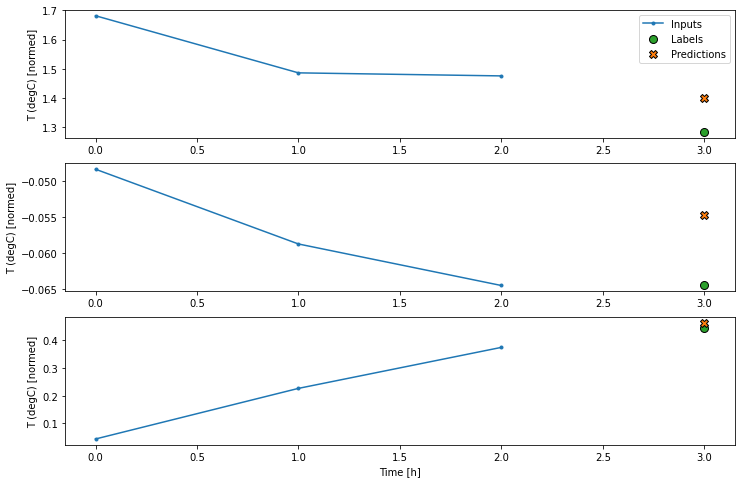

In [52]:
conv_window.plot(multi_step_dense)

The main down-side of this approach is that the resulting model can only be executed on input windows of exactly this shape. 

In [53]:
print('Input shape:', wide_window.example[0].shape)
try:
  print('Output shape:', multi_step_dense(wide_window.example[0]).shape)
except Exception as e:
  print(f'\n{type(e).__name__}:{e}')

Input shape: (32, 24, 19)

ValueError:Input 0 of layer dense_4 is incompatible with the layer: expected axis -1 of input shape to have value 57 but received input with shape (32, 456)


The convolutional models in the next section fix this problem.

### Convolution neural network
 
A convolution layer (`layers.Conv1D`) also takes multiple time steps as input to each prediction.

Below is the **same** model as `multi_step_dense`, re-written with a convolution. 

Note the changes:
* The `layers.Flatten` and the first `layers.Dense` are replaced by a `layers.Conv1D`.
* The `layers.Reshape` is no longer necessary since the convolution keeps the time axis in its output.

In [54]:
conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32,
                           kernel_size=(CONV_WIDTH,),
                           activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
])

Run it on an example batch to see that the model produces outputs with the expected shape:

In [55]:
print("Conv model on `conv_window`")
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', conv_model(conv_window.example[0]).shape)

Conv model on `conv_window`
Input shape: (32, 3, 19)
Output shape: (32, 1, 1)


Train and evaluate it on the ` conv_window` and it should give performance similar to the `multi_step_dense` model.

In [56]:
history = compile_and_fit(conv_model, conv_window)

IPython.display.clear_output()
val_performance['Conv'] = conv_model.evaluate(conv_window.val)
performance['Conv'] = conv_model.evaluate(conv_window.test, verbose=0)

  1/438 [..............................] - ETA: 27s - loss: 0.0065 - mean_absolute_error: 0.0535

 16/438 [>.............................] - ETA: 1s - loss: 0.0061 - mean_absolute_error: 0.0556 

 30/438 [=>............................] - ETA: 1s - loss: 0.0062 - mean_absolute_error: 0.0559

 45/438 [==>...........................] - ETA: 1s - loss: 0.0062 - mean_absolute_error: 0.0562

 61/438 [===>..........................] - ETA: 1s - loss: 0.0066 - mean_absolute_error: 0.0565

 77/438 [====>.........................] - ETA: 1s - loss: 0.0066 - mean_absolute_error: 0.0566

 93/438 [=====>........................] - ETA: 1s - loss: 0.0065 - mean_absolute_error: 0.0566

110/438 [======>.......................] - ETA: 1s - loss: 0.0067 - mean_absolute_error: 0.0571

125/438 [=======>......................] - ETA: 1s - loss: 0.0066 - mean_absolute_error: 0.0570

141/438 [========>.....................] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0575

157/438 [=========>....................] - ETA: 0s - loss: 0.0067 - mean_absolute_error: 0.0574

172/438 [==========>...................] - ETA: 0s - loss: 0.0067 - mean_absolute_error: 0.0572

187/438 [===========>..................] - ETA: 0s - loss: 0.0067 - mean_absolute_error: 0.0572

203/438 [============>.................] - ETA: 0s - loss: 0.0067 - mean_absolute_error: 0.0573

219/438 [==============>...............] - ETA: 0s - loss: 0.0067 - mean_absolute_error: 0.0572

234/438 [===============>..............] - ETA: 0s - loss: 0.0067 - mean_absolute_error: 0.0571

250/438 [================>.............] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0574

265/438 [=================>............] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0575

280/438 [==================>...........] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0574

295/438 [===================>..........] - ETA: 0s - loss: 0.0067 - mean_absolute_error: 0.0574

310/438 [====================>.........] - ETA: 0s - loss: 0.0067 - mean_absolute_error: 0.0575

325/438 [=====================>........] - ETA: 0s - loss: 0.0067 - mean_absolute_error: 0.0576

340/438 [======================>.......] - ETA: 0s - loss: 0.0067 - mean_absolute_error: 0.0575

356/438 [=======================>......] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0577

371/438 [========================>.....] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0577

386/438 [=========================>....] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0577

401/438 [==========================>...] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0576

415/438 [===========================>..] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0575

429/438 [============================>.] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0576

438/438 [==============================] - 2s 3ms/step - loss: 0.0068 - mean_absolute_error: 0.0576


The difference between this `conv_model` and the `multi_step_dense` model is that the `conv_model` can be run on inputs of any length. The convolutional layer is applied to a sliding window of inputs:

![Executing a convolutional model on a sequence](images/wide_conv_window.png)

If you run it on wider input, it produces wider output:

In [57]:
print("Wide window")
print('Input shape:', wide_window.example[0].shape)
print('Labels shape:', wide_window.example[1].shape)
print('Output shape:', conv_model(wide_window.example[0]).shape)

Wide window
Input shape: (32, 24, 19)
Labels shape: (32, 24, 1)
Output shape: (32, 22, 1)


Note that the output is shorter than the input. To make training or plotting work, you need the labels, and prediction to have the same length. So build a `WindowGenerator` to produce wide windows with a few extra input time steps so the label and prediction lengths match: 

In [58]:
LABEL_WIDTH = 24
INPUT_WIDTH = LABEL_WIDTH + (CONV_WIDTH - 1)
wide_conv_window = WindowGenerator(
    input_width=INPUT_WIDTH,
    label_width=LABEL_WIDTH,
    shift=1,
    label_columns=['T (degC)'])

wide_conv_window

Total window size: 27
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25]
Label indices: [ 3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26]
Label column name(s): ['T (degC)']

In [59]:
print("Wide conv window")
print('Input shape:', wide_conv_window.example[0].shape)
print('Labels shape:', wide_conv_window.example[1].shape)
print('Output shape:', conv_model(wide_conv_window.example[0]).shape)

Wide conv window
Input shape: (32, 26, 19)
Labels shape: (32, 24, 1)
Output shape: (32, 24, 1)


Now you can plot the model's predictions on a wider window. Note the 3 input time steps before the first prediction. Every prediction here is based on the 3 preceding timesteps:

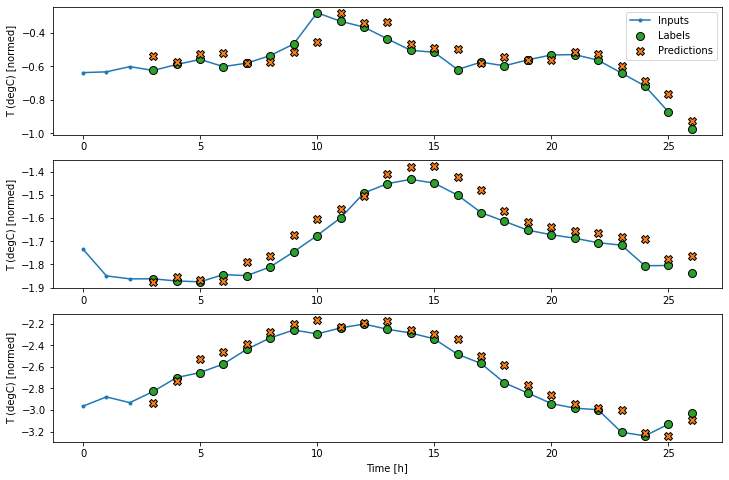

In [60]:
wide_conv_window.plot(conv_model)

### Recurrent neural network

A Recurrent Neural Network (RNN) is a type of neural network well-suited to time series data. RNNs process a time series step-by-step, maintaining an internal state from time-step to time-step.

For more details, read the [text generation tutorial](https://www.tensorflow.org/tutorials/text/text_generation) or the [RNN guide](https://www.tensorflow.org/guide/keras/rnn). 

In this tutorial, you will use an RNN layer called Long Short Term Memory ([LSTM](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/layers/LSTM)).

An important constructor argument for all keras RNN layers is the `return_sequences` argument. This setting can configure the layer in one of two ways.

1. If `False`, the default, the layer only returns the output of the final timestep, giving the model time to warm up its internal state before making a single prediction: 

![An lstm warming up and making a single prediction](images/lstm_1_window.png)

2. If `True` the layer returns an output for each input. This is useful for:
  * Stacking RNN layers. 
  * Training a model on multiple timesteps simultaneously.

![An lstm making a prediction after every timestep](images/lstm_many_window.png)

In [61]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

With `return_sequences=True` the model can be trained on 24h of data at a time.

Note: This will give a pessimistic view of the model's performance. On the first timestep the model has no access to previous steps, and so can't do any better than the simple `linear` and `dense` models shown earlier.

In [62]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', lstm_model(wide_window.example[0]).shape)

Input shape: (32, 24, 19)


Output shape: (32, 24, 1)


In [63]:
history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0)

  1/438 [..............................] - ETA: 26s - loss: 0.0052 - mean_absolute_error: 0.0520

 13/438 [..............................] - ETA: 1s - loss: 0.0055 - mean_absolute_error: 0.0511 

 26/438 [>.............................] - ETA: 1s - loss: 0.0055 - mean_absolute_error: 0.0509

 38/438 [=>............................] - ETA: 1s - loss: 0.0055 - mean_absolute_error: 0.0510

 51/438 [==>...........................] - ETA: 1s - loss: 0.0055 - mean_absolute_error: 0.0509

 63/438 [===>..........................] - ETA: 1s - loss: 0.0055 - mean_absolute_error: 0.0508

 76/438 [====>.........................] - ETA: 1s - loss: 0.0055 - mean_absolute_error: 0.0508

 89/438 [=====>........................] - ETA: 1s - loss: 0.0055 - mean_absolute_error: 0.0509

102/438 [=====>........................] - ETA: 1s - loss: 0.0055 - mean_absolute_error: 0.0509

114/438 [======>.......................] - ETA: 1s - loss: 0.0056 - mean_absolute_error: 0.0510

127/438 [=======>......................] - ETA: 1s - loss: 0.0055 - mean_absolute_error: 0.0509

139/438 [========>.....................] - ETA: 1s - loss: 0.0055 - mean_absolute_error: 0.0508

152/438 [=========>....................] - ETA: 1s - loss: 0.0055 - mean_absolute_error: 0.0509

165/438 [==========>...................] - ETA: 1s - loss: 0.0055 - mean_absolute_error: 0.0510

178/438 [===========>..................] - ETA: 1s - loss: 0.0055 - mean_absolute_error: 0.0510

191/438 [============>.................] - ETA: 1s - loss: 0.0055 - mean_absolute_error: 0.0509

203/438 [============>.................] - ETA: 0s - loss: 0.0055 - mean_absolute_error: 0.0510

216/438 [=============>................] - ETA: 0s - loss: 0.0055 - mean_absolute_error: 0.0510

229/438 [==============>...............] - ETA: 0s - loss: 0.0055 - mean_absolute_error: 0.0511

242/438 [===============>..............] - ETA: 0s - loss: 0.0055 - mean_absolute_error: 0.0510

255/438 [================>.............] - ETA: 0s - loss: 0.0055 - mean_absolute_error: 0.0511

268/438 [=================>............] - ETA: 0s - loss: 0.0055 - mean_absolute_error: 0.0511

281/438 [==================>...........] - ETA: 0s - loss: 0.0055 - mean_absolute_error: 0.0511

294/438 [===================>..........] - ETA: 0s - loss: 0.0055 - mean_absolute_error: 0.0510

307/438 [====================>.........] - ETA: 0s - loss: 0.0055 - mean_absolute_error: 0.0510

320/438 [====================>.........] - ETA: 0s - loss: 0.0055 - mean_absolute_error: 0.0511

332/438 [=====================>........] - ETA: 0s - loss: 0.0055 - mean_absolute_error: 0.0510

345/438 [======================>.......] - ETA: 0s - loss: 0.0055 - mean_absolute_error: 0.0510

358/438 [=======================>......] - ETA: 0s - loss: 0.0055 - mean_absolute_error: 0.0510

371/438 [========================>.....] - ETA: 0s - loss: 0.0055 - mean_absolute_error: 0.0510

384/438 [=========================>....] - ETA: 0s - loss: 0.0055 - mean_absolute_error: 0.0510

396/438 [==========================>...] - ETA: 0s - loss: 0.0055 - mean_absolute_error: 0.0510

409/438 [===========================>..] - ETA: 0s - loss: 0.0055 - mean_absolute_error: 0.0510

421/438 [===========================>..] - ETA: 0s - loss: 0.0055 - mean_absolute_error: 0.0510

435/438 [============================>.] - ETA: 0s - loss: 0.0055 - mean_absolute_error: 0.0509

438/438 [==============================] - 2s 4ms/step - loss: 0.0055 - mean_absolute_error: 0.0509


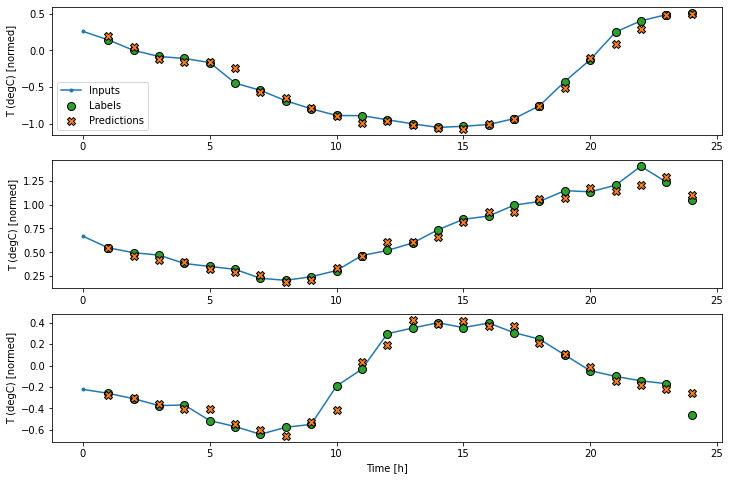

In [64]:
wide_window.plot(lstm_model)

### Performance

With this dataset typically each of the models does slightly better than the one before it.

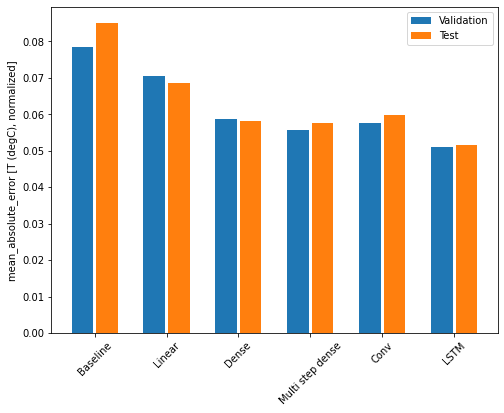

In [65]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.ylabel('mean_absolute_error [T (degC), normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()

In [66]:
for name, value in performance.items():
  print(f'{name:12s}: {value[1]:0.4f}')

Baseline    : 0.0852
Linear      : 0.0686
Dense       : 0.0581
Multi step dense: 0.0577
Conv        : 0.0598
LSTM        : 0.0516


### Multi-output models

The models so far all predicted a single output feature, `T (degC)`, for a single time step.

All of these models can be converted to predict multiple features just by changing the number of units in the output layer and adjusting the training windows to include all features in the `labels`.


In [67]:
single_step_window = WindowGenerator(
    # `WindowGenerator` returns all features as labels if you 
    # don't set the `label_columns` argument.
    input_width=1, label_width=1, shift=1)

wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1)

for example_inputs, example_labels in wide_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 24, 19)
Labels shape (batch, time, features): (32, 24, 19)


Note above that the `features` axis of the labels now has the same depth as the inputs, instead of 1.

#### Baseline

The same baseline model can be used here, but this time repeating all features instead of selecting a specific `label_index`.

In [68]:
baseline = Baseline()
baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError()])

In [69]:
val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(wide_window.val)
performance['Baseline'] = baseline.evaluate(wide_window.test, verbose=0)

  1/438 [..............................] - ETA: 47s - loss: 0.0788 - mean_absolute_error: 0.1566

 24/438 [>.............................] - ETA: 0s - loss: 0.0862 - mean_absolute_error: 0.1585 

 46/438 [==>...........................] - ETA: 0s - loss: 0.0869 - mean_absolute_error: 0.1586

 68/438 [===>..........................] - ETA: 0s - loss: 0.0875 - mean_absolute_error: 0.1590

 90/438 [=====>........................] - ETA: 0s - loss: 0.0877 - mean_absolute_error: 0.1590

113/438 [======>.......................] - ETA: 0s - loss: 0.0878 - mean_absolute_error: 0.1590

135/438 [========>.....................] - ETA: 0s - loss: 0.0878 - mean_absolute_error: 0.1589

157/438 [=========>....................] - ETA: 0s - loss: 0.0879 - mean_absolute_error: 0.1589

179/438 [===========>..................] - ETA: 0s - loss: 0.0879 - mean_absolute_error: 0.1589

202/438 [============>.................] - ETA: 0s - loss: 0.0880 - mean_absolute_error: 0.1589

225/438 [==============>...............] - ETA: 0s - loss: 0.0880 - mean_absolute_error: 0.1589

248/438 [===============>..............] - ETA: 0s - loss: 0.0880 - mean_absolute_error: 0.1589

270/438 [=================>............] - ETA: 0s - loss: 0.0881 - mean_absolute_error: 0.1589

293/438 [===================>..........] - ETA: 0s - loss: 0.0881 - mean_absolute_error: 0.1589

315/438 [====================>.........] - ETA: 0s - loss: 0.0881 - mean_absolute_error: 0.1589

338/438 [======================>.......] - ETA: 0s - loss: 0.0882 - mean_absolute_error: 0.1589

361/438 [=======================>......] - ETA: 0s - loss: 0.0882 - mean_absolute_error: 0.1589

383/438 [=========================>....] - ETA: 0s - loss: 0.0882 - mean_absolute_error: 0.1589

406/438 [==========================>...] - ETA: 0s - loss: 0.0882 - mean_absolute_error: 0.1589

429/438 [============================>.] - ETA: 0s - loss: 0.0883 - mean_absolute_error: 0.1589

438/438 [==============================] - 1s 2ms/step - loss: 0.0883 - mean_absolute_error: 0.1589


#### Dense

In [70]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=num_features)
])

In [71]:
history = compile_and_fit(dense, single_step_window)

IPython.display.clear_output()
val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)

  1/439 [..............................] - ETA: 26s - loss: 0.0680 - mean_absolute_error: 0.1319

 16/439 [>.............................] - ETA: 1s - loss: 0.0721 - mean_absolute_error: 0.1369 

 30/439 [=>............................] - ETA: 1s - loss: 0.0698 - mean_absolute_error: 0.1355

 45/439 [==>...........................] - ETA: 1s - loss: 0.0718 - mean_absolute_error: 0.1356

 60/439 [===>..........................] - ETA: 1s - loss: 0.0728 - mean_absolute_error: 0.1353

 75/439 [====>.........................] - ETA: 1s - loss: 0.0714 - mean_absolute_error: 0.1349

 90/439 [=====>........................] - ETA: 1s - loss: 0.0702 - mean_absolute_error: 0.1343

105/439 [======>.......................] - ETA: 1s - loss: 0.0683 - mean_absolute_error: 0.1329

120/439 [=======>......................] - ETA: 1s - loss: 0.0678 - mean_absolute_error: 0.1328

136/439 [========>.....................] - ETA: 1s - loss: 0.0671 - mean_absolute_error: 0.1323

151/439 [=========>....................] - ETA: 0s - loss: 0.0662 - mean_absolute_error: 0.1318

167/439 [==========>...................] - ETA: 0s - loss: 0.0663 - mean_absolute_error: 0.1319

182/439 [===========>..................] - ETA: 0s - loss: 0.0670 - mean_absolute_error: 0.1326

197/439 [============>.................] - ETA: 0s - loss: 0.0672 - mean_absolute_error: 0.1328

212/439 [=============>................] - ETA: 0s - loss: 0.0671 - mean_absolute_error: 0.1328

226/439 [==============>...............] - ETA: 0s - loss: 0.0681 - mean_absolute_error: 0.1332

241/439 [===============>..............] - ETA: 0s - loss: 0.0680 - mean_absolute_error: 0.1330

255/439 [================>.............] - ETA: 0s - loss: 0.0684 - mean_absolute_error: 0.1333

268/439 [=================>............] - ETA: 0s - loss: 0.0687 - mean_absolute_error: 0.1337

283/439 [==================>...........] - ETA: 0s - loss: 0.0686 - mean_absolute_error: 0.1338

298/439 [===================>..........] - ETA: 0s - loss: 0.0687 - mean_absolute_error: 0.1339

312/439 [====================>.........] - ETA: 0s - loss: 0.0686 - mean_absolute_error: 0.1339

327/439 [=====================>........] - ETA: 0s - loss: 0.0687 - mean_absolute_error: 0.1340

341/439 [======================>.......] - ETA: 0s - loss: 0.0683 - mean_absolute_error: 0.1338

356/439 [=======================>......] - ETA: 0s - loss: 0.0686 - mean_absolute_error: 0.1340

370/439 [========================>.....] - ETA: 0s - loss: 0.0685 - mean_absolute_error: 0.1340

385/439 [=========================>....] - ETA: 0s - loss: 0.0687 - mean_absolute_error: 0.1341

402/439 [==========================>...] - ETA: 0s - loss: 0.0687 - mean_absolute_error: 0.1340

419/439 [===========================>..] - ETA: 0s - loss: 0.0687 - mean_absolute_error: 0.1341

433/439 [============================>.] - ETA: 0s - loss: 0.0687 - mean_absolute_error: 0.1340

439/439 [==============================] - 2s 3ms/step - loss: 0.0687 - mean_absolute_error: 0.1342


#### RNN


In [72]:
%%time
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1)

lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=num_features)
])

history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate( wide_window.val)
performance['LSTM'] = lstm_model.evaluate( wide_window.test, verbose=0)

print()

  1/438 [..............................] - ETA: 24s - loss: 0.0658 - mean_absolute_error: 0.1229

 14/438 [..............................] - ETA: 1s - loss: 0.0628 - mean_absolute_error: 0.1205 

 28/438 [>.............................] - ETA: 1s - loss: 0.0623 - mean_absolute_error: 0.1205

 43/438 [=>............................] - ETA: 1s - loss: 0.0619 - mean_absolute_error: 0.1198

 57/438 [==>...........................] - ETA: 1s - loss: 0.0615 - mean_absolute_error: 0.1198

 71/438 [===>..........................] - ETA: 1s - loss: 0.0619 - mean_absolute_error: 0.1202

 87/438 [====>.........................] - ETA: 1s - loss: 0.0614 - mean_absolute_error: 0.1199

101/438 [=====>........................] - ETA: 1s - loss: 0.0613 - mean_absolute_error: 0.1197

115/438 [======>.......................] - ETA: 1s - loss: 0.0614 - mean_absolute_error: 0.1199

129/438 [=======>......................] - ETA: 1s - loss: 0.0612 - mean_absolute_error: 0.1198

143/438 [========>.....................] - ETA: 1s - loss: 0.0613 - mean_absolute_error: 0.1197

157/438 [=========>....................] - ETA: 1s - loss: 0.0611 - mean_absolute_error: 0.1195

172/438 [==========>...................] - ETA: 0s - loss: 0.0610 - mean_absolute_error: 0.1194

186/438 [===========>..................] - ETA: 0s - loss: 0.0609 - mean_absolute_error: 0.1193

200/438 [============>.................] - ETA: 0s - loss: 0.0610 - mean_absolute_error: 0.1194

215/438 [=============>................] - ETA: 0s - loss: 0.0610 - mean_absolute_error: 0.1193

229/438 [==============>...............] - ETA: 0s - loss: 0.0609 - mean_absolute_error: 0.1193

243/438 [===============>..............] - ETA: 0s - loss: 0.0610 - mean_absolute_error: 0.1194

255/438 [================>.............] - ETA: 0s - loss: 0.0612 - mean_absolute_error: 0.1196

269/438 [=================>............] - ETA: 0s - loss: 0.0612 - mean_absolute_error: 0.1195

283/438 [==================>...........] - ETA: 0s - loss: 0.0613 - mean_absolute_error: 0.1196

298/438 [===================>..........] - ETA: 0s - loss: 0.0612 - mean_absolute_error: 0.1195

312/438 [====================>.........] - ETA: 0s - loss: 0.0613 - mean_absolute_error: 0.1196

326/438 [=====================>........] - ETA: 0s - loss: 0.0612 - mean_absolute_error: 0.1195

341/438 [======================>.......] - ETA: 0s - loss: 0.0613 - mean_absolute_error: 0.1196

356/438 [=======================>......] - ETA: 0s - loss: 0.0614 - mean_absolute_error: 0.1197

370/438 [========================>.....] - ETA: 0s - loss: 0.0613 - mean_absolute_error: 0.1196

385/438 [=========================>....] - ETA: 0s - loss: 0.0613 - mean_absolute_error: 0.1197

400/438 [==========================>...] - ETA: 0s - loss: 0.0614 - mean_absolute_error: 0.1197

414/438 [===========================>..] - ETA: 0s - loss: 0.0615 - mean_absolute_error: 0.1198

429/438 [============================>.] - ETA: 0s - loss: 0.0614 - mean_absolute_error: 0.1197

438/438 [==============================] - 2s 4ms/step - loss: 0.0614 - mean_absolute_error: 0.1198



CPU times: user 6min 10s, sys: 1min 25s, total: 7min 35s
Wall time: 2min 55s


<a id="residual"></a>

#### Advanced: Residual connections

The `Baseline` model from earlier took advantage of the fact that the sequence doesn't change drastically from time step to time step. Every model trained in this tutorial so far was randomly initialized, and then had to learn that the output is a a small change from the previous time step.

While you can get around this issue with careful initialization, it's  simpler to build this into the model structure.

It's common in time series analysis to build models that instead of predicting the next value, predict how the value will change in the next timestep.
Similarly, "Residual networks" or "ResNets" in deep learning refer to architectures where each layer adds to the model's accumulating result.

That is how you take advantage of the knowledge that the change should be small.

![A model with a residual connection](images/residual.png)

Essentially this initializes the model to match the `Baseline`. For this task it helps models converge faster, with slightly better performance.

This approach can be used in conjunction with any model discussed in this tutorial. 

Here it is being applied to the LSTM model, note the use of the `tf.initializers.zeros` to ensure that the initial predicted changes are small, and don't overpower the residual connection. There are no symmetry-breaking concerns for the gradients here, since the `zeros` are only used on the last layer.

In [73]:
class ResidualWrapper(tf.keras.Model):
  def __init__(self, model):
    super().__init__()
    self.model = model

  def call(self, inputs, *args, **kwargs):
    delta = self.model(inputs, *args, **kwargs)

    # The prediction for each timestep is the input
    # from the previous time step plus the delta
    # calculated by the model.
    return inputs + delta

In [74]:
%%time
residual_lstm = ResidualWrapper(
    tf.keras.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.Dense(
        num_features,
        # The predicted deltas should start small
        # So initialize the output layer with zeros
        kernel_initializer=tf.initializers.zeros)
]))

history = compile_and_fit(residual_lstm, wide_window)

IPython.display.clear_output()
val_performance['Residual LSTM'] = residual_lstm.evaluate(wide_window.val)
performance['Residual LSTM'] = residual_lstm.evaluate(wide_window.test, verbose=0)
print()

  1/438 [..............................] - ETA: 23s - loss: 0.0580 - mean_absolute_error: 0.1119

 17/438 [>.............................] - ETA: 1s - loss: 0.0633 - mean_absolute_error: 0.1181 

 33/438 [=>............................] - ETA: 1s - loss: 0.0627 - mean_absolute_error: 0.1179

 49/438 [==>...........................] - ETA: 1s - loss: 0.0626 - mean_absolute_error: 0.1181

 65/438 [===>..........................] - ETA: 1s - loss: 0.0624 - mean_absolute_error: 0.1177

 81/438 [====>.........................] - ETA: 1s - loss: 0.0623 - mean_absolute_error: 0.1177

 97/438 [=====>........................] - ETA: 1s - loss: 0.0620 - mean_absolute_error: 0.1175

113/438 [======>.......................] - ETA: 1s - loss: 0.0624 - mean_absolute_error: 0.1180

129/438 [=======>......................] - ETA: 0s - loss: 0.0622 - mean_absolute_error: 0.1177

145/438 [========>.....................] - ETA: 0s - loss: 0.0622 - mean_absolute_error: 0.1178

161/438 [==========>...................] - ETA: 0s - loss: 0.0621 - mean_absolute_error: 0.1177

177/438 [===========>..................] - ETA: 0s - loss: 0.0619 - mean_absolute_error: 0.1176

193/438 [============>.................] - ETA: 0s - loss: 0.0619 - mean_absolute_error: 0.1177

209/438 [=============>................] - ETA: 0s - loss: 0.0620 - mean_absolute_error: 0.1178

225/438 [==============>...............] - ETA: 0s - loss: 0.0622 - mean_absolute_error: 0.1179

241/438 [===============>..............] - ETA: 0s - loss: 0.0622 - mean_absolute_error: 0.1180

257/438 [================>.............] - ETA: 0s - loss: 0.0622 - mean_absolute_error: 0.1180

273/438 [=================>............] - ETA: 0s - loss: 0.0623 - mean_absolute_error: 0.1180

289/438 [==================>...........] - ETA: 0s - loss: 0.0623 - mean_absolute_error: 0.1180

305/438 [===================>..........] - ETA: 0s - loss: 0.0624 - mean_absolute_error: 0.1181

321/438 [====================>.........] - ETA: 0s - loss: 0.0624 - mean_absolute_error: 0.1181

337/438 [======================>.......] - ETA: 0s - loss: 0.0625 - mean_absolute_error: 0.1182

353/438 [=======================>......] - ETA: 0s - loss: 0.0624 - mean_absolute_error: 0.1181

369/438 [========================>.....] - ETA: 0s - loss: 0.0624 - mean_absolute_error: 0.1181

385/438 [=========================>....] - ETA: 0s - loss: 0.0624 - mean_absolute_error: 0.1181

401/438 [==========================>...] - ETA: 0s - loss: 0.0623 - mean_absolute_error: 0.1181

418/438 [===========================>..] - ETA: 0s - loss: 0.0623 - mean_absolute_error: 0.1180

432/438 [============================>.] - ETA: 0s - loss: 0.0623 - mean_absolute_error: 0.1180

438/438 [==============================] - 1s 3ms/step - loss: 0.0623 - mean_absolute_error: 0.1180



CPU times: user 2min 25s, sys: 34.6 s, total: 3min
Wall time: 1min 7s


#### Performance

Here is the overall performance for these multi-output models.

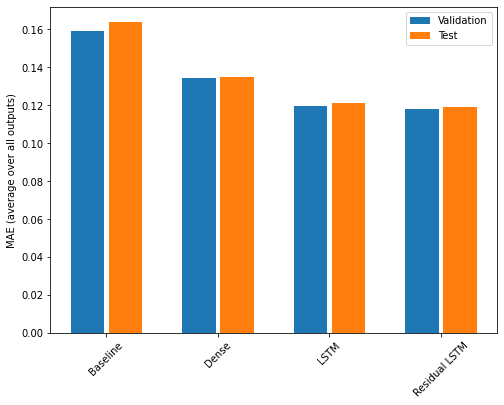

In [75]:
x = np.arange(len(performance))
width = 0.3

metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
plt.ylabel('MAE (average over all outputs)')
_ = plt.legend()

In [76]:
for name, value in performance.items():
  print(f'{name:15s}: {value[1]:0.4f}')

Baseline       : 0.1638
Dense          : 0.1349
LSTM           : 0.1214
Residual LSTM  : 0.1192


The above performances are averaged across all model outputs.

## Multi-step models

Both the single-output and multiple-output models in the previous sections made **single time step predictions**, 1h into the future.

This section looks at how to expand these models to make **multiple time step predictions**.

In a multi-step prediction, the model needs to learn to predict a range of future values. Thus, unlike a single step model, where only a single future point is predicted, a multi-step model predicts a sequence of the future values.

There are two rough approaches to this:

1. Single shot predictions where the entire time series is predicted at once.
2. Autoregressive predictions where the model only makes single step predictions and its output is fed back as its input.

In this section all the models will predict **all the features across all output time steps**.


For the multi-step model, the training data again consists of hourly samples. However, here, the models will learn to predict 24h of the future, given 24h of the past.

Here is a `Window` object that generates these slices from the dataset:

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
Label column name(s): None

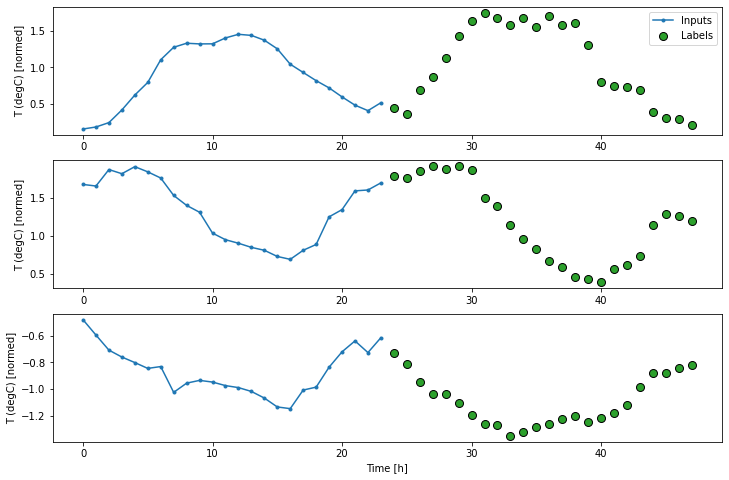

In [77]:
OUT_STEPS = 24
multi_window = WindowGenerator(input_width=24,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS)

multi_window.plot()
multi_window

### Baselines

A simple baseline for this task is to repeat the last input time step for the required number of output timesteps:

![Repeat the last input, for each output step](images/multistep_last.png)

  1/437 [..............................] - ETA: 56s - loss: 0.6564 - mean_absolute_error: 0.5143

 25/437 [>.............................] - ETA: 0s - loss: 0.6290 - mean_absolute_error: 0.5026 

 49/437 [==>...........................] - ETA: 0s - loss: 0.6239 - mean_absolute_error: 0.4997

 74/437 [====>.........................] - ETA: 0s - loss: 0.6239 - mean_absolute_error: 0.4996

 98/437 [=====>........................] - ETA: 0s - loss: 0.6241 - mean_absolute_error: 0.4994

122/437 [=======>......................] - ETA: 0s - loss: 0.6252 - mean_absolute_error: 0.4997

146/437 [=========>....................] - ETA: 0s - loss: 0.6261 - mean_absolute_error: 0.4999

170/437 [==========>...................] - ETA: 0s - loss: 0.6266 - mean_absolute_error: 0.4999

195/437 [============>.................] - ETA: 0s - loss: 0.6269 - mean_absolute_error: 0.4998

219/437 [==============>...............] - ETA: 0s - loss: 0.6270 - mean_absolute_error: 0.4998

243/437 [===============>..............] - ETA: 0s - loss: 0.6273 - mean_absolute_error: 0.4998

267/437 [=================>............] - ETA: 0s - loss: 0.6276 - mean_absolute_error: 0.5000

291/437 [==================>...........] - ETA: 0s - loss: 0.6277 - mean_absolute_error: 0.5000

315/437 [====================>.........] - ETA: 0s - loss: 0.6277 - mean_absolute_error: 0.5000

338/437 [======================>.......] - ETA: 0s - loss: 0.6278 - mean_absolute_error: 0.5001

361/437 [=======================>......] - ETA: 0s - loss: 0.6278 - mean_absolute_error: 0.5001

385/437 [=========================>....] - ETA: 0s - loss: 0.6278 - mean_absolute_error: 0.5001

408/437 [===========================>..] - ETA: 0s - loss: 0.6278 - mean_absolute_error: 0.5001

430/437 [============================>.] - ETA: 0s - loss: 0.6278 - mean_absolute_error: 0.5001

437/437 [==============================] - 1s 2ms/step - loss: 0.6279 - mean_absolute_error: 0.5001


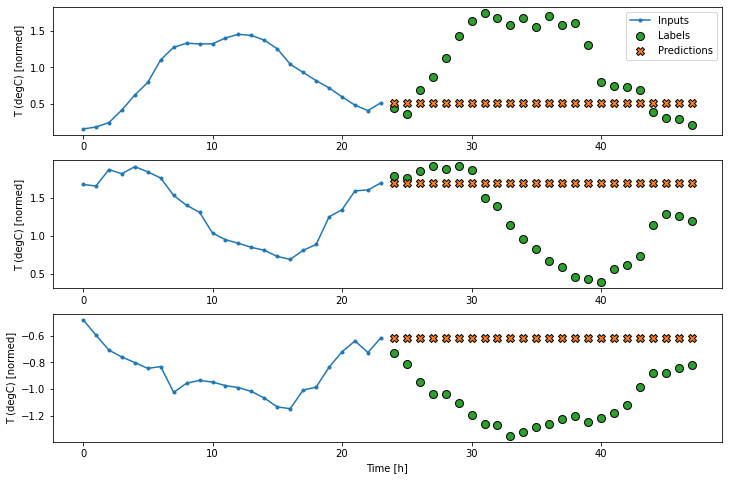

In [78]:
class MultiStepLastBaseline(tf.keras.Model):
  def call(self, inputs):
    return tf.tile(inputs[:, -1:, :], [1, OUT_STEPS, 1])

last_baseline = MultiStepLastBaseline()
last_baseline.compile(loss=tf.losses.MeanSquaredError(),
                      metrics=[tf.metrics.MeanAbsoluteError()])

multi_val_performance = {}
multi_performance = {}

multi_val_performance['Last'] = last_baseline.evaluate(multi_window.val)
multi_performance['Last'] = last_baseline.evaluate(multi_window.test, verbose=0)
multi_window.plot(last_baseline)

Since this task is to predict 24h given 24h another simple approach is to repeat the previous day, assuming tomorrow will be similar:

![Repeat the previous day](images/multistep_repeat.png)

  1/437 [..............................] - ETA: 52s - loss: 0.3929 - mean_absolute_error: 0.3897

 22/437 [>.............................] - ETA: 1s - loss: 0.4216 - mean_absolute_error: 0.3951 

 44/437 [==>...........................] - ETA: 0s - loss: 0.4275 - mean_absolute_error: 0.3969

 65/437 [===>..........................] - ETA: 0s - loss: 0.4290 - mean_absolute_error: 0.3973

 86/437 [====>.........................] - ETA: 0s - loss: 0.4294 - mean_absolute_error: 0.3972

106/437 [======>.......................] - ETA: 0s - loss: 0.4296 - mean_absolute_error: 0.3972

127/437 [=======>......................] - ETA: 0s - loss: 0.4296 - mean_absolute_error: 0.3971

147/437 [=========>....................] - ETA: 0s - loss: 0.4292 - mean_absolute_error: 0.3968

167/437 [==========>...................] - ETA: 0s - loss: 0.4284 - mean_absolute_error: 0.3964

187/437 [===========>..................] - ETA: 0s - loss: 0.4277 - mean_absolute_error: 0.3961

207/437 [=============>................] - ETA: 0s - loss: 0.4272 - mean_absolute_error: 0.3959

227/437 [==============>...............] - ETA: 0s - loss: 0.4268 - mean_absolute_error: 0.3958

247/437 [===============>..............] - ETA: 0s - loss: 0.4266 - mean_absolute_error: 0.3957

267/437 [=================>............] - ETA: 0s - loss: 0.4265 - mean_absolute_error: 0.3956

286/437 [==================>...........] - ETA: 0s - loss: 0.4264 - mean_absolute_error: 0.3956

306/437 [====================>.........] - ETA: 0s - loss: 0.4263 - mean_absolute_error: 0.3956

325/437 [=====================>........] - ETA: 0s - loss: 0.4262 - mean_absolute_error: 0.3955

345/437 [======================>.......] - ETA: 0s - loss: 0.4262 - mean_absolute_error: 0.3955

364/437 [=======================>......] - ETA: 0s - loss: 0.4262 - mean_absolute_error: 0.3955

384/437 [=========================>....] - ETA: 0s - loss: 0.4261 - mean_absolute_error: 0.3955

404/437 [==========================>...] - ETA: 0s - loss: 0.4262 - mean_absolute_error: 0.3955

424/437 [============================>.] - ETA: 0s - loss: 0.4262 - mean_absolute_error: 0.3955

437/437 [==============================] - 1s 3ms/step - loss: 0.4262 - mean_absolute_error: 0.3955


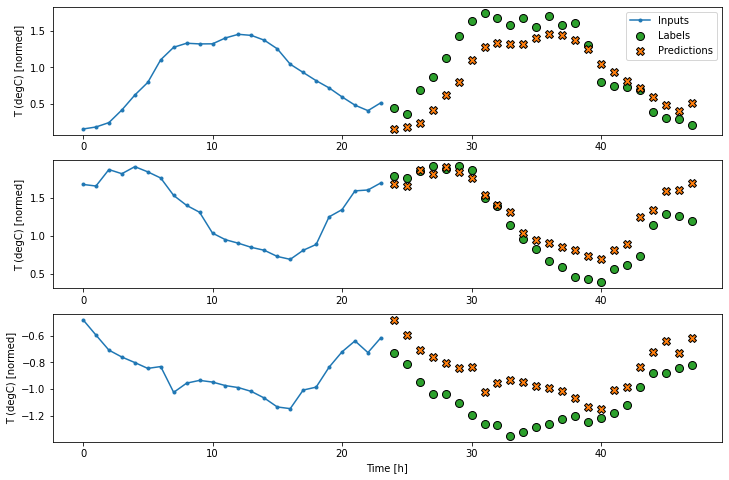

In [79]:
class RepeatBaseline(tf.keras.Model):
  def call(self, inputs):
    return inputs

repeat_baseline = RepeatBaseline()
repeat_baseline.compile(loss=tf.losses.MeanSquaredError(),
                        metrics=[tf.metrics.MeanAbsoluteError()])

multi_val_performance['Repeat'] = repeat_baseline.evaluate(multi_window.val)
multi_performance['Repeat'] = repeat_baseline.evaluate(multi_window.test, verbose=0)
multi_window.plot(repeat_baseline)

### Single-shot models

One high level approach to this problem is use a "single-shot" model, where the model makes the entire sequence prediction in a single step.

This can be implemented efficiently as a `layers.Dense` with `OUT_STEPS*features` output units. The model just needs to reshape that output to the required `(OUTPUT_STEPS, features)`.

#### Linear

A simple linear model based on the last input time step does better than either baseline, but is underpowered. The model needs to predict `OUTPUT_STEPS` time steps, from a single input time step with a linear projection. It can only capture a low-dimensional slice of the behavior, likely based mainly on the time of day and time of year.

![Predct all timesteps from the last time-step](images/multistep_dense.png)

  1/437 [..............................] - ETA: 22s - loss: 0.3004 - mean_absolute_error: 0.3432

 22/437 [>.............................] - ETA: 1s - loss: 0.2598 - mean_absolute_error: 0.3083 

 43/437 [=>............................] - ETA: 0s - loss: 0.2606 - mean_absolute_error: 0.3066

 64/437 [===>..........................] - ETA: 0s - loss: 0.2617 - mean_absolute_error: 0.3074

 85/437 [====>.........................] - ETA: 0s - loss: 0.2594 - mean_absolute_error: 0.3059

106/437 [======>.......................] - ETA: 0s - loss: 0.2567 - mean_absolute_error: 0.3045

127/437 [=======>......................] - ETA: 0s - loss: 0.2562 - mean_absolute_error: 0.3046

148/437 [=========>....................] - ETA: 0s - loss: 0.2550 - mean_absolute_error: 0.3041

169/437 [==========>...................] - ETA: 0s - loss: 0.2560 - mean_absolute_error: 0.3047

190/437 [============>.................] - ETA: 0s - loss: 0.2567 - mean_absolute_error: 0.3050

211/437 [=============>................] - ETA: 0s - loss: 0.2568 - mean_absolute_error: 0.3053

232/437 [==============>...............] - ETA: 0s - loss: 0.2559 - mean_absolute_error: 0.3048

253/437 [================>.............] - ETA: 0s - loss: 0.2557 - mean_absolute_error: 0.3046

273/437 [=================>............] - ETA: 0s - loss: 0.2559 - mean_absolute_error: 0.3047

294/437 [===================>..........] - ETA: 0s - loss: 0.2561 - mean_absolute_error: 0.3050

315/437 [====================>.........] - ETA: 0s - loss: 0.2565 - mean_absolute_error: 0.3053

336/437 [======================>.......] - ETA: 0s - loss: 0.2562 - mean_absolute_error: 0.3052

357/437 [=======================>......] - ETA: 0s - loss: 0.2564 - mean_absolute_error: 0.3052

378/437 [========================>.....] - ETA: 0s - loss: 0.2561 - mean_absolute_error: 0.3051

399/437 [==========================>...] - ETA: 0s - loss: 0.2564 - mean_absolute_error: 0.3053

420/437 [===========================>..] - ETA: 0s - loss: 0.2557 - mean_absolute_error: 0.3048

437/437 [==============================] - 1s 2ms/step - loss: 0.2559 - mean_absolute_error: 0.3049


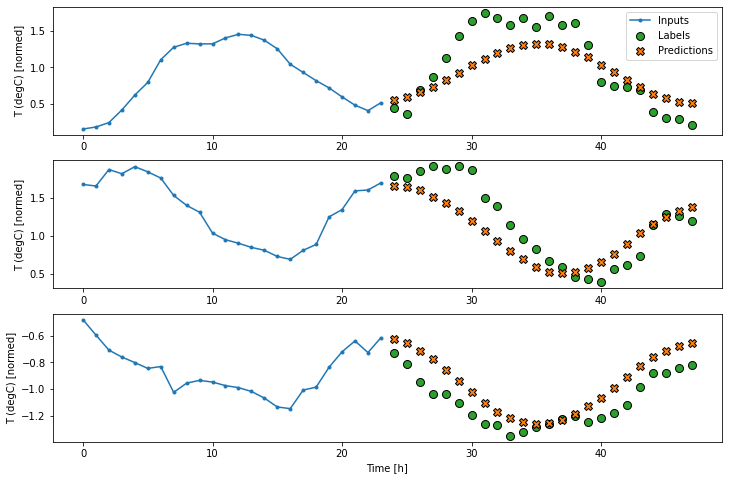

In [80]:
multi_linear_model = tf.keras.Sequential([
    # Take the last time-step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_linear_model, multi_window)

IPython.display.clear_output()
multi_val_performance['Linear'] = multi_linear_model.evaluate(multi_window.val)
multi_performance['Linear'] = multi_linear_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_linear_model)

#### Dense

Adding a `layers.Dense` between the input and output gives the linear model more power, but is still only based on a single input timestep.

  1/437 [..............................] - ETA: 25s - loss: 0.2271 - mean_absolute_error: 0.2931

 18/437 [>.............................] - ETA: 1s - loss: 0.2206 - mean_absolute_error: 0.2828 

 36/437 [=>............................] - ETA: 1s - loss: 0.2221 - mean_absolute_error: 0.2832

 54/437 [==>...........................] - ETA: 1s - loss: 0.2199 - mean_absolute_error: 0.2819

 72/437 [===>..........................] - ETA: 1s - loss: 0.2214 - mean_absolute_error: 0.2819

 90/437 [=====>........................] - ETA: 1s - loss: 0.2203 - mean_absolute_error: 0.2818

108/437 [======>.......................] - ETA: 0s - loss: 0.2203 - mean_absolute_error: 0.2819

125/437 [=======>......................] - ETA: 0s - loss: 0.2193 - mean_absolute_error: 0.2816

142/437 [========>.....................] - ETA: 0s - loss: 0.2205 - mean_absolute_error: 0.2825

159/437 [=========>....................] - ETA: 0s - loss: 0.2199 - mean_absolute_error: 0.2824

176/437 [===========>..................] - ETA: 0s - loss: 0.2199 - mean_absolute_error: 0.2824

194/437 [============>.................] - ETA: 0s - loss: 0.2190 - mean_absolute_error: 0.2820

212/437 [=============>................] - ETA: 0s - loss: 0.2191 - mean_absolute_error: 0.2820

230/437 [==============>...............] - ETA: 0s - loss: 0.2192 - mean_absolute_error: 0.2821

247/437 [===============>..............] - ETA: 0s - loss: 0.2194 - mean_absolute_error: 0.2822

264/437 [=================>............] - ETA: 0s - loss: 0.2194 - mean_absolute_error: 0.2823

282/437 [==================>...........] - ETA: 0s - loss: 0.2188 - mean_absolute_error: 0.2820

299/437 [===================>..........] - ETA: 0s - loss: 0.2184 - mean_absolute_error: 0.2818

316/437 [====================>.........] - ETA: 0s - loss: 0.2184 - mean_absolute_error: 0.2817

333/437 [=====================>........] - ETA: 0s - loss: 0.2181 - mean_absolute_error: 0.2816

351/437 [=======================>......] - ETA: 0s - loss: 0.2183 - mean_absolute_error: 0.2817

368/437 [========================>.....] - ETA: 0s - loss: 0.2186 - mean_absolute_error: 0.2819

386/437 [=========================>....] - ETA: 0s - loss: 0.2186 - mean_absolute_error: 0.2819

404/437 [==========================>...] - ETA: 0s - loss: 0.2191 - mean_absolute_error: 0.2822

422/437 [===========================>..] - ETA: 0s - loss: 0.2194 - mean_absolute_error: 0.2824

437/437 [==============================] - 1s 3ms/step - loss: 0.2190 - mean_absolute_error: 0.2821


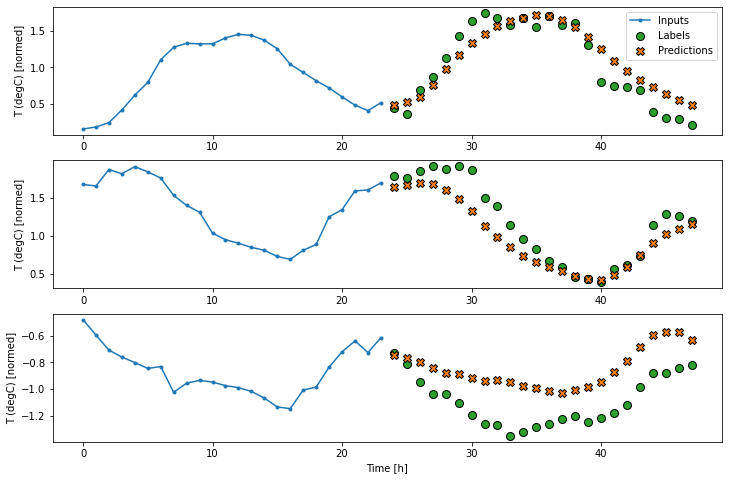

In [81]:
multi_dense_model = tf.keras.Sequential([
    # Take the last time step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, dense_units]
    tf.keras.layers.Dense(512, activation='relu'),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_dense_model, multi_window)

IPython.display.clear_output()
multi_val_performance['Dense'] = multi_dense_model.evaluate(multi_window.val)
multi_performance['Dense'] = multi_dense_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_dense_model)

#### CNN

A convolutional model makes predictions based on a fixed-width history, which may lead to better performance than the dense model since it can see how things are changing over time:

![A convolutional model sees how things change over time](images/multistep_conv.png)

  1/437 [..............................] - ETA: 21s - loss: 0.2051 - mean_absolute_error: 0.2709

 19/437 [>.............................] - ETA: 1s - loss: 0.2066 - mean_absolute_error: 0.2762 

 37/437 [=>............................] - ETA: 1s - loss: 0.2167 - mean_absolute_error: 0.2812

 55/437 [==>...........................] - ETA: 1s - loss: 0.2185 - mean_absolute_error: 0.2823

 73/437 [====>.........................] - ETA: 1s - loss: 0.2194 - mean_absolute_error: 0.2828

 92/437 [=====>........................] - ETA: 0s - loss: 0.2198 - mean_absolute_error: 0.2832

111/437 [======>.......................] - ETA: 0s - loss: 0.2200 - mean_absolute_error: 0.2834

129/437 [=======>......................] - ETA: 0s - loss: 0.2203 - mean_absolute_error: 0.2832

148/437 [=========>....................] - ETA: 0s - loss: 0.2188 - mean_absolute_error: 0.2825

167/437 [==========>...................] - ETA: 0s - loss: 0.2184 - mean_absolute_error: 0.2821

185/437 [===========>..................] - ETA: 0s - loss: 0.2179 - mean_absolute_error: 0.2818

204/437 [=============>................] - ETA: 0s - loss: 0.2184 - mean_absolute_error: 0.2821

223/437 [==============>...............] - ETA: 0s - loss: 0.2182 - mean_absolute_error: 0.2820

241/437 [===============>..............] - ETA: 0s - loss: 0.2181 - mean_absolute_error: 0.2818

260/437 [================>.............] - ETA: 0s - loss: 0.2186 - mean_absolute_error: 0.2821

279/437 [==================>...........] - ETA: 0s - loss: 0.2183 - mean_absolute_error: 0.2820

296/437 [===================>..........] - ETA: 0s - loss: 0.2180 - mean_absolute_error: 0.2818

314/437 [====================>.........] - ETA: 0s - loss: 0.2179 - mean_absolute_error: 0.2818

333/437 [=====================>........] - ETA: 0s - loss: 0.2175 - mean_absolute_error: 0.2815

351/437 [=======================>......] - ETA: 0s - loss: 0.2173 - mean_absolute_error: 0.2815

370/437 [========================>.....] - ETA: 0s - loss: 0.2177 - mean_absolute_error: 0.2816

389/437 [=========================>....] - ETA: 0s - loss: 0.2179 - mean_absolute_error: 0.2818

406/437 [==========================>...] - ETA: 0s - loss: 0.2176 - mean_absolute_error: 0.2816

424/437 [============================>.] - ETA: 0s - loss: 0.2172 - mean_absolute_error: 0.2815

437/437 [==============================] - 1s 3ms/step - loss: 0.2171 - mean_absolute_error: 0.2814


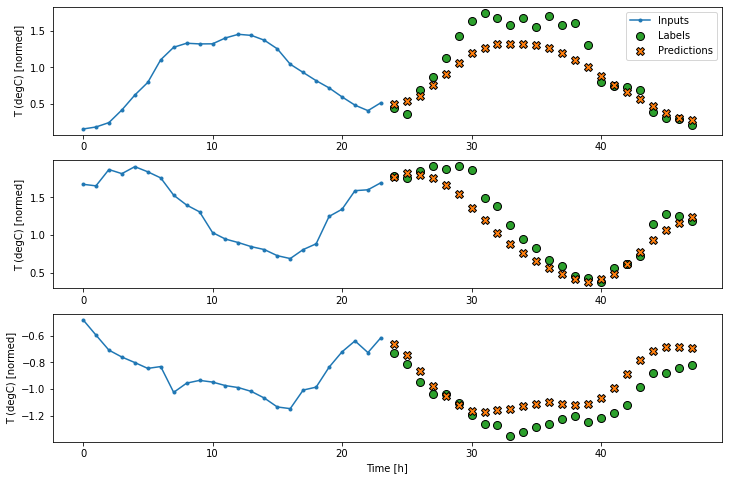

In [82]:
CONV_WIDTH = 3
multi_conv_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, CONV_WIDTH, features]
    tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    # Shape => [batch, 1, conv_units]
    tf.keras.layers.Conv1D(256, activation='relu', kernel_size=(CONV_WIDTH)),
    # Shape => [batch, 1,  out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_conv_model, multi_window)

IPython.display.clear_output()

multi_val_performance['Conv'] = multi_conv_model.evaluate(multi_window.val)
multi_performance['Conv'] = multi_conv_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_conv_model)

#### RNN

A recurrent model can learn to use a long history of inputs, if it's relevant to the predictions the model is making. Here the model will accumulate internal state for 24h, before making a single prediction for the next 24h.

In this single-shot format, the LSTM only needs to produce an output at the last time step, so set `return_sequences=False`.

![The lstm accumulates state over the input window, and makes a single prediction for the next 24h](images/multistep_lstm.png)


  1/437 [..............................] - ETA: 21s - loss: 0.1912 - mean_absolute_error: 0.2668

 18/437 [>.............................] - ETA: 1s - loss: 0.2173 - mean_absolute_error: 0.2862 

 36/437 [=>............................] - ETA: 1s - loss: 0.2143 - mean_absolute_error: 0.2835

 54/437 [==>...........................] - ETA: 1s - loss: 0.2149 - mean_absolute_error: 0.2835

 71/437 [===>..........................] - ETA: 1s - loss: 0.2146 - mean_absolute_error: 0.2838

 89/437 [=====>........................] - ETA: 1s - loss: 0.2165 - mean_absolute_error: 0.2853

106/437 [======>.......................] - ETA: 0s - loss: 0.2175 - mean_absolute_error: 0.2858

122/437 [=======>......................] - ETA: 0s - loss: 0.2161 - mean_absolute_error: 0.2850

140/437 [========>.....................] - ETA: 0s - loss: 0.2148 - mean_absolute_error: 0.2845

157/437 [=========>....................] - ETA: 0s - loss: 0.2145 - mean_absolute_error: 0.2842

174/437 [==========>...................] - ETA: 0s - loss: 0.2150 - mean_absolute_error: 0.2844

192/437 [============>.................] - ETA: 0s - loss: 0.2148 - mean_absolute_error: 0.2845

209/437 [=============>................] - ETA: 0s - loss: 0.2151 - mean_absolute_error: 0.2846

226/437 [==============>...............] - ETA: 0s - loss: 0.2149 - mean_absolute_error: 0.2844

244/437 [===============>..............] - ETA: 0s - loss: 0.2160 - mean_absolute_error: 0.2849

261/437 [================>.............] - ETA: 0s - loss: 0.2157 - mean_absolute_error: 0.2845

278/437 [==================>...........] - ETA: 0s - loss: 0.2155 - mean_absolute_error: 0.2846

296/437 [===================>..........] - ETA: 0s - loss: 0.2156 - mean_absolute_error: 0.2847

314/437 [====================>.........] - ETA: 0s - loss: 0.2157 - mean_absolute_error: 0.2847

332/437 [=====================>........] - ETA: 0s - loss: 0.2160 - mean_absolute_error: 0.2849

350/437 [=======================>......] - ETA: 0s - loss: 0.2156 - mean_absolute_error: 0.2847

367/437 [========================>.....] - ETA: 0s - loss: 0.2157 - mean_absolute_error: 0.2849

385/437 [=========================>....] - ETA: 0s - loss: 0.2160 - mean_absolute_error: 0.2850

404/437 [==========================>...] - ETA: 0s - loss: 0.2160 - mean_absolute_error: 0.2850

422/437 [===========================>..] - ETA: 0s - loss: 0.2167 - mean_absolute_error: 0.2854

437/437 [==============================] - 1s 3ms/step - loss: 0.2170 - mean_absolute_error: 0.2856


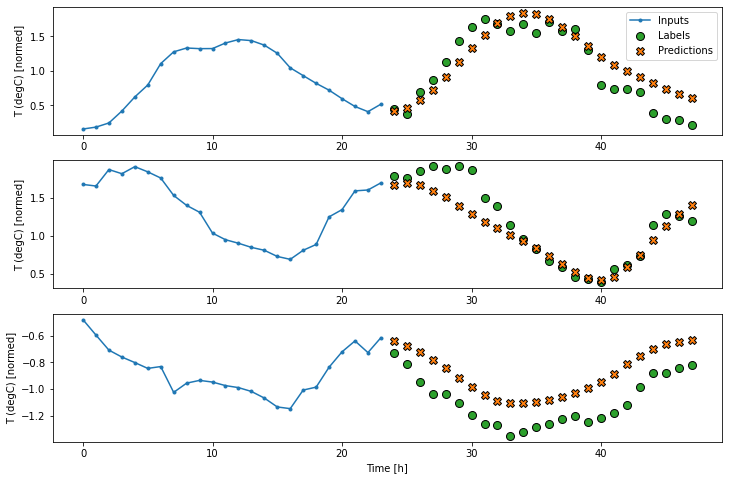

In [83]:
multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units]
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(32, return_sequences=False),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_lstm_model, multi_window)

IPython.display.clear_output()

multi_val_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.val)
multi_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_lstm_model)

### Advanced: Autoregressive model

The above models all predict the entire output sequence in a single step.

In some cases it may be helpful for the model to decompose this prediction into individual time steps. Then each model's output can be fed back into itself at each step and predictions can be made conditioned on the previous one, like in the classic [Generating Sequences With Recurrent Neural Networks](https://arxiv.org/abs/1308.0850).

One clear advantage to this style of model is that it can be set up to produce output with a varying length.

You could take any of the single-step multi-output models trained in the first half of this tutorial and run  in an autoregressive feedback loop, but here you'll focus on building a model that's been explicitly trained to do that.

![Feedback a model's output to its input](images/multistep_autoregressive.png)


#### RNN

This tutorial only builds an autoregressive RNN model, but this pattern could be applied to any model that was designed to output a single timestep.

The model will have the same basic form as the single-step `LSTM` models: An `LSTM` followed by a `layers.Dense` that converts the `LSTM` outputs to model predictions.

A `layers.LSTM` is a `layers.LSTMCell` wrapped in the higher level `layers.RNN` that manages the state and sequence results for you (See [Keras RNNs](https://www.tensorflow.org/guide/keras/rnn) for details).

In this case the model has to manually manage the inputs for each step so it uses `layers.LSTMCell` directly for the lower level, single time step interface.

In [84]:
class FeedBack(tf.keras.Model):
  def __init__(self, units, out_steps):
    super().__init__()
    self.out_steps = out_steps
    self.units = units
    self.lstm_cell = tf.keras.layers.LSTMCell(units)
    # Also wrap the LSTMCell in an RNN to simplify the `warmup` method.
    self.lstm_rnn = tf.keras.layers.RNN(self.lstm_cell, return_state=True)
    self.dense = tf.keras.layers.Dense(num_features)

In [85]:
feedback_model = FeedBack(units=32, out_steps=OUT_STEPS)

The first method this model needs is a `warmup` method to initialize its internal state based on the inputs. Once trained this state will capture the relevant parts of the input history. This is equivalent to the single-step `LSTM` model from earlier:

In [86]:
def warmup(self, inputs):
  # inputs.shape => (batch, time, features)
  # x.shape => (batch, lstm_units)
  x, *state = self.lstm_rnn(inputs)

  # predictions.shape => (batch, features)
  prediction = self.dense(x)
  return prediction, state

FeedBack.warmup = warmup

This method returns a single time-step prediction, and the internal state of the LSTM:

In [87]:
prediction, state = feedback_model.warmup(multi_window.example[0])
prediction.shape

TensorShape([32, 19])

With the `RNN`'s state, and an initial prediction you can now continue iterating the model feeding the predictions at each step back as the input.

The simplest approach to collecting the output predictions is to use a python list, and `tf.stack` after the loop.

Note: Stacking a python list like this only works with eager-execution, using `Model.compile(..., run_eagerly=True)` for training, or with a fixed length output. For a dynamic output length you would need to use a `tf.TensorArray` instead of a python list, and `tf.range` instead of the python `range`.

In [88]:
def call(self, inputs, training=None):
  # Use a TensorArray to capture dynamically unrolled outputs.
  predictions = []
  # Initialize the lstm state
  prediction, state = self.warmup(inputs)

  # Insert the first prediction
  predictions.append(prediction)

  # Run the rest of the prediction steps
  for n in range(1, self.out_steps):
    # Use the last prediction as input.
    x = prediction
    # Execute one lstm step.
    x, state = self.lstm_cell(x, states=state,
                              training=training)
    # Convert the lstm output to a prediction.
    prediction = self.dense(x)
    # Add the prediction to the output
    predictions.append(prediction)

  # predictions.shape => (time, batch, features)
  predictions = tf.stack(predictions)
  # predictions.shape => (batch, time, features)
  predictions = tf.transpose(predictions, [1, 0, 2])
  return predictions

FeedBack.call = call

Test run this model on the example inputs:

In [89]:
print('Output shape (batch, time, features): ', feedback_model(multi_window.example[0]).shape)

Output shape (batch, time, features):  (32, 24, 19)


Now train the model:

  1/437 [..............................] - ETA: 22s - loss: 0.2085 - mean_absolute_error: 0.2894

  8/437 [..............................] - ETA: 3s - loss: 0.2387 - mean_absolute_error: 0.3051 

 16/437 [>.............................] - ETA: 3s - loss: 0.2369 - mean_absolute_error: 0.3069

 23/437 [>.............................] - ETA: 2s - loss: 0.2310 - mean_absolute_error: 0.3028

 30/437 [=>............................] - ETA: 2s - loss: 0.2313 - mean_absolute_error: 0.3027

 37/437 [=>............................] - ETA: 2s - loss: 0.2300 - mean_absolute_error: 0.3024

 44/437 [==>...........................] - ETA: 2s - loss: 0.2300 - mean_absolute_error: 0.3020

 52/437 [==>...........................] - ETA: 2s - loss: 0.2314 - mean_absolute_error: 0.3026

 60/437 [===>..........................] - ETA: 2s - loss: 0.2329 - mean_absolute_error: 0.3037

 68/437 [===>..........................] - ETA: 2s - loss: 0.2311 - mean_absolute_error: 0.3024

 76/437 [====>.........................] - ETA: 2s - loss: 0.2302 - mean_absolute_error: 0.3021

 84/437 [====>.........................] - ETA: 2s - loss: 0.2290 - mean_absolute_error: 0.3013

 92/437 [=====>........................] - ETA: 2s - loss: 0.2282 - mean_absolute_error: 0.3007

 99/437 [=====>........................] - ETA: 2s - loss: 0.2282 - mean_absolute_error: 0.3007

107/437 [======>.......................] - ETA: 2s - loss: 0.2268 - mean_absolute_error: 0.2998

114/437 [======>.......................] - ETA: 2s - loss: 0.2267 - mean_absolute_error: 0.2998

122/437 [=======>......................] - ETA: 2s - loss: 0.2275 - mean_absolute_error: 0.3000

129/437 [=======>......................] - ETA: 2s - loss: 0.2264 - mean_absolute_error: 0.2996

136/437 [========>.....................] - ETA: 2s - loss: 0.2263 - mean_absolute_error: 0.2996

144/437 [========>.....................] - ETA: 2s - loss: 0.2254 - mean_absolute_error: 0.2990

151/437 [=========>....................] - ETA: 2s - loss: 0.2252 - mean_absolute_error: 0.2989

159/437 [=========>....................] - ETA: 1s - loss: 0.2260 - mean_absolute_error: 0.2994

167/437 [==========>...................] - ETA: 1s - loss: 0.2259 - mean_absolute_error: 0.2994

175/437 [===========>..................] - ETA: 1s - loss: 0.2258 - mean_absolute_error: 0.2994

183/437 [===========>..................] - ETA: 1s - loss: 0.2248 - mean_absolute_error: 0.2990

191/437 [============>.................] - ETA: 1s - loss: 0.2250 - mean_absolute_error: 0.2990

199/437 [============>.................] - ETA: 1s - loss: 0.2257 - mean_absolute_error: 0.2992

207/437 [=============>................] - ETA: 1s - loss: 0.2258 - mean_absolute_error: 0.2992

214/437 [=============>................] - ETA: 1s - loss: 0.2257 - mean_absolute_error: 0.2992

222/437 [==============>...............] - ETA: 1s - loss: 0.2260 - mean_absolute_error: 0.2992

230/437 [==============>...............] - ETA: 1s - loss: 0.2259 - mean_absolute_error: 0.2992

238/437 [===============>..............] - ETA: 1s - loss: 0.2256 - mean_absolute_error: 0.2992

246/437 [===============>..............] - ETA: 1s - loss: 0.2248 - mean_absolute_error: 0.2987

254/437 [================>.............] - ETA: 1s - loss: 0.2239 - mean_absolute_error: 0.2982

262/437 [================>.............] - ETA: 1s - loss: 0.2236 - mean_absolute_error: 0.2980

269/437 [=================>............] - ETA: 1s - loss: 0.2235 - mean_absolute_error: 0.2980

276/437 [=================>............] - ETA: 1s - loss: 0.2234 - mean_absolute_error: 0.2980

284/437 [==================>...........] - ETA: 1s - loss: 0.2235 - mean_absolute_error: 0.2981

291/437 [==================>...........] - ETA: 1s - loss: 0.2236 - mean_absolute_error: 0.2980

299/437 [===================>..........] - ETA: 0s - loss: 0.2236 - mean_absolute_error: 0.2981

306/437 [====================>.........] - ETA: 0s - loss: 0.2235 - mean_absolute_error: 0.2981

313/437 [====================>.........] - ETA: 0s - loss: 0.2240 - mean_absolute_error: 0.2984

321/437 [=====================>........] - ETA: 0s - loss: 0.2241 - mean_absolute_error: 0.2984

328/437 [=====================>........] - ETA: 0s - loss: 0.2241 - mean_absolute_error: 0.2983

336/437 [======================>.......] - ETA: 0s - loss: 0.2243 - mean_absolute_error: 0.2985

344/437 [======================>.......] - ETA: 0s - loss: 0.2244 - mean_absolute_error: 0.2985

352/437 [=======================>......] - ETA: 0s - loss: 0.2242 - mean_absolute_error: 0.2984

359/437 [=======================>......] - ETA: 0s - loss: 0.2243 - mean_absolute_error: 0.2984

366/437 [========================>.....] - ETA: 0s - loss: 0.2243 - mean_absolute_error: 0.2985

374/437 [========================>.....] - ETA: 0s - loss: 0.2243 - mean_absolute_error: 0.2985

381/437 [=========================>....] - ETA: 0s - loss: 0.2243 - mean_absolute_error: 0.2984

389/437 [=========================>....] - ETA: 0s - loss: 0.2242 - mean_absolute_error: 0.2984

396/437 [==========================>...] - ETA: 0s - loss: 0.2241 - mean_absolute_error: 0.2983

404/437 [==========================>...] - ETA: 0s - loss: 0.2242 - mean_absolute_error: 0.2983

411/437 [===========================>..] - ETA: 0s - loss: 0.2243 - mean_absolute_error: 0.2985

418/437 [===========================>..] - ETA: 0s - loss: 0.2242 - mean_absolute_error: 0.2984

425/437 [============================>.] - ETA: 0s - loss: 0.2244 - mean_absolute_error: 0.2984

432/437 [============================>.] - ETA: 0s - loss: 0.2243 - mean_absolute_error: 0.2984

437/437 [==============================] - 3s 7ms/step - loss: 0.2240 - mean_absolute_error: 0.2982


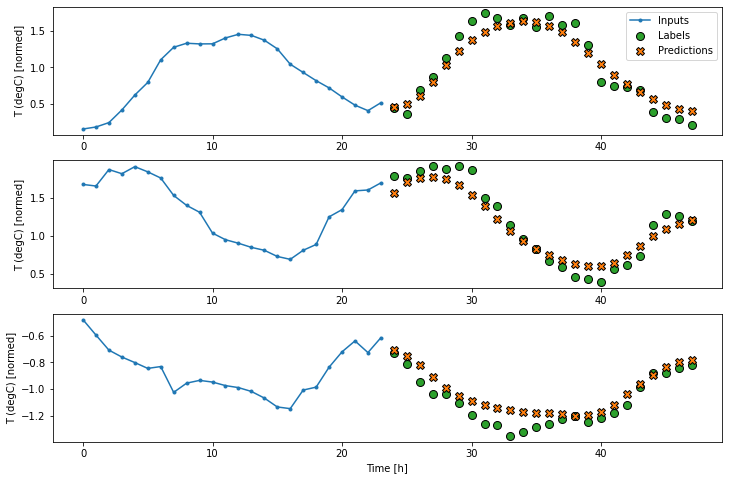

In [90]:
history = compile_and_fit(feedback_model, multi_window)

IPython.display.clear_output()

multi_val_performance['AR LSTM'] = feedback_model.evaluate(multi_window.val)
multi_performance['AR LSTM'] = feedback_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(feedback_model)

### Performance

There are clearly diminishing returns as a function of model complexity on this problem.

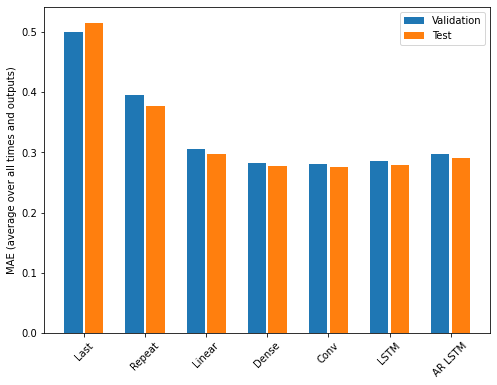

In [91]:
x = np.arange(len(multi_performance))
width = 0.3


metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in multi_val_performance.values()]
test_mae = [v[metric_index] for v in multi_performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=multi_performance.keys(),
           rotation=45)
plt.ylabel(f'MAE (average over all times and outputs)')
_ = plt.legend()

The metrics for the multi-output models in the first half of this tutorial show the performance averaged across all output features. These performances similar but also averaged across output timesteps. 

In [92]:
for name, value in multi_performance.items():
  print(f'{name:8s}: {value[1]:0.4f}')

Last    : 0.5157
Repeat  : 0.3774
Linear  : 0.2979
Dense   : 0.2769
Conv    : 0.2750
LSTM    : 0.2797
AR LSTM : 0.2904


The gains achieved going from a dense model to convolutional and recurrent models are only a few percent (if any), and the autoregressive model performed clearly worse. So these more complex approaches may not be worth while on **this** problem, but there was no way to know without trying, and these models could be helpful for **your** problem.

## Next steps

This tutorial was a quick introduction to time series forecasting using TensorFlow.

* For further understanding, see:
  * Chapter 15 of [Hands-on Machine Learning with Scikit-Learn, Keras, and TensorFlow](https://www.oreilly.com/library/view/hands-on-machine-learning/9781492032632/), 2nd Edition 
  * Chapter 6 of [Deep Learning with Python](https://www.manning.com/books/deep-learning-with-python).
  * Lesson 8 of [Udacity's intro to TensorFlow for deep learning](https://www.udacity.com/course/intro-to-tensorflow-for-deep-learning--ud187), and the [exercise notebooks](https://github.com/tensorflow/examples/tree/master/courses/udacity_intro_to_tensorflow_for_deep_learning) 
* Also remember that you can implement any [classical time series model](https://otexts.com/fpp2/index.html) in TensorFlow, this tutorial just focuses on TensorFlow's built-in functionality.